### Dependency

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/DATA304'

/content/drive/MyDrive/DATA304


In [3]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib jsonlines

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 92.6/92.6 MB 18.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 265.7/265.7 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

### 0. Accelerator

In [4]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

### 0.5. Preprocessing

In [ ]:
import random
import numpy as np
import torch
import json
import pandas as pd
from datasets import Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

seed_value = 410
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

df = pd.read_csv('daangn.csv', encoding='utf-8-sig')
df = df.dropna()

df_train, df_test = train_test_split(df, test_size=309, random_state=42)
print(len(df_train), len(df_test))

def preprocess_df(df):
    df['up'] = df['Time Posted'].apply(lambda x: 1 if x.startswith('ÎÅåÏò¨') else 0)

    def get_time_in_days(s):
        number = int(''.join(filter(str.isdigit, s)))
        if 'Ïùº' in s:
            return number
        elif 'ÏãúÍ∞Ñ' in s:
            return number / 24.0
        else:
            return 0

    df['time'] = df['Time Posted'].apply(get_time_in_days)

    return df

df_train = preprocess_df(df_train)
df_test = preprocess_df(df_test)

61000 309


In [ ]:
import json

def process_and_save_to_jsonl(df, file_name):
    with open(file_name, 'w', encoding='utf-8') as file:
        for _, row in df.iterrows():
            input_text = f"Ï†úÎ™©: {row['Title']}, \n ÏÉÅÌíà ÏÑ§Î™Ö: {row['Description']}"
            output_val = 1 if row['time'] >= 7 else 0
            record = {"input": input_text, "output": str(output_val)}
            file.write(json.dumps(record, ensure_ascii=False) + '\n')

process_and_save_to_jsonl(df_train, 'train.jsonl')
process_and_save_to_jsonl(df_test, 'eval.jsonl')

In [ ]:
with open('train.jsonl', 'w') as f:
    for item in train_dataset:
        f.write(json.dumps(item) + '\n')

with open('eval.jsonl', 'w') as f:
    for item in eval_dataset:
        f.write(json.dumps(item) + '\n')

# with open('temp.jsonl', 'w') as f:
#    for item in temp_dataset:
#        f.write(json.dumps(item) + '\n')

### 1. Load Dataset

In [5]:
from datasets import load_dataset
import json

train_dataset = load_dataset('json', data_files='train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='eval.jsonl', split='train')
# temp_dataset = load_dataset('json', data_files='temp.jsonl', split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
def formatting_func(example):
    text = f"""ÎÑàÎäî ÏßÄÍ∏à Ï§ëÍ≥†Í±∞Îûò ÌîåÎû´ÌèºÏùÑ Ïö¥ÏòÅÌïòÍ≥† ÏûàÎäî Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑùÍ∞ÄÏïº.
ÏïÑÎûòÏóê ÏûÖÎ†•ÎêòÎäî Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.

ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.

ÏÉÅÌíà ÏÑ§Î™Ö:
{example['input']}

ÏòàÏ∏° Í≤∞Í≥º: {example['output']}"""
    return text

### 2. Load Base Model

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "nlpai-lab/kullm-polyglot-12.8b-v2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    quantization_config=bnb_config
)

config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/52.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/6.01G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

### 3. Tokenization

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)
# tokenized_temp_dataset = temp_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/61000 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

61309


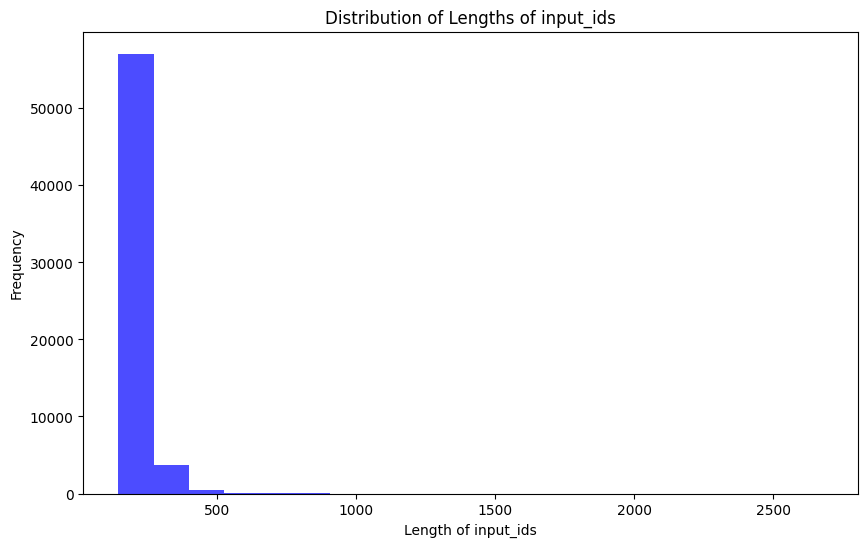

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [11]:
max_length = 256

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [12]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)
# tokenized_temp_dataset = temp_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/61000 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

In [13]:
print(tokenized_train_dataset[1]['input_ids'])

[1049, 272, 1048, 7420, 2459, 11318, 276, 1163, 4296, 327, 272, 3293, 1496, 29667, 17, 202, 12657, 274, 9272, 605, 272, 4526, 359, 1772, 1251, 276, 7176, 1369, 307, 1772, 270, 11318, 274, 23621, 605, 283, 2402, 632, 1185, 270, 831, 393, 958, 7995, 2259, 831, 393, 4269, 7995, 3983, 310, 5424, 17, 202, 494, 539, 284, 379, 893, 6690, 1772, 270, 1400, 605, 272, 971, 274, 831, 393, 4269, 270, 8970, 295, 2259, 831, 393, 958, 270, 8970, 295, 3983, 284, 272, 388, 359, 2729, 310, 17, 202, 202, 978, 293, 12571, 1058, 423, 272, 388, 296, 1772, 270, 11318, 274, 23621, 605, 283, 2402, 632, 1185, 270, 831, 393, 958, 7995, 2259, 831, 393, 4269, 7995, 3983, 288, 1211, 489, 17, 202, 202, 3007, 1251, 29, 202, 400, 919, 29, 24838, 267, 5964, 1110, 24838, 17338, 595, 5494, 341, 2750, 15, 224, 202, 1772, 1251, 29, 24838, 267, 5964, 1110, 24838, 17338, 202, 535, 5494, 454, 2750, 202, 646, 1509, 961, 352, 202, 25022, 12380, 601, 533, 1449, 202, 22736, 12380, 5208, 4884, 380, 547, 436, 622, 827, 17, 202, 1785

61309


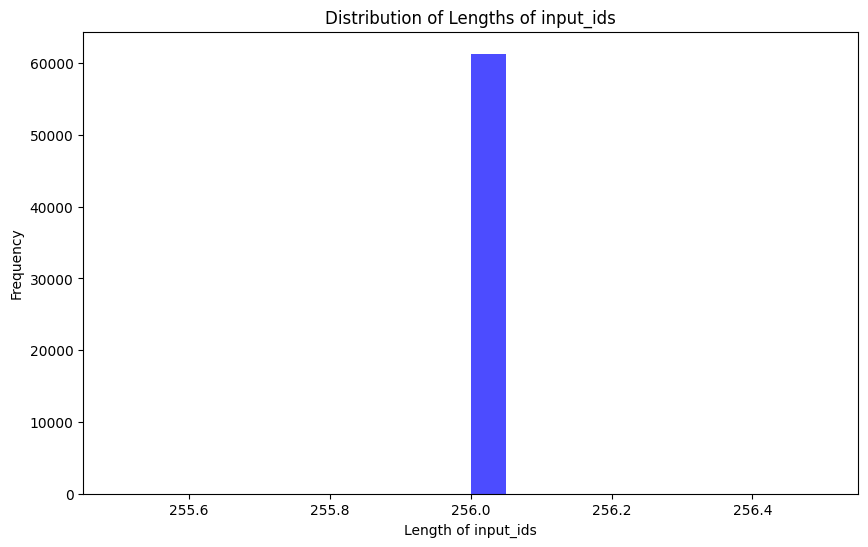

In [14]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

In [15]:
import gc
gc.collect()

torch.cuda.empty_cache()

In [17]:
import jsonlines
from tqdm import tqdm
import warnings
from transformers import logging

import jsonlines
from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=base_model_id)

model.eval()

def predict_with_pipe(eval_input):
    eval_prompt = f"""[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

{eval_input}
ÏòàÏ∏° Í≤∞Í≥º: """
    output = pipe(eval_prompt,
                  pad_token_id=pipe.tokenizer.eos_token_id,
                  max_new_tokens=7,
                  repetition_penalty=1.1,
                  no_repeat_ngram_size=3)
    answer = output[0]["generated_text"].strip()
    print(answer)
    return answer

with jsonlines.open('eval.jsonl') as reader, jsonlines.open('predictions_12b.jsonl', mode='w') as writer:
    for eval_entry in tqdm(reader, total=len(eval_dataset)):
        eval_input = eval_entry['input']
        answer = predict_with_pipe(eval_input)
        writer.write({"input": eval_input, "output": answer})

print("Predictions have been written to predictions_12b.jsonl")

  0%|          | 1/309 [00:03<17:01,  3.32s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌîåÏä§5 ÎîîÏä§ÌÅ¨ ÌåêÎß§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Íµ∞ÎåÄ Í∞ÄÍ≤å ÎêòÏñ¥ ÌåêÎß§Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7": "1


  1%|          | 2/309 [00:07<20:45,  4.06s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌõÑÎìú Î™©Î≤†Í∞ú 2Í∞ú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌõÑÎìúÍ∞Ä Îã¨Î†§ÏûàÎäî Î™©Î≤†Í≤åÏûÖÎãàÎã§.
2Í∞ú, ÏÉàÍ≤ÉÏûÖÎãàÎã§. ÏÇ¨ÏßÑÏ∞çÏúºÎ†§Í≥† ÎπÑÎãêÌè¨Ïû•ÏóêÏÑú Í∫ºÎÉàÏäµÎãàÎã§.
Ïûò Îïå Ï£ºÎ≥ÄÏùÑ Í∞ÄÎ†§Ï£ºÍ≥† Î≥¥Ïò®Ìö®Í≥ºÎèÑ ÏûàÏñ¥Ïöî.
ÏÇ¨ÏßÑÏ≤òÎüº 2Í∞ÄÏßÄ ÏÉâÏÉÅÏúºÎ°ú ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Î¶¨Î≤ÑÏãúÎ∏îÏûÖÎãàÎã§.
Ìà¨Ïç∏ÌîåÎ†àÏù¥Ïä§, Ïä§ÌÉÄÎ≤ÖÏä§ Í∏∞ÌîÑÌã∞ÏΩòÍ≥º ÍµêÌ

  1%|          | 3/309 [00:11<18:53,  3.71s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Îã§Ïù¥ÎÑ§Ï¶à4 Ïä§Ìä∏Î°úÌÅ¨ Î°±Í∏ÄÎü¨Î∏å, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 4Ïä§Ìä∏Î°úÌÅ¨ Î°± Í∏ÄÎü¨Î∏å ÏÇ¨Ïù¥Ï¶àÎäî s ÎÇ®Ïûê ÏûëÏùÄÏÜêÏù¥ Ï†ÅÎãπ Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"title":


  1%|‚ñè         | 4/309 [00:15<19:11,  3.77s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î°úÏûâÎ®∏Ïã† Ïö¥ÎèôÍ∏∞Í≥Ñ Í∑ºÎ†• Ïú†ÏÇ∞ÏÜå Ï†ÑÏã†Ïö¥Îèô, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïø†Ìå°ÏóêÏÑú ÏÇ¨Í≥† Ìïú 5Î≤àÏ†ïÎèÑ ÏçºÎÑ§Ïöî.
Í∏âÎß§ ÏûÖÎãàÎã§. Î∞îÎ°ú Í∞ÄÏ†∏Í∞ÄÏã§Î∂ÑÏùÄ Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî.
ÏòàÏ∏° Í≤∞Í≥º: https://coup


  2%|‚ñè         | 5/309 [00:19<19:30,  3.85s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÏù¥Ïï± ÏπºÌïòÌä∏ OG ACTIVE JACKET MÏÇ¨Ïù¥Ï¶à, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í∏àÏùº ÏàòÎ†πÌïú ÏïÑÏù¥Ïï± ÏπºÌïòÌä∏ OG ACTIVE JACKET MÏÇ¨Ïù¥Ï¶àÏûÖÎãàÎã§!! ÏßÅÍ±∞ÎûòÎäî ÏÑ±Í∑†Í¥ÄÎåÄÏó≠ÏóêÏÑú ÏßÑÌñâÌï©ÎãàÎã§. ÌÉùÎ∞∞ Í±∞Îûò Ïãú ÎπÑÏö© 5000Ïõê Ï∂îÍ∞ÄÎê©ÎãàÎã§ Í∞êÏÇ¨Ìï©ÎãàÎã§!
ÏòàÏ∏° Í≤∞Í≥º: 000ÏïàÎÖïÌïòÏÑ∏Ïöî~~


  2%|‚ñè         | 6/309 [00:22<18:39,  3.69s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î™®Ïó¨Î¥êÏöî ÎèôÎ¨ºÏùòÏà≤ Ïπ©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î™®ÎèôÏà≤ Ïπ©ÏûÖÎãàÎã§
Íµ¨Îß§ÌïúÏßÄ 6Í∞úÏõîÎèÑ Ïïà ÎêòÏóàÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {7}ÏïàÎÖïÌïòÏÑ∏Ïöî


  2%|‚ñè         | 7/309 [00:25<18:02,  3.59s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í∏∞ÌîÑÌã∞ÏΩò ÌåîÏïÑÏöî!, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïπ¥ÌéòÎ•º Ïûò ÏïàÍ∞ÄÏÑú ÌåêÎß§Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


  3%|‚ñé         | 8/309 [00:29<18:51,  3.76s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎìÄÏñºÏÜåÎãâ ÌîÑÎ°úÌéòÏÖîÎÑê ÏÑ∏Ìä∏ ÌåùÎãàÎãπ~, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎØ∏Í∞úÎ¥â Î∏îÎ£®Î∞ç ÏàòÎ∂ÑÏ†§3Í∞ú+Ìå©5Í∞ú+Ï∂©Ï†ÑÍ∏∞ Íµ¨ÏÑ±Ìíà
ÌíÄÏÑ∏Ìä∏Î°ú ÌåùÎãàÎã§~
face ÌÉÄÏûÖ; 7702ÏÉ∑ ÎÇ®Ïùå(Ï¥ù9000ÏÉ∑)
eye ÌÉÄÏûÖ; 57160ÏÉ∑ ÎÇ®Ïùå(Ï¥ù6000ÏÉ∑)
ÏÉ∑ Ï°∞Í∏à Ïì∞Í∏¥ÌñáÏßÄÎßå ÏïÑÏßÅ ÎßéÏù¥ ÎÇ®ÏïÑÏûàÏñ¥Ïöî~
Í∂ÅÍ∏àÌïòÏã† ÏÇ¨Ìï≠ÏûáÏúºÏãúÎ©¥ Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî~!
ÏòàÏ∏° 

  3%|‚ñé         | 9/309 [00:34<20:20,  4.07s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: (ÎØ∏Í∞úÎ¥â) Í∞§Îü≠Ïãú ÌÉ≠ A7 Lite 64gb Lte ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: A7 Lite 64Í∏∞Í∞Ä Lte ÎØ∏Í∞úÎ¥â ÌåùÎãàÎã§  23ÎÖÑ 5Ïõî Ï†úÏ°∞
23ÎÖÑ 6ÏõîÎã¨ Í∞úÌÜµ 8ÏõîÎã¨ ÌôïÏ†ïÍ∏∞Î≥Ä Ï†ïÏÉÅÌï¥ÏßÄ Ï†úÌíàÏûÖÎãàÎã§
ÍπîÎÅîÌïòÍ≤å ÎßàÎ¨¥Î¶¨ Îêú Ï†úÌíà ~ Ïú†Ïã¨, ÏôÄÏù¥ÌååÏù¥ ÏÇ¨Ïö©Í∞ÄÎä•
ÏßÅÍ±∞ÎûòÌï©ÎãàÎã§
‚õîÔ∏èÎåÄÎüâ Íµ¨Îß§ ÏõêÌïòÏãúÎäîÎ∂ÑÎèÑ ÎåÄÌôîÏ£ºÏÑ∏Ïöî‚

  3%|‚ñé         | 10/309 [00:38<20:13,  4.06s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î°úÎß®Ìã± ÌååÏù¥Ïñ¥Î¶¨Ï∏† Îß®Ìà¨Îß® xl, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï†ëÏñ¥ÏÑú Ïò∑Ïû•Ïóê Í≥ÑÏÜç Î≥¥Í¥ÄÌï¥ÏÑú Íµ¨ÍπÄÏùÄ ÏûàÏßÄÎßå ÏÉÅÌÉúÎäî ÏïÑÏ£º Ï¢ãÏïÑÏöî 
Ïù¥Ïóº Ïò§Ïóº ÌïòÎÇòÎèÑ ÏóÜÏäµÎãàÎã§
Î∞òÌÉù Í∞ÄÎä•Ìï©ÎãàÎã§
3Î≤å Ïù¥ÏÉÅ ÏÇ¨ÏãúÎ©¥ 1Î≤åÎãπ ÎßåÏõêÏóê ÎìúÎ¶ΩÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:    0   1


  4%|‚ñé         | 11/309 [00:44<23:11,  4.67s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎßåÏÇ≠Ïä§ÎÉÖ,ÏÖÄÌîÑÏõ®Îî© ÏõêÌîºÏä§ ÎìúÎ†àÏä§ ÌåùÎãàÎã§. 1ÌöåÏ∞©Ïö©. ÌÇ¥Ïä§Î∂ÄÎù†ÎÅÑ Ï†úÌíà., 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïò¨Ìï¥ 2Ïõî ÎßåÏÇ≠Ïä§ÎÉÖ ÏúÑÌï¥ Íµ¨Îß§Ìïú ÏõêÌîºÏä§ÏûÖÎãàÎã§.
Í∞ÄÏä¥ÎèÑ Î∞∞ÎèÑ Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú Ïó¨Ïú†ÏûàÍ≥† ÏïΩÍ∞Ñ Ïã†Ï∂ïÏÑ±ÎèÑ ÏûàÏñ¥ÏÑú ÏûÑÏÇ∞Î∂ÄÍ∞Ä ÏûÖÍ∏∞ Ï†ÑÌòÄ Î∂ÄÎã¥ÏóÜÍ≥† 
ÏôÑÏ†Ñ ÌôîÏù¥Ìä∏Í∞Ä ÏïÑÎãàÍ≥† ÏÇ¥Íµ¨ÏÉâÏù¥Îùº ÏõúÌÜ§ÏóêÍ

  4%|‚ñç         | 12/309 [00:48<22:05,  4.46s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎìÄÏãúÌä∏ÎùºÏù¥ÌÅ¨ - Ïú†ÏïÑ ÏÑ∏Î∞úÏûêÏ†ÑÍ±∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: JUCY TRIKE ÌåêÎß§Ìï©ÎãàÎã§~
ÏßÄÍ∏àÏùÄ ÏóâÏïÑÍ∞Ä ÎêòÏñ¥ÏÑú Ïûò ÏïàÏì∞Í≤å ÎêòÏñ¥ ÌåùÎãàÎã§.
ÏûêÏ†ÑÍ±∞ Î≤® Ïûò Ïö∏Î¶¨Íµ¨Ïöî Î∞îÌÄ¥ÎèÑ Í≥†Ïû•ÏïàÎÇ¨Ïñ¥Ïöî.
Íµ¨ÏÑ±ÌíàÏùÄ ÏÇ¨ÏßÑÏùÑ Ï∞∏Í≥†ÌïòÏÑ∏Ïöî~
Ïò•Ï†ïÏûÖÎãàÎã§~
ÏòàÏ∏° Í≤∞Í≥º: {"number":


  4%|‚ñç         | 13/309 [00:52<21:09,  4.29s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î¶¨ ÌõÑÎìúÌã∞ ÏÉàÏÉÅÌíà ÌÉù‚≠ïÔ∏è, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌÉù Îã¨Î¶∞ ÏÉàÏÉÅÌíàÏù¥ÏóêÏöî!
ÏÇ¨Ïù¥Ï¶àÎØ∏Ïä§Î°ú ÌåùÎãàÎã§
ÏõêÍ∞Ä 79000 ÌòÑÏû¨ Îã®Ï¢Ö
ÏòàÏ∏° Í≤∞Í≥º: üëâÔøΩ


  5%|‚ñç         | 14/309 [00:56<20:28,  4.16s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎìÄÎûëÍ≥† Ï∫êÎπà, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎìÄÎûëÍ≥† Ï∫êÎπàÏûÖÎãàÎã§.
Ï∫êÎπàÏúºÎ°ú 1Î∞ïÏî© Ï∫†Ìïë4Î≤à Îã§ÎÖÄÏôÄÎ¥§ÎäîÎç∞ Î¨¥Í≤å ÎïåÎ¨∏Ïóê ÏûëÏùÄÌÖêÌä∏Î°ú Î∞îÍæ∏Î†§Í≥† ÎÇ¥ÎÜìÏäµÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º:  0.7Ïùº  0


  5%|‚ñç         | 15/309 [00:59<19:06,  3.90s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï£ºÎ∞©ÎÜÄÏù¥ ÏÑ∏Ìä∏ ÌåîÏïÑÏöî, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï£ºÎ∞©ÎÜÄÏù¥ ÏÜåÌíà ÏùºÍ¥Ñ ÌåêÎß§.
ÏÇ¨Ïö©Í∞ê ÏûàÏñ¥Ïöî.
ÏòàÏ∏° Í≤∞Í≥º: {"number":


  5%|‚ñå         | 16/309 [01:05<20:57,  4.29s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎèÑÏöî Î≤†Ïù¥Ìä∏Î¶¥ ÌåùÎãàÎã§.(Ïö∞Ìï∏Îì§), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎèÑÏöî Ïö∞ÎùºÎÖ∏ dlc(7Ï†êÎåÄ)15ÎßåÏõê(ÎùºÏù∏ 5ÎßåÏõêÏßúÎ¶¨ 1Ìò∏Ìï©ÏÇ¨)   Ïö∞ÎùºÎÖ∏ g3 Ïù∏ÏáºÏñ¥(5Ï†êÎåÄ)10ÎßåÏõê  (ÎùºÏù∏ Ï†ÄÍ∞ÄÌòï 1Ìò∏ Ìï©ÏÇ¨) ÎùºÍ∑∏ÎÇò(7Ï†êÎåÄ)6ÎßåÏõê ÌåùÎãàÎã§(ÎùºÏù∏ Ï†ÄÍ∞ÄÌòï1Ìò∏ Ìï©ÏÇ¨)
Ìï∏Îì§ÏùÄ Ï†ÑÎ∂Ä 130mm ÏóêÎ∞î Ïπ¥Î≥∏Ìï∏ÌãÄÏù¥Î©∞ ÏàúÏ†ïÌï∏Îì§ Îã§ Í∞ÄÏßÄÍ≥† 

  6%|‚ñå         | 17/309 [01:08<19:21,  3.98s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î≥¥ÏàòÎ≥º ÌïòÌîÑÏßêÎ≥º ÎèîÎ≥º, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î≥¥ÏàòÎ≥º 61cm ÌåêÎß§Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {0}, {1


  6%|‚ñå         | 18/309 [01:11<18:14,  3.76s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏôÄÏù¥ÎìúÏïµÍ∏Ä Í≥®ÌîÑÏõ®Ïñ¥ ÏπòÎßà, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏôÄÏù¥Îìú ÏïµÍ∏Ä ÏπòÎßà
ÏûêÏÑ∏Ìïú ÏπòÏàòÎäî ÏÇ¨ÏßÑ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


  6%|‚ñå         | 19/309 [01:14<17:27,  3.61s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïò§ÌîÑÏàÑÎçî Í≥®ÏßÄ ÎãàÌä∏ Î∏åÏù¥ÎÑ• Ïñ¥Íπ® Ìä∏ÏûÑ (Ïò§Ìä∏Î≤†Ïù¥ÏßÄ), 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï∞©Ïö©X
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


  6%|‚ñã         | 20/309 [01:18<16:51,  3.50s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìè¥Î°ú ÎãàÌä∏ÏßëÏóÖ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï£ºÎãàÏñ¥ ÎùºÏßÄÏûÖÎãàÎã§ Ïó¨ÏÑ± 55ÍπåÏßÄ ÎßûÏïÑÏöî
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº"},


  7%|‚ñã         | 21/309 [01:22<18:15,  3.80s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î¨¥Îä¨Ïã±Í≥†ÎãàÏõÄ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î¨¥Îä¨Ïã±Í≥†ÎãàÏõÄÏûÖÎãàÎã§.
Ïª§ÌîºÏªµÏóê Ïã¨Í≤®Ï†∏ ÏûàÏäµÎãàÎã§.
Î∂ÑÍ∞àÏù¥ ÌïòÎ©∞ Ïª∑ÌåÖÌïú Î∞îÌÖÄ Í∞úÏ≤¥ÏòàÏöî.
ÎïåÎ¨∏Ïóê ÎøåÎ¶¨ Í±±Ï†ïÏùÄ ÏóÜÏúºÏã§ Í±∞ÏòàÏöî.
Î∞òÎ∞òÎ¨¥Îä¨ Ïûé ÏïÑÏ£º ÏòàÏÅúÏïÑÏù¥ÏòàÏöî.
ÏïûÏúºÎ°úÎèÑ Îπõ Ïûò Î≥¥Ïó¨Ï£ºÏÖîÏïº Ï∂îÌõÑ ÏûéÎèÑ ÏòàÏÅòÍ≤å ÎÇòÏòµÎãàÎã§.
ÏÇ¥Ïßù ÏÉÅÌïú ÏûéÏù¥ ÌïòÎÇò 

  7%|‚ñã         | 22/309 [01:25<17:26,  3.65s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïª§Ïä§ÌÖÄ ÌÇ§Î≥¥Îìú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ìé∏ÏßëÌï†Îïå ÏõêÌïòÎäî ÎåÄÎ°ú ÌÇ§ÏûÖÎ†•Ìï¥ÏÑú Ïì∞ÎäîÌÇ§Î≥¥ÎìúÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


  7%|‚ñã         | 23/309 [01:29<16:49,  3.53s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï†ÑÍ∏∞Ïû•Ìåê, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 180.135
ÏÉÅÌÉúÏ¢ãÏïÑÏöî
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


  8%|‚ñä         | 24/309 [01:32<16:24,  3.45s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: [M.XL]Ïä§Ìà¨Ïãú ÏõîÎìúÌà¨Ïñ¥ ÌõÑÎìú ÌîºÍ∑∏Î®ºÌä∏ Î∏îÎûô, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Íµ≠ÎÇ¥ÏÉàÏ†úÌíàÏûÖÎãàÎã§ ÏÑúÏö∏Ïû•ÏïàÎèôÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: 000000000It


  8%|‚ñä         | 25/309 [01:35<16:05,  3.40s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎÖ∏Ïπ¥ÎùºÏûêÏºì, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 55Ïã∏Ïù¥Ï¶à ÏûÖÎãàÎã§
ÏöîÏ¶òÏûÖÍ∏∞ Îî± Ï¢ãÏïÑÏöî
ÏòàÏ∏° Í≤∞Í≥º: {"name": "


  8%|‚ñä         | 26/309 [01:38<15:54,  3.37s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏãùÌíàÍ±¥Ï°∞Í∏∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 2Ìöå ÏÇ¨Ïö©~~
Ï§ëÍ≥†Îùº ÏÇ¨Ïö©Í∞êÏùÄ ÏûàÏúºÎÇò ÏÇ¨Ïö©ÌïòÏãúÎäîÎç∞ Î¨∏Ï†ú ÏóÜÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {} ‚Äã‚Äã2


  9%|‚ñä         | 27/309 [01:42<15:44,  3.35s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎèÑÏûêÍ∏∞ÌïÑÌÜµ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïú†Î™ÖÏûëÍ∞Ä ÏûëÌíàÎèÑÏûêÍ∏∞
ÌïÑÌÜµÏûÖÎãàÎã§
ÏûëÍ∞ÄÏù¥Î¶ÑÏù¥ ÏÉùÍ∞ÅÏïàÎÇòÎÑ§Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {7Ïùº ÎØ∏Îßå},


  9%|‚ñâ         | 28/309 [01:46<16:29,  3.52s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÉàÏÉÅÌíà Î°úÏπ¥ ÏñëÌÑ∏ÌõÑÎ¶¨Ïä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÏÉÅÌíà Î°úÏπ¥ ÏñëÌÑ∏ÌõÑÎ¶¨Ïä§ÏòàÏöî
Ìù∞ÏÉâÏù¥Í≥†Ïöî ÏÇ¨Ïù¥Ï¶à 90Ïù¥ÏòàÏöî 
Í≥µÏö©ÏÇ¨Ïù¥Ï¶àÎ°ú ÎÇòÏôÄÏÑú ÎÑâÎÑâÌï¥Ïöî.
Ìò∏Í≥ÑÎèÑÏÑúÍ¥Ä ÏßÅÍ±∞Îûò, Î∞òÍ∞íÌÉùÎ∞∞(+1,800Ïõê)
ÏùºÎ∞òÌÉùÎ∞∞(+2,500Ïõê)ÎèÑ Í∞ÄÎä•Ìï¥Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"number":


  9%|‚ñâ         | 29/309 [01:50<17:00,  3.64s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎûÄÍ∞ÄÍµ¨ ÎØ∏ÎÅÑÎüºÌãÄ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎûÄÍ∞ÄÍµ¨ ÎØ∏ÎÅÑÎüºÌãÄÏù¥ÏóêÏöî.
Î∂ÄÌîºÍ∞Ä ÏûàÏñ¥ÏÑú Í∞ÄÏßÄÎü¨Ïò§ÏÖîÏïºÌï©ÎãàÎã§:)
Î∂ÑÌï¥Ìï¥ÎìúÎ†§Ïöî.
ÏÉàÏÉÅÌíàÏùÄ ÏïÑÎãàÎãà ÏòàÎØºÎßòÏùÄ ÌîºÌï¥Ï£ºÏÑ∏Ïöîüôèüèªüôèüèªüôèüèª
ÏòàÏ∏° Í≤∞Í≥º:  1ÏïàÎÖïÌïòÏÑ∏Ïöî~~


 10%|‚ñâ         | 30/309 [01:53<17:18,  3.72s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∏åÎùºÏö¥Î∏åÎ†àÏä§ ÌõÑÎìúÌã∞(ÎÑ§Ïù¥ÎπÑ), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨Í≥† ÏßÑÏßú Îëê Î≤à ÏûÖÏóàÏäµÎãàÎã§ ÏÉÅÌÉú Ï¢ãÍ≥† Î¨¥Ïã†ÏÇ¨ÏóêÏÑú 79,000ÏõêÏóê Íµ¨Îß§ÌñàÏäµÎãàÎã§ ÏÇ¨Ïù¥Ï¶à mÏûÖÎãàÎã§ Ïò§Î≤ÑÌïèÏù¥Îùº ÌèâÏÜåÏóê lÏûÖÎäî Î∂ÑÎì§ÎèÑ Ï∂©Î∂ÑÌûà ÎßûÏúºÏÑ∏Ïöî
ÏòàÏ∏° Í≤∞Í≥º: if (currentT


 10%|‚ñà         | 31/309 [01:57<17:33,  3.79s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∞õÏπ®ÏóÜÎäîÎèôÌôîÏãúÎ¶¨Ï¶à 1~5Í∂å, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎØ∏Ï∑®Ìïô ÏïÑÏù¥Îì§ Î∞õÏπ®ÏóÜÎäî Ïâ¨Ïö¥ Îã®Ïñ¥Î°ú Ïä§Ïä§Î°ú Ï±ÖÏùΩÍ∏∞ Ïó∞ÏäµÌïòÎäî Ï±ÖÏûÖÎãàÎã§ Ï†ÄÌù¨ ÏïÑÏù¥ÎèÑ Ïù¥ Ï±Ö ÏùΩÍ≥† ÌïúÍ∏Ä Íπ®Ïö∞Ï≥§Ïñ¥Ïöî
ÏÇ¨Ïö©Í∞êÏùÄ ÏûàÏúºÎÇò ÏùΩÌûàÎäîÎç∞ Ï†ÑÌòÄ ÏßÄÏû•ÏùÄ ÏóÜÏñ¥Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 10%|‚ñà         | 32/309 [02:01<17:42,  3.84s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í∞§Îü≠Ïãú ÏõåÏπò5 Ìà¨ÌÜ§ Ïä§Ìè¨Ï∏† Ïä§Ìä∏Îû©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï†úÌíà. Í∞§Îü≠Ïãú ÏõåÏπò5 Ìà¨ÌÜ§ Ïä§Ìè¨Ï∏† Ïä§Ìä∏Îû©
ÏÇ¨Ïù¥Ï¶à. M/L
ÏÉÅÌÉú. ÎØ∏Í∞úÎ¥â ÏÉàÏ†úÌíà
Í∞ïÎèôÏó≠ 3Î≤à Ï∂úÍµ¨ ÏßÅÍ±∞Îûò Ìù¨ÎßùÌï©ÎãàÎã§.
ÌÉùÎ∞∞ Í±∞Îûò Ïãú Íµ¨Îß§Ïûê Î∂ÄÎã¥ÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"title":


 11%|‚ñà         | 33/309 [02:05<17:46,  3.86s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï≤¥ÌÅ¨ÏûêÏºì Î¥Ñ Í∞ÄÏùÑÏö© 77~88, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ìïú ÎëêÎ≤àÏûÖÍ≥† ÎìúÎùºÏù¥ Ìï¥ÎÜìÏùÄ ÏûêÏºì  ÏÉàÍ±∞ÎÇò Îã§Î¶ÑÏóÜÏñ¥Ïöî Íµ¨ÍπÄÍ∞ÄÏßÄÏïäÎäî ÏõêÎã®Ïóê ÏûÖÏúºÎ©¥ ÎÑòÍ≥†Í∏âÏ†∏Ïöî ÎßûÏúºÏãúÎäîÎ∂Ñ ÎìùÌÖúÌïòÏÑ∏Ïöî Î∞òÌíàx
ÏòàÏ∏° Í≤∞Í≥º:  0, 1, 2, 3


 11%|‚ñà         | 34/309 [02:09<16:58,  3.70s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î£®ÌÅ¨ Î∞±Í≥ºÏÇ¨Ï†Ñ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏûêÏÑ∏Ìïú ÏÑ§Î™ÖÍ≥º ÏÇΩÌôîÍ∞Ä ÏûàÏñ¥ ÏïÑÏù¥Îì§Ïù¥ Ï±ÖÏùÑ Î≥¥Î©∞ Î∞∞Ïö∞Îäî ÎÇ¥Ïö©Ïù¥ ÎßéÏäµÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"time": "


 11%|‚ñà‚ñè        | 35/309 [02:13<17:10,  3.76s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌûôÏãúÌä∏ÏïÑÍ∏∞Îù†, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ìé∏ÌïòÍ≤å Ìï† ÏàòÏûàÎäî ÏïÑÍ∏∞Îù†ÏûÖÎãàÎã§
ÌûôÏãúÌä∏Îäî Î∂ôÏòÄÎã§ ÎóêÎã§ Ìï†Ïàò ÏûàÏñ¥Ïöî
Î∂ÄÎã¥ÏóÜÏù¥ Îßâ Ïì∞Í∏∞ Ï¢ãÏïÑÏöî
ÏÉàÏïÑÍ∏∞Îù† ÏÉùÍ≤®ÏÑú ÎÇ¥ÎÜìÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 12%|‚ñà‚ñè        | 36/309 [02:16<17:16,  3.80s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌïúÏÑ±Ïª¥Ìì®ÌÑ∞ vm100 Î≤ÑÌã∞Ïª¨ÎßàÏö∞Ïä§(ÏÉàÏÉÅÌíà), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÑ†Î¨ºÎ∞õÏùÄÍ±¥Îç∞ ÌïúÎ≤àÎèÑ ÏÇ¨Ïö© Ïïà Ìïú ÏÉàÏÉÅÌíàÏûÖÎãàÎã§
ÏÜêÎ™© Í±¥Í∞ïÏóê Ï¢ãÏùÄ ÎßàÏö∞Ïä§ÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 12%|‚ñà‚ñè        | 37/309 [02:20<17:29,  3.86s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î™¨Ïä§ÌÉÄÏóëÏä§ Ïù∏Ìòï, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌÉùÏ†úÍ±∞ O
Ïô∏Ï∂ú 3~4Ìöå
Î™©Ïöï X
Í∏âÏ†ÑÏù¥ ÌïÑÏöîÌï¥ÏÑú Í∏âÌïòÍ≤å Ïò¨Î¶ΩÎãàÎã§!
3.5ÏóêÏÑú 3.2Î°ú Í∞ÄÍ≤© Ïù∏ÌïòÌñàÍ≥†
Îçî ÎÇ¥Î¶¥ ÏÉùÍ∞ÅÏùÄ ÏóÜÏñ¥Ïöî :( 
Í±∞ÎûòÎäî Î∞òÌÉù ÌòπÏùÄ ÎÅºÌÉùÏúºÎ°ú Ìï©ÎãàÎã§!
ÏßÅÍ±∞ÎûòÎèÑ Í¥úÏ∞ÆÏúºÏãúÎã§Î©¥ Í∞ÄÎä•Ìï©ÎãàÎãπ
ÏÉÅÌÉú Ï¢ãÏïÑÏöî!
Ìé∏ÌïòÍ≤å Ïó∞ÎùΩ Ï£ºÏÑ∏Ïöî~
Ïù∏Ï¶ù Í∞

 12%|‚ñà‚ñè        | 38/309 [02:24<17:29,  3.87s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïä§Ìè¨Ïï†Îãà ÏïºÌÉë ~25.02 Ïö¥ÎèôÎ≥µ ÎùΩÏª§Ìè¨Ìï® ÏñëÎèÑ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïûò ÏïàÍ∞ÄÍ≤åÎêòÏñ¥ ÏñëÎèÑ Ìï©ÎãàÎã§
Ï†ÑÏßÄÏ†ê ÏÇ¨Ïö©Í∞ÄÎä•ÌïúÍ±∏Î°ú ÏïåÍ≥†ÏûàÏñ¥Ïöî
ÏñëÎèÑÎπÑÎäî Ï†úÍ∞Ä Î∂ÄÎã¥ÌïòÍ≤†ÏäµÎãàÎã§!
ÏòàÏ∏° Í≤∞Í≥º:    0 (7Ïùº ÎØ∏Îßå


 13%|‚ñà‚ñé        | 39/309 [02:28<16:39,  3.70s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í∑ÄÎßàÍ∞ú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏóêÏä§Ìà¨ Î∞©ÌïúÍ∑ÄÎßàÍ∞ú Í∞ÑÌé∏ÌïòÍ≥†  Ìé∏Ìï¥Ïöî Ìé∏ÌïòÍ≤å Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî Ï£ºÏïàÎÇ®Ï¥àÎì±ÌïôÍµê Ï†ïÎ¨∏ÏóêÏÑú ÏßÅÍ±∞ÎûòÏõêÌï¥Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"time": "


 13%|‚ñà‚ñé        | 40/309 [02:32<17:41,  3.95s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÏù¥Ìè∞ 15 ÌîÑÎ°úÎß•Ïä§ ÎÑ§Ï∏ÑÎü¥Ìã∞ÌÉÄÎäÑ 1tb ÏûêÍ∏âÏ†ú ÎØ∏Í∞úÎ¥â ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïò§Îûò Í±∏Î¶¥ Ï§Ñ ÏïåÍ≥† Îπ®Î¶¨ Ïò§Îäî Í±∞ Î∞õÏúºÎ†§Í≥† ÌñàÎäîÎç∞ Í∞ôÏùÄ ÎÇ†Ïóê Î∞∞ÏÜ°Ïù¥ ÏôîÏñ¥Ïöî „Ö† ÏÇ¨ÏßÑÏ≤òÎüº Ï∑®ÏÜå Í±∞Î∂ÄÎùº Î∞òÌíà Î∞∞ÏÜ°ÎπÑ Î¨ºÍ∏∞ Ïã´Ïñ¥ÏÑú ÌåùÎãàÎã§
Ï†ïÍ∞ÄÏóêÏÑú 5% Ìï†Ïù∏ Î∞õÏùÄ Í∏àÏï° Í∑∏ÎåÄÎ°úÏöî!
15 ÌîÑÎ°úÎß•Ïä§ 1tbÍ

 13%|‚ñà‚ñé        | 41/309 [02:37<19:25,  4.35s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïó¨ÏÑ±ÏΩîÌä∏ (ÏÉàÏ†úÌíà), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎπÑÏã∏Í≤å Ï£ºÍ≥† ÏÉÄÎäîÎç∞ Î™®ÏÖîÎßå ÎÜìÍ≥† ÏûàÏñ¥ÏÑú
Í∑∏ÎÉ• ÎãπÍ∑ºÏóê ÎÇ¥ÎÜîÏöî üò≠
Î¶¨Ïä§Ìä∏ Ï†úÌíàÏù¥Í≥†
ÏÉâÏÉÅÏùÄ ÏùÄÏùÄÌïúÎ≤†Ïù¥ÏßÄÏôÄÌïëÌÅ¨ Í∑∏ ÏÇ¨Ïù¥ÏóêÏöî !
ÏÇ¨ÏßÑÏúºÎ°ú Ïïà Îã¥Í∏∞ÎäîÍ≤å ÏïÑÏâΩÎÑ§Ïöî 
ÏΩîÌä∏ ÎÅàÏù¥ ÏïÑÏßÅ Î∞ÄÎ¥âÎèºÏûàÎäîÍ±∏Î≥¥Îãà
ÏßÑÏßú ÏÉàÏ†úÌíàÏù¥ÎÑ§Ïöî ,, 
ÎëêÍªòÍ∞êÏùÄ Î¥Ñ 

 14%|‚ñà‚ñé        | 42/309 [02:41<18:42,  4.21s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: üî∑Ô∏èÎÇ®Ïûê Îç∞Îãò ÌùëÏ≤≠Î∞îÏßÄüî∑Ô∏è, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎÇ®Ïûê Îç∞Îãò Î∏îÎûô Ï≤≠Î∞îÏßÄ ÏÉàÏÉÅÌíàÌåêÎß§Ìï©ÎãàÎã§~
ÏÇ¨Ïù¥Ï¶à 30 
Î∂ÄÎã¥ÏóÜÏù¥ ÏûÖÏñ¥Î≥¥ÏãúÍ≥† Íµ¨Îß§Í∞ÄÎä•Ìï©ÎãàÎã§!^^
ÏòàÏ∏° Í≤∞Í≥º: {}, {1}


 14%|‚ñà‚ñç        | 43/309 [02:45<18:13,  4.11s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Íº¨Íº¨Îßò, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏûëÎÖÑÏóê ÏÉà Í≤É Íµ¨Îß§Ìï¥ÏÑú ÏÇ¨Ïö©ÌñàÍ≥†
ÏÇ¨Ïö©Í∞ê ÏóÜÏßÄÏïäÏúºÎÇò Íπ®ÎÅóÌïú Ìé∏ÏûÖÎãàÎã§
Ìò∏Î£®ÎùºÍ∏∞ ÎààÏùÄ Íµ¨Îß§ÌñàÏùÑ ÎïåÎ∂ÄÌÑ∞ Í∑∏Îû¨ÎäîÎç∞ Í∑∏ÎÉ• ÏçºÎÑ§Ïöî
Ïò§ÏÖòÏãúÌã∞ÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  0.5/1.0


 14%|‚ñà‚ñç        | 44/309 [02:48<17:03,  3.86s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎßàÏûÑÎß®, ÎùºÌîÑÎùºÏä§ ÌÇ§ÎßÅ - ÎØ∏ÏÇ¨Ïö©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎØ∏ÏÇ¨Ïö© ÌÇ§ÎßÅ
Í∞úÎãπ 4,000Ïõê ÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 15%|‚ñà‚ñç        | 45/309 [02:52<17:01,  3.87s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÏù¥Ìè∞ 11 ÌåîÏïÑÏöî 64, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏàòÎ¶¨, asÏù¥Î†•ÏóÜÍ≥† 4ÎÖÑÏ†ÑÍµ¨ÏûÖÌï¥ÏÑú 2ÎÖÑÏ†ÑÏóê Ìè∞Î∞îÍæ∏Í≥† ÏÇ¨Ïö©ÏïàÌñàÏñ¥Ïöî
ÏÉÅÌÉúÏ¢ãÏùå 64G
ÏòàÏ∏° Í≤∞Í≥º:  0/1It w


 15%|‚ñà‚ñç        | 46/309 [02:56<16:58,  3.87s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎùºÌÉÑÍ∞ÄÎ∞©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎùºÌÉÑÏä§ÌÉÄÏùº Í∞ÄÎ∞©!!
Ï¢ãÏùÄÍ∞ÄÍ≤©Ïóê ÎìùÌÖúÌïòÏÑ∏Ïöî
ÏòàÎØºÌïòÏã†Î∂ÑÏùÄ ÌîºÌï¥Ï£ºÏÑ∏Ïöî
ÌÉùÎ∞∞ Î∂àÍ∞Ä 
ÍµêÌôò ÌôòÎ∂à Î∂àÍ∞Ä
ÎπÑÎåÄÎ©¥ Í∞ÄÎä•
ÏòàÏ∏° Í≤∞Í≥º:  0.001 0.01


 15%|‚ñà‚ñå        | 47/309 [03:00<16:10,  3.70s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÏù¥Ìè∞ 13ÎØ∏Îãà ÏºÄÏù¥Ïä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Y2k ÎäêÎÇåÏùò Ïã§Î≤Ñ Ìè∞ÏºÄÏù¥Ïä§ÏûÖÎãàÎã§
ÌïúÎ≤àÎèÑ Ï∞©Ïö©ÌïòÏßÄ ÏïäÏùÄ ÏÉàÏ†úÌíàÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"news":


 16%|‚ñà‚ñå        | 48/309 [03:03<16:18,  3.75s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í≥†ÏñëÏù¥ Ï∫êÎ¶¨Ïñ¥, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í≥†ÏñëÏù¥ 1ÏÇ¥ ÎêòÍ∏∞Ï†Ñ ÏòàÎ∞©Ï†ëÏ¢ÖÏãúÍ∏∞Ïóê Ïù¥Ïö©ÌñàÏóàÎäîÎç∞ ÌåêÎß§Ìï¥Ïöî~ Ï∫êÎ¶¨Ïñ¥ÏïàÏù¥ Ìè¨Í∑ºÌï¥Ïöî Ìé∏ÌïòÍ≤å ÏûàÏùÑÏàò ÏûàÏñ¥Ïöî „Öé
ÏòàÏ∏° Í≤∞Í≥º: {} ‚ÄãÏïàÎÖïÌïò


 16%|‚ñà‚ñå        | 49/309 [03:07<16:28,  3.80s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎãåÌÖêÎèÑ Ïä§ÏúÑÏπò Íµ¨Ìòï ÌåùÎãàÎã§( Ïª§Ìéå √ó), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎãåÌÖêÎèÑ Ïä§ÏúÑÏπò Íµ¨Ìòï(Î≤†ÌÑ∞Î¶¨ ÏóÖÍ∑∏Î†àÏù¥Îìú √ó)
ÌíÄÎ∞ïÏä§ Îã§ ÏûàÏäµÎãàÎã§.
Î≥∏Ï≤¥ Îí∑Î∂ÄÎ∂ÑÏóê ÏÑ∏ÏõåÎÜìÎäî Î∂ÄÎ∂ÑÎßå ÏóÜÏäµÎãàÎã§.
Ïò§ÎûòÎêú Ï†úÌíàÏù¥Îùº Î®ºÏßÄÎì±ÏùÄ Í∞êÏïàÌï¥Ï£ºÏÑ∏Ïöî
Í∞ÄÍ≤© Ï†úÏïà Î∞õÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 16%|‚ñà‚ñå        | 50/309 [03:11<15:46,  3.66s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎÑ§ÏÖîÎÑê ÏßÄÏò§Í∑∏ÎûòÌîΩ ÎÇ®Ïûê Ïö¥ÎèôÌôî, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÑ∏ÌÉÅ ÏôÑÎ£åÌïú ÎÇ®Ïûê 280  Ïö¥ÎèôÌôî ÏûÖÎãàÎã§
Î∞ëÏ∞ΩÎßå ÏÇ¥Ïßù Îã≥Í≥†  Îã§Î•∏ Î∂ÄÎ∂ÑÏùÄ Í¥úÏ∞ÆÏïÑÏöî
ÏòàÏ∏° Í≤∞Í≥º:  0, 1, 2, 3


 17%|‚ñà‚ñã        | 51/309 [03:15<16:00,  3.72s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Apple Ïï†ÌîåÏõåÏπò SE 2ÏÑ∏ÎåÄ GPS 44mm AL, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î∞∞ÌÑ∞Î¶¨ ÏÑ±Îä• ÏµúÎåÄÏπò 100%
ÏÉùÌôúÍ∏∞Ïä§ ÏóÜÏùå
ÌíÄÎ∞ïÏä§
(22ÎÖÑ 9Ïõî Ï∂úÌïòÎêú Ï†úÌíà)
Í≥°Ï†ïÏ¥à ÏßÅÍ±∞Îûò
ÏòàÏ∏° Í≤∞Í≥º: {}, {2}


 17%|‚ñà‚ñã        | 52/309 [03:18<16:08,  3.77s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: [290] ÎÇòÏù¥ÌÇ§ Ï°∞Îçò1 ÌïòÏù¥ ÌÉùÏãú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÜîÎã∑ÏóêÏÑú Íµ¨Îß§Ìïú Ï†úÌíàÏûÖÎãàÎã§
Îî± 1Ìöå Ï∞©Ïö©ÌïòÏòÄÏäµÎãàÎã§
ÏßÅÍ±∞ÎûòÎäî ÌåîÎã¨Ï¥à ÏïûÏóêÏÑú Ìï†Í≤åÏöî
ÏòàÏ∏° Í≤∞Í≥º: https://www.


 17%|‚ñà‚ñã        | 53/309 [03:22<16:13,  3.80s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏäàÌçºÏã±Í∏Ä ÌÜ†Ìçº, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏñëÎ©¥ÏúºÎ°ú ÏÇ¨Ïö©Ìï† Ïàò ÏûàÎäî ÌÜ†ÌçºÏûÖÎãàÎã§. ÏóÑÏ≤≠ ÌëπÏã†ÌïòÍ≥† Î∂ÄÎìúÎü¨ÏõåÏöî. ÌïúÎ≤à ÏÑ∏ÌÉÅÌõÑ Î≥¥Í¥ÄÏ§ëÏûÖÎãàÎã§. ÏßëÏóê ÏÜêÎãòÏò¨Îïå Ïì∞Î†§Í≥† ÌñàÎäîÎç∞ Ïïà Ïì∏Í≤ÉÍ∞ôÏïÑÏÑú ÎÇ¥ÎÜìÏäµÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º:  0/1ÏïàÎÖïÌïòÏÑ∏Ïöî


 17%|‚ñà‚ñã        | 54/309 [03:27<17:09,  4.04s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏßÑÏÑ± JS-1 ÎîîÏä§ÌéúÏÑú ÏÉàÏ†úÌíà, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏßÑÏÑ± JS-1 ÎîîÏä§ÌéúÏÑú 22ÎÖÑÏãù ÏÉàÏ†úÌíà ÌåêÎß§Ìï©ÎãàÎã§
Î≥¥Ìò∏ÌïÑÎ¶ÑÏßÄÎèÑ Ï†úÍ±∞ ÏïàÌïú ÏÉàÏ†úÌíàÏù¥Í≥† Íµ¨ÏÑ±ÏùÄ Î≥∏ÌíàÎßå ÏûàÏäµÎãàÎã§
ÌÉùÎ∞∞Í±∞ÎûòÎèÑ Í∞ÄÎä•ÌïòÎÇò Î∂ÄÌîºÏôÄ Î¨¥Í≤åÍ∞ÄÏûàÏñ¥ ÏßÅÍ±∞Îûò Ìù¨ÎßùÌï©ÎãàÎã§
Ï±ÑÌåÖÏ£ºÏÑ∏Ïöî~
‚òÜÏßÄÏó≠ÏúÑÏπòÎïåÎ¨∏Ïóê Ï±ÑÌåÖÏù¥ ÏïàÎêòÏã§Í≤ΩÏö∞ Ïò

 18%|‚ñà‚ñä        | 55/309 [03:31<17:45,  4.19s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î≤†Î≤†ÎìúÌîºÎÖ∏ ÏßëÏóÖ ÏÇ¨Ïù¥Ï¶à100, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏöîÏ¶òÍ≥ÑÏ†àÏóê ÏûÖÍ∏∞ Ï¢ãÏùÄ Î≤†Î≤†ÎìúÌîºÎÖ∏ ÏßëÏóÖ ÌåîÏïÑÏöî.
59,000ÏõêÏ£ºÍ≥† Íµ¨Îß§Ìï¥ÏÑú Ïó¨ÏûêÏïÑÏù¥ÌòºÏûê Íπ®ÎÅóÌïòÍ≤å ÏûÖÏóàÏäµÎãàÎã§
Ïò∑ ÏÉÅÏÑ∏ÏÇ¨ÏßÑ Ï≤®Î∂ÄÌïòÏòÄÏäµÎãàÎã§.
ÎßàÏßÄÎßâÏÇ¨ÏßÑÏóê Î≥¥ÏãúÎ©¥ ÎØ∏ÏÑ∏Ìïú ÏñºÎ£©Ïù¥ ÏûàÏñ¥ Ïò¨Î†§ÎëêÏóàÏúºÎãà Ï∞∏Í≥†Î∂ÄÌÉÅÎìúÎ†§Ïöî(Ïûò ÏïàÎ≥¥Ïó¨Ï

 18%|‚ñà‚ñä        | 56/309 [03:35<17:18,  4.11s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Îã®Í∞ÄÎùº Ïä§Ìä∏ÎùºÏù¥ÌîÑ ÏßëÏóÖ ÎãàÌä∏ ÎØ∏Îãà ÏõêÌîºÏä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïò¨Ìï¥ 3Ïõî? Ï†ïÎèÑÏóê ÏÉÄÍ≥† Î™á Î≤à Ïïà ÏûÖÏóàÏßÄÎßå Ïã∏Í≤å ÎÇ¥ÎÜìÏäµÎãàÎã§!
Ï∞∏Í≥† ÏÇ¨Ïù¥Ìä∏ :  (Ïö¥ÏòÅ Ï†ïÏ±ÖÏóê ÏùòÌïú URL ÏûêÎèô Ïà®ÍπÄ)
ÏòàÏ∏° Í≤∞Í≥º: https://www.


 18%|‚ñà‚ñä        | 57/309 [03:40<17:46,  4.23s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Íµ¨Î™¨ÌïôÏäµ Ïù¥ÏïºÍ∏∞ÏàòÌïô AÎã®Í≥Ñ Ï†Ñ52Í∂å+18Í∂åÏ∂îÍ∞ÄÎìúÎ¶º, 
 ÏÉÅÌíà ÏÑ§Î™Ö: *Ï†Ñ52Í∂å ÎàÑÎùΩÏóÜÏùå.
* 2A. B. CÎã®Í≥Ñ 18Í∂å Ï∂îÍ∞ÄÎ°ú ÎìúÎ¶ΩÎãàÎã§.
*Í≤âÌëúÏßÄ Ïù¥Î¶ÑÏä§Ìã∞Ïª§ÏôÄ  ÏàòÏóÖÌôúÏö©ÌñàÏñ¥Ïöî.
ÎÇ¥Ïö© Ï¢ãÏúºÎãàÍπå Í∞êÏïàÌïòÏãúÍ≥† ÏÑ†ÌÉùÌïòÏÑ∏Ïöî.
Ï§ëÍ≥†ÌäπÏÑ±ÏÉÅ Î∞òÌíà ÍµêÌôò ÌôòÎ∂à ÏïàÎê©ÎãàÎã§.
 ÏòàÎØºÎßòÏùÄ Ìå®Ïä§Ìï¥Ï£ºÏÑ∏Ïöî.
Í

 19%|‚ñà‚ñâ        | 58/309 [03:43<16:30,  3.95s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìå®ÌåÖÏ°∞ÎÅº, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨Ïù¥Ï¶àÍ∞Ä ÏûëÏïÑÏ†∏ÏÑú ÌåêÎß§ Ìï©ÎãàÎã§.
ÏÇ¨Ïù¥Ï¶à95
ÏòàÏ∏° Í≤∞Í≥º: {0}(7Ïùº ÎØ∏Îßå


 19%|‚ñà‚ñâ        | 59/309 [03:47<16:21,  3.93s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌïëÌÅ¨ÌåêÎèÑÎùº Ï†úÎùºÎäÑ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎÑàÎ¨¥Îß§Î†•ÏûàÎäî~
Î¥êÎèÑÎ¥êÎèÑ Ïù¥ÎøêÏïÑÏù¥Í∞ôÏïÑÏöî~
ÌïòÏã§Î∂ÑÎßå Ï≥áÏ£ºÏÑ∏Ïöî
Î∞òÌíà√ó
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 19%|‚ñà‚ñâ        | 60/309 [03:51<16:20,  3.94s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏóêÏñ¥Ìåü 1ÏÑ∏ÎåÄ ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌååÏÜêÎ∂ÄÏúÑÏóÜÍ≥† ÏÉÅÌÉúÏ¢ãÏäµÎãàÎã§
ÌôîÎ©¥Í≥º Í∞ôÏù¥ ÏôÑÏ∂©Í∞ÄÎä•ÌïòÎ©∞,
Ïù¥Ïñ¥Ìè∞ ÏôºÏ™ΩÏùÄ Í∞ÑÌóêÏ†ÅÏúºÎ°ú Ïó∞Í≤∞Ïù¥ ÎÅäÍ∏∞ÎÇò
Ïò§Î•∏Ï™ΩÏùÄ Ï†ïÏÉÅÏó∞Í≤∞Îê©ÎãàÎã§
ÏôÑÏ∂© Í∏∞Ï§Ä 15Î∂Ñ ÏÇ¨Ïö©Ïãú Ïù¥Ïñ¥Ìè∞ Î∞∞ÌÑ∞Î¶¨ 20ÌîÑÎ°ú ÏÜåÏßÑÎêòÏñ¥ 80ÌîÑÎ°ú Îú®ÎäîÍ≤É ÌôïÏù∏ÌïòÏòÄÏäµÎãàÎã§.
Îã®Ïàú ÏÇ¨Î¨¥ÏóÖÎ¨¥Ï

 20%|‚ñà‚ñâ        | 61/309 [03:54<15:30,  3.75s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïú†Î©îÎ•¥ ÌÅ¥ÎûòÏãù Ï∫êÏãúÎØ∏Ïñ¥ÏΩîÌä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïú†Î©îÎ•¥ Ï∫êÏãúÎØ∏Ïñ¥ Ìè¨Ìï®Îêú
ÏΩîÌä∏ÌåêÎß§ Ìï©ÎãàÎã§.
Î∂ÄÎìúÎüΩÍ≥† Í∞ÄÎ≥çÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {}.
{} =


 20%|‚ñà‚ñà        | 62/309 [03:59<16:27,  4.00s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: (ÏÉàÏÉÅÌíà) Ïö∏100% Î∞çÌÅ¨ Î≤ôÍ±∞ÏßÄ Í∞ÄÏùÑÎ™®Ïûê Í≤®Ïö∏Î™®Ïûê Ï§ëÎÖÑÎ™®Ïûê, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïö∏100% ÏÜåÏû¨Î°ú Ï†ïÎßê Í≥†Í∏âÏßÄÍ≥† ÏòàÎªêÏöî
Î∞±ÌôîÏ†êÍ∞ÄÎ©¥ ÎπÑÏã∏Í≤å ÌååÎäî ÌÄÑÎ¶¨Ìã∞ÏóêÏöî!
Ïù¥Ï†ú ÏïûÏúºÎ°ú ÎÇ†Ïî®Í∞Ä ÎßéÏù¥ Ï∂îÏõåÏßàÌÖêÎç∞
Îî∞ÎúªÌïòÍ≤å Í∞ÄÏùÑ, Í≤®Ïö∏ Ï§ÄÎπÑÌïòÏÑ∏Ïöî
Îî∞Î°ú Ìè¨Ïû• ÏÇ¥Ïßù Ìï¥Ï£ºÏãúÎ©¥
ÏóÑÎßà,Ìï†Î®∏Îãà Îì± Ïñ¥Î•

 20%|‚ñà‚ñà        | 63/309 [04:02<15:30,  3.78s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í≤ÄÏ†ïÍµ¨Îëê (ÏÉàÏÉÅÌíà), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïΩÍ∞Ñ ÏûëÍ≤å ÎÇòÏôîÏñ¥Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 21%|‚ñà‚ñà        | 64/309 [04:06<15:38,  3.83s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Îï°Îï° Î∞òÌåî ÎãàÌä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï†ÄÍ±∞ ÎêòÍ≤å Ïù¥ÏÅòÍ≥† Ï†Ñ ÏõîÎØ∏ÎèÑ Í∞àÎïåÎÇò Î∞îÎã§ ÎÜÄÎü¨ Í∞àÎïå ÏπòÎßàÏóê ÏûÖÍ≥† ÎêòÍ≤å ÎßéÏù¥ ÎÜÄÏïòÎçò Í∏∞ÏñµÏù¥ ÏûàÎäîÎç∞ ÎêòÍ≤å ÏÇ¨ÏßÑÎèÑ Ïûò ÎÇòÏò§Í≥† Ïù¥ÎªêÏöî„Ö†„Öú
Ìå®Îî©Ïù¥Îûë Îã§Î•∏ Ïò∑Ïù¥ÎÇò Î¨ºÍ±¥ Í∞ôÏù¥ ÏÇ¨ÏãúÎäî Î∂ÑÍªò Ïù¥ Ïò∑ Í∑∏ÎÉ• ÎìúÎ¶¨Í≤†ÏäµÎãàÎã§ ÏñºÎ•∏ Ïó∞ÎùΩ Ï£ºÏÑ∏Ïöî„Ö†„Ö†
ÏòàÏ∏

 21%|‚ñà‚ñà        | 65/309 [04:10<15:40,  3.85s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Îü¨Î∏åÏ∫£ Í∞ÄÎ∞©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï†úÏ£ºÎèÑ Î©¥ÏÑ∏Ï†êÏóêÏÑú Íµ¨ÏûÖÌñàÏñ¥Ïöî
Î™áÎ≤à ÏïàÎì§Ïñ¥ÏÑú ÏÉÅÌÉúÏ¢ãÍ≥† Íπ®ÎÅóÌï¥Ïöî
ÏÉàÍ±∞ÏïÑÎãàÏßÄÎßå , ÏÉàÍ±∞ ÎäêÎÇåÍ∞ôÏùÄ~~~
Î≥¥Í≥† Í≤∞Ï†ïÌïòÏÖîÎëê ÎêòÏöî~^^
ÏòàÏ∏° Í≤∞Í≥º: {"name": "


 21%|‚ñà‚ñà‚ñè       | 66/309 [04:14<15:39,  3.87s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Íµ¨Ï∞åÎ∞ïÏä§.ÏáºÌïëÎ∞±.ÏùºÏ£ºÏùºÏ†ÑÍµ¨Îß§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏùºÏ£ºÏùºÏ†Ñ ÌòÑÎåÄÏóêÏÑú Í∞ÄÎ∞©Íµ¨Îß§ÌõÑÎ∞õÏùÄ
Íµ¨Ï∞åÎ∞ïÏä§ÎûëÏáºÌïëÎ∞±ÏûÖÎãàÎã§.
Ïã∏Ïù¥Ï¶àÏÇ¨ÏßÑÏ∞∏Í≥†ÌïòÏÖîÏÑú Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî~!
ÏòàÏ∏° Í≤∞Í≥º: 000ÏïàÎÖïÌïòÏÑ∏Ïöî~~


 22%|‚ñà‚ñà‚ñè       | 67/309 [04:18<15:40,  3.89s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í≤åÏù¥Î∞ç Î≥∏Ï≤¥ Ïª¥Ìì®ÌÑ∞ ÌåêÎß§Ìï©ÎãàÎã§ (i5 6600 gtx1070), 
 ÏÉÅÌíà ÏÑ§Î™Ö: cpu:i5 6600
Î©îÏù∏Î≥¥Îìú:h110m-hdv
Îû®: Îã®Ïùº 16g
ssd:ÏÇºÏÑ± 250g
Í∑∏ÎûòÌîΩÏπ¥Îìú:gtx1070
ÎÑ§Í≥†Î∂àÍ∞ÄÎä•ÌïòÎ©∞ Ïø®Í±∞ Î∞îÎûòÏöî~~
ÏòàÏ∏° Í≤∞Í≥º:    0   1


 22%|‚ñà‚ñà‚ñè       | 68/309 [04:22<15:36,  3.89s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎπÑÏïôÏΩî ÎîîÌë∏Î°ú Î∏îÎûúÎçî Î≥º2Í∞ú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎπÑÏïôÏΩî ÎîîÌë∏Î°ú Î∏îÎûúÎçî Î≥º2Í∞ú
2021ÎÖÑ Íµ¨ÏûÖÌïú Ï†úÌíàÏúºÎ°ú ÏÇ¨Ïö© Ï†ÅÏùå
Î≥ºÏÉÅÌÉú Î∞è Î∏îÎûúÎçî ÏÉÅÌÉú Ï¢ãÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {} ‚Äã‚Äã[


 22%|‚ñà‚ñà‚ñè       | 69/309 [04:26<16:19,  4.08s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ü©µÍ≤®Ïö∏ÏôïÍµ≠ ÏóòÏÇ¨ Í≥µÏ£ºÎìúÎ†àÏä§ ÌíÄÏÑ∏Ìä∏!!!(ÏÉùÏùºÏûîÏπò1ÌöåÏ∞©Ïö©) ÏΩîÏä§Ìä¨, 
 ÏÉÅÌíà ÏÑ§Î™Ö: SÏÇ¨Ïù¥Ï¶à(95-105cmÏ∂îÏ≤ú)
ÏÉùÏùºÏûîÏπò ÌïúÎ≤à ÏûÖÏùÄ ÏóòÏÇ¨ÎìúÎ†àÏä§ÏóêÏöî:)
ÏπòÎßàÍ∞Ä ÎÑàÎ¨¥ ÌíçÏÑ±Ìï¥ÏÑú ÏßÑÏßú Í≥µÏ£º..Í∞ôÏïÑÏöîüë∏üèªü©µ
ÏóòÏÇ¨Ïóê Îπ†ÏßÑ Í≥µÏ£ºÎãòÎì§ ÌíÄÏÑ∏Ìä∏ ÏñºÎ•∏ Îç∞Î†§Í∞ÄÏÑ∏Ïöî:)
ÎìúÎ†àÏä§ Í∞ÄÍ≤©Ïóê ÏôïÍ¥Ä Î™©Í

 23%|‚ñà‚ñà‚ñé       | 70/309 [04:30<16:06,  4.04s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í∞§Îü≠Ïãú Ï†êÌîÑÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í∞§Îü≠Ïãú Ï†êÌîÑÏûÖÎãàÎã§
ÏÉÅÌÉúÎäî Ï¢ãÏùÄÎç∞ Ïï°Ï†ï Í∏àÏûàÏäµÎãàÎã§,Îí§Ìåê ÍπîÎÅîÌïòÍµ¨Ïöî
ÏûîÏÉÅ ÏóÜÍµ¨Ïöî
Î∞ßÎç∞Î¶¨Ïò§ÎûòÍ∞ëÎãàÎã§
128Í∏∞Í∞Ä 
4Í∏∞Í∞ÄÎû®
Ïì∞ÏãúÍ∏∞Ïóî Î∂àÌé∏ ÏóÜÎäîÌè∞ÏûÖÎãàÎã§
ÏµúÏ¥àÌÜµÌôîÏùº 2021.06.28
ÏòàÏ∏° Í≤∞Í≥º: {0}(7Ïùº ÎØ∏Îßå


 23%|‚ñà‚ñà‚ñé       | 71/309 [04:33<15:09,  3.82s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í∏∞Ï†ÄÍ∑Ä ÍµêÌôòÎåÄ ÌåêÎß§Ïöî, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÍ∏∞ Í∏∞Ï†ÄÍ∑Ä ÍµêÌôòÎåÄÏûÖÎãàÎã§
ÏÉÅÌÉú Íπ®ÎÅóÌï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 23%|‚ñà‚ñà‚ñé       | 72/309 [04:37<15:11,  3.84s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïñ¥Î•¥Ïã† Ïú†Î™®Ï∞®, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 1Î≤à ÏÇ¨Ïö©ÌïòÍ≥† ÏßëÏóêÏÑú Î≥¥Í¥Ä Ï§ëÏù¥Îùº
ÏÉÅÌÉú Ï¢ãÏäµÎãàÎã§
Í∑∏ÎûòÎèÑ ÏòàÎØºÌïòÏã†Î∂ÑÏùÄ Ìå®Ïä§ Ìï¥ Ï£ºÏÑ∏Ïöî
Îπ†Î•∏Î∞©Î¨∏Ïàú
ÌïúÏà≤5Îã®ÏßÄ
ÏòàÏ∏° Í≤∞Í≥º: {} ‚Äã‚Äã


 24%|‚ñà‚ñà‚ñé       | 73/309 [04:41<15:10,  3.86s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïò¨ÌôîÏù¥Ìä∏ ÏàòÎÇ©Ìòï ÏäàÌçºÏã±Í∏Ä Ïπ®ÎåÄ Íµ¨Ìï¥Ïöî., 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïò¨ ÌôîÏù¥Ìä∏Î°ú Îêú ÏÇ¨ÏßÑÏùò ÌòïÌÉúÏùò ÏäàÌçºÏã±Í∏Ä Ïπ®ÎåÄ Íµ¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïó∞ÎùΩ Î∂ÄÌÉÅÎìúÎ†§Ïöî.
ÏòàÏ∏° Í≤∞Í≥º: {"title":


 24%|‚ñà‚ñà‚ñç       | 74/309 [04:45<15:16,  3.90s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌÖêÏî® ÏïÑÌã± Í∑∏Î†àÏù¥ V2 Ïª¨Ìã∞Ï¶ò ÌïúÏ†ï, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í∞ÄÍ≤© Ïù∏Ìïò ÌïòÏòÄÏäµÎãàÎã§.
ÌÖêÏî® ÏïÑÌã± Í∑∏Î†àÏù¥ Ïª¨Îü¨ Ïª¨Ìã∞Ï¶ò ÌïúÏ†ïÌåêÏûÖÎãàÎã§.
Ïò§ÏºÄÏù¥Î™∞Ïù¥ÎÇò Îã§Î•∏ ÏÉµÏóêÏÑú ÌåêÎß§ÌïòÎäî Ï†úÌíàÍ≥º Îã§Î¶ÖÎãàÎã§.
(Î™© Î∂ÄÎ∂Ñ ÌõÑÌÅ¨ ÏïÑÎãå Îã®Ï∂î,ÏßÄÌçº 2way)
52ÏÇ¨Ïù¥Ï¶à (105-110) 
ÏàòÌä∏ÏºÄÏù¥Ïä§ Îì± Íµ¨ÏÑ±Ìíà ÌíÄ.
Î¨∏Ïùò Ï£ºÏÑ∏Ïö

 24%|‚ñà‚ñà‚ñç       | 75/309 [04:49<14:30,  3.72s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïú†Î™®Ï∞®, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïú†Î™®Ï∞® ÌïòÏûê ÏóÜÍ≥† Íπ®ÎÅóÌï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"title":


 25%|‚ñà‚ñà‚ñç       | 76/309 [04:52<13:56,  3.59s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï†ÑÍ∏∞ Ïó¥ÏÑ†Í∏∞ ÌåêÎß§Ìï©ÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï†ÑÍ∏∞ Ïó¥ÏÑ†Í∏∞ ÌåêÎß§Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 25%|‚ñà‚ñà‚ñç       | 77/309 [04:55<13:32,  3.50s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïàÏ†ÑÏ≤†Î¥â, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÏù¥ÏõåÎÑàÌù†ÏßëÎ∞©ÏßÄÏïàÏ†ÑÏ≤†Î¥â
ÎØ∏Í∞úÎ¥â(ÎØ∏ÏÇ¨Ïö©)
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 25%|‚ñà‚ñà‚ñå       | 78/309 [04:59<13:57,  3.62s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎØ∏Í∞úÎ¥â Ïú†Í∏∞ÎÜçÌûôÎ∂ÑÏú† ÌåêÎß§Ìï©ÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í∞úÎãπ ÌåêÎß§Í∏àÏï°Ïù¥Íµ¨Ïöî  
800g ÎëêÌÜµ ÎØ∏Í∞úÎ¥â ÏÉÅÌíà ÏûÖÎãàÎã§~
3Í∞úÏóê 13ÎßåÏõê Ï°∞Í∏à ÏïàÎêòÍ≤å Íµ¨Îß§ÌñàÎÑ§Ïöî
Ïã†ÏÉùÏïÑ ÎïåÎ¨∏Ïóê Í∞ÄÏßÄÎü¨ Ïò§ÏÖîÏïºÌï¥Ïöî
ÏòàÏ∏° Í≤∞Í≥º:    0   1


 26%|‚ñà‚ñà‚ñå       | 79/309 [05:02<13:32,  3.53s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï∞ªÏûî 2Ïù∏Ï°∞ ÏÑ∏Ìä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÑ†Î¨º Î∞õÍ≥† Î≥¥Í¥ÄÎßåÌïòÍ≥† ÌïúÎ≤àÎèÑ ÏÇ¨Ïö©ÌïúÏ†ÅÏù¥ ÏóÜÏñ¥Ïöî ~Î™®ÎëêÌï¥ÏÑú 2ÎßåÏõêÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {}, {1}


 26%|‚ñà‚ñà‚ñå       | 80/309 [05:06<13:11,  3.46s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïàÏ†ÑÌôî, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÏÉÅÌíàÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 26%|‚ñà‚ñà‚ñå       | 81/309 [05:09<12:58,  3.41s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎÖ∏Ïä§ÌéòÏù¥Ïä§ÌÇ§Ï¶à Î≤†Ïä§Ìä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉÅÌÉú Ï¢ãÏïÑÏöî.
ÎÖ∏Ïä§ÌéòÏù¥Ïä§ ÌÄ¥Ï¶à
14-16ÏÇ¨Ïù¥Ï¶à
LargeÏÇ¨Ïù¥Ï¶à
ÏòàÏ∏° Í≤∞Í≥º: 0000000000001(


 27%|‚ñà‚ñà‚ñã       | 82/309 [05:12<12:47,  3.38s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: no.123  Í∑∏Î¶ºÌåêÎß§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌíçÍ≤ΩÌôîÏûÖÎãàÎã§ Í≤ΩÎß§ÌòïÌÉúÎ°úÌåêÎß§Ï§ëÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: $0.002/7


 27%|‚ñà‚ñà‚ñã       | 83/309 [05:16<13:26,  3.57s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏµúÏã†Ï†úÌíà) Î≥∏ÎÑ§ Î°úÏ¶àÌûôÏì∞Î¶¨ÏÖÄ 3CELL 2Ìå© (14Ìè¨√ó2Ìå©), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌïÄÎûÄÎìúÏÇ∞ Î°úÏ¶àÌûô Î≥∏ÎÑ§ Ïì∞Î¶¨ÏÖÄ Ïï°ÏÉÅÌè¨
14Í∞ú Ìå© √ó 2Ìå©ÏûÖÎãàÎã§. ÏΩúÎùºÍ≤ê (Ïù¥ÌÉàÎ¶¨ÏïÑÏÇ∞) ÏóòÎùºÏä§Ìã¥(ÌîÑÎûëÏä§ÏÇ∞) 
ÎèÖÏùº Î≥∏ÎÑ§ ÏÇ¨ Ï†úÏ°∞
   ‚òÜ Ïú†ÌÜµÍ∏∞Ìïú  25ÎÖÑ 5Ïõî25Ïùº
   ‚òÜ 4Ìå© Íµ¨Îß§Ïãú ÎÑ§Í≥†Í∞ÄÎä•
ÏòàÏ∏° Í≤∞Í≥º:  1. ÏÉÅÌíàÏù¥ ÏóÖ

 27%|‚ñà‚ñà‚ñã       | 84/309 [05:20<13:44,  3.67s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Îâ¥Î∞úÎûÄÏä§ Í∏∞Îä•ÏÑ± Î∞îÏßÄ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌóàÎ¶¨ :32
ÏÉÅÌÉú :Ïö∞Ïàò
Í±∞ÎûòÎäî Î∞òÍ∞íÌÉùÎ∞∞ ÏÑ†Ìò∏ÌïòÍ≥† ÏßÅÍ±∞ÎûòÏãú ÏÑ†ÏûÖÍ∏à Î∞õÍ≥† ÎπÑÎåÄÎ©¥ Í±∞Îûò Ìï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 28%|‚ñà‚ñà‚ñä       | 85/309 [05:24<13:58,  3.74s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÉÅÌÉúÏ¢ãÏùå)Ïó¨ÏÑ± ÏõêÌîºÏä§ ÏÇ¨Ïù¥Ï¶à55~66, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌïúÎëêÎ≤à ÏûÖÍ≥† ÏûÖÏùÑÏùºÏóÜÏñ¥ÏÑú Î≥¥Í¥ÄÎßåÌñàÍµ¨Ïöî
ÏÇ¨Ïù¥Ï¶à55~66Ï∂îÏ≤ú
ÎëêÍ∞úÎã§Ïû¨ÏßàÏ¢ãÍ≥† Í∞Å5Ï≤úÏõêÏûÖÎãàÎã§^^
üí•ÏßÅÍ±∞Îûò,Î∞òÍ∞íÍ∞ÄÎä•
ÏòàÏ∏° Í≤∞Í≥º: üìå Ïó¨ÏÑ± ÏõêÌîºÏä§Ïùò Í≤ΩÏö∞


 28%|‚ñà‚ñà‚ñä       | 86/309 [05:27<13:26,  3.62s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï∫âÏ∫â ÏπòÎßàÎ∞îÏßÄ ÏÉàÏÉÅÌíà, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î∞∞ÏÜ° Î∞õÏûêÎßàÏûê Ï†ÄÌïúÌÖå ÎÑàÎ¨¥ ÏßßÏïÑÏÑú ÌåîÏïÑÏöî!
ÏïÑÏòà ÏÉàÏÉÅÌíàÏûÖÎãàÎã§!
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 28%|‚ñà‚ñà‚ñä       | 87/309 [05:31<13:44,  3.71s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎÇòÎ¨¥Ìò∏ÏïºÎ∂àÏ°∞Ïã¨Ìò∏Î°±, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù∏ÌÖåÎ¶¨Ïñ¥ÏÜåÌíà ÏúºÎ°ú ÏµúÍ≥†ÏûÖÎãàÎã§..Í≤åÏä§Ìä∏ÌïòÏö∞Ïä§ÏÜåÌíà ÏúºÎ°ú ÏöîÎ¶¨Ï°∞Î¶¨ ÎîîÌîºÌï¥Î≥¥ÏïÑÏöî..
Î∂àÏ°∞Ïã¨Ìò∏Î°±..
ÎÇòÎ¨¥Îì±..
Ï£ºÎ¨∏ÏùÄ365Ïùº24ÏãúÍ∞Ñ Ï±ÑÌåÖÏ£ºÏÑ∏Ïöî ^^*
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 28%|‚ñà‚ñà‚ñä       | 88/309 [05:35<13:58,  3.80s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: [Ïù¥ÏÇ¨ ÏòàÏ†ï] 2Ïù∏ ÏÜåÌåå & Ïä§Ìà¥ ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ÏÇ¨Î•º ÏïûÎëêÍ≥† ÏûàÏñ¥ ÏÜåÌååÎ•º ÌåêÎß§Ìï©ÎãàÎã§.
1. Ïã§Ï†ú ÏÇ¨Ïö© Í∏∞Í∞Ñ: 2ÎÖÑ
2. ÌäπÏù¥ÏÇ¨Ìï≠: ÏÇ¨Ïö©Í∞ê Ï°∞Í∏à ÏûàÏäµÎãàÎã§.
3. Ï†úÌíà URL:  (Ïö¥ÏòÅ Ï†ïÏ±ÖÏóê ÏùòÌïú URL ÏûêÎèô Ïà®ÍπÄ) 
4. ÏßÅÏ†ë ÏàòÎ†πÌïòÏãúÎ©¥ Ï¢ãÍ≤†ÏäµÎãàÎã§. (ÏóòÎ†àÎ≤†Ïù¥ÌÑ∞ ÏûàÏùå)
ÏòàÏ∏° Í≤∞Í≥º:    1.

 29%|‚ñà‚ñà‚ñâ       | 89/309 [05:39<14:03,  3.83s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï∫†ÌïëÏö© ÏºÄÏù¥Î∏îÎ¶¥ 20m, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï∫†ÌïëÏö© ÏºÄÏù¥Î∏îÎ¶¥  ÌåêÎß§Ìï©ÎãàÎã§
ÌèâÏùº Ï†ÄÎÖÅ 7Ïãú  Ïù¥ÌõÑ Í±∞Îûò Í∞ÄÎä•ÌïòÏã≠ÎãàÎã§~~~ 
Ï§ëÍ≥†Î¨ºÌíàÏù¥Îùº Î∞òÌíà, ÌôòÎ∂à ÏïàÎêòÏò§Îãà Ï∞∏Í≥†Ìï¥Ï£ºÏÑ∏Ïöî~~~ 
Í∞ÄÏßÄÎü¨ Ïò§ÏÖîÏïÑÌï¥Ïöî~~~
ÏòàÏ∏° Í≤∞Í≥º:  0, 1, 2, 3


 29%|‚ñà‚ñà‚ñâ       | 90/309 [05:43<14:09,  3.88s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïä§ÎÖ∏Ïö∞ÎùºÏù∏ ÌîÑÎùºÏûÑÎîîÎü≠Ïä§ ÌÖêÌä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïä§ÎÖ∏Ïö∞ÎùºÏù∏ ÌîÑÎùºÏûÑÎîîÎü≠Ïä§ ÏûÖÎãàÎã§.
Ï†ÑÏã§ÎèÑ ÎÑìÍ≥† Í∞úÎ∞©Í∞êÏù¥Ï¢ãÏïÑÏÑú Ï†ïÎßê ÌÖêÌä∏Ï§ëÏóêÏÑú Ï†§ ÎßåÏ°±ÌñàÎçò ÌÖêÌä∏ÏûÖÎãàÎã§
ÏÉâÍπîÎèÑ ÍπîÎÅîÌï¥ÏÑú Ï∫†Ìïë ÏûÖÎ¨∏ÌïòÏãúÎäî Î∂ÑÎì§ÌïúÌÖåÎèÑ Ï¢ãÏùÑÍ∫ºÍ∞ôÏäµÎãàÎã§~
Ï≤òÏùåÏÉÄÏùÑÎïå Î∞ïÏä§ÍπåÏßÄ Í∑∏ÎåÄÎ°ú ÏûàÏäµÎãàÎã§.
Ïù¥ÏÇ¨Î

 29%|‚ñà‚ñà‚ñâ       | 91/309 [05:47<13:27,  3.70s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï†úÎùºÎäÑ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎçîÏù¥ÎÑàÏä§Ìã∞Îã§ÏßÄ
ÏÇ¨Ïù¥Ï¶àÏª§Ïöî~~~
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 30%|‚ñà‚ñà‚ñâ       | 92/309 [05:51<13:42,  3.79s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÏù¥Ìè∞13ÎØ∏Îãà ÌôîÏù¥Ìä∏ 128Í∏∞Í∞Ä ÌíÄÎ∞ï Î∞∞ÌÑ∞Î¶¨90Ìçº ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 23ÎÖÑ 1Ïõî14Ïùº Íµ¨Îß§
ÏóÑÏ≤≠ Íπ®ÎÅóÌïòÍ≤å Ïç®ÏÑú ÏÉùÌôúÍ∏∞Ïä§ÎèÑ ÏóÜÏñ¥Ïöî
Î≥¥Îã§ÏãúÌîº Î∞∞ÌÑ∞Î¶¨ ÏÑ±Îä• 90ÌîÑÎ°úÍµ¨Ïöî!
Ï∂©Ï†ÑÏºÄÏù¥Î∏îÍπåÏßÄ ÏÉÄÎçòÍ±∞ Í∑∏ÎåÄÎ°ú ÌíÄÎ∞ïÏä§Î°ú ÎìúÎ¶ΩÎãàÎãπ
Ìï∏ÎìúÌè∞ Íµ¨Îß§Ìï† Îïå Î∞õÍ≥† ÎúØÏßÄÎèÑ ÏïäÏùÄ Í≥†ÏÜçÏ∂©Ï†ÑÍ∏∞ÎèÑ Í

 30%|‚ñà‚ñà‚ñà       | 93/309 [05:55<14:30,  4.03s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î£∞Î£®Î†àÎ™¨ ÏòàÏÅú ÎÇòÏóº Î†àÍπÖÏä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í∞ïÏÇ¨Îùº Î†àÍπÖÏä§Í∞Ä ÎÑàÎ¨¥ÎßéÍ≥† Í≥®Í≥†Î£® ÏûÖÏñ¥ÏÑú
Ïã§Ï∞© ÎëêÏÑ∏Î≤àÎ∞ñÏóê ÏïàÎèºÏöî^^
Ïã§Î¨ºÏùÄ ÏÉâÏÉÅÏù¥ Îçî ÏòàÏÅòÍ≥† ÏñåÏ†ÑÌïú Ïª¨Îü¨ÏòàÏöî
ÌäπÌûà Î†àÎìúÎäî ÏÇ¨ÏßÑÏ≤òÎüº Ï∞êÌïòÏßÄÏïäÍ≥† ÏòàÏÅúÎ†àÎìúÏòàÏöîüôà
Í∏∞Î≥∏ Î†àÍπÖÏä§Í∞Ä ÎßéÏúºÏãúÎã§Î©¥ Ï∂îÏ≤úÎìúÎ†§Ïöî!
Îã§Î•∏ Î£∞Î£®Î≥¥Îã§ Ï

 30%|‚ñà‚ñà‚ñà       | 94/309 [06:00<15:44,  4.39s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Îñ°Î©î 7Ï¢Ö ÏÜåÎ∂Ñ | Ï¥ù 185Ïû• (Îñ°Î©î 2Í∞úÎ∂ÑÎüâ), 
 ÏÉÅÌíà ÏÑ§Î™Ö: üíöüíöüíöÏÉÅÌíàÏÜåÍ∞úüíöüíöüíö
‚è∫Ô∏èÎñ°Î©î 7Ï¢Ö ÏÜåÎ∂Ñ ÌåêÎß§Ìï©ÎãàÎã§.
‚è∫Ô∏èÏ†ÅÏùÄ ÏàòÎüâÏù¥ ÏïÑÎãå
ÏµúÏÜå 18Ïû•ÏóêÏÑú ÏµúÎåÄ 39Ïû•ÍπåÏßÄ ÌåêÎß§ÌïòÍ≥† ÏûàÏñ¥Ïöî.
‚è∫Ô∏èÏûêÏÑ∏Ìïú ÎëêÍªòÏôÄ ÏàòÎüâ ÏÇ¨ÏßÑÏóê Ï†ÅÏñ¥ÎëêÏóàÏäµÎãàÎã§.
‚è∫Ô∏èÎã§ Î™®ÏúºÎ©¥ Îñ°Î©î Ìïú Í∞ú Ïù¥Ï

 31%|‚ñà‚ñà‚ñà       | 95/309 [06:04<15:07,  4.24s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÏù¥Ìè∞7 128GB, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎèôÏÉùÏù¥ Î≥ÑÎ°ú ÏÇ¨Ïö©ÏïàÌïú Ìï∏ÎìúÌè∞ÏûÖÎãàÎã§
128G Î∞∞ÌÑ∞Î¶¨ÏÑ±Îä• Î≥¥ÏãúÎ©¥ 94%ÏûÖÎãàÎã§ 
ÏßÑÏßú ÏßëÏóê ÎÜîÎëêÍ≥† Îã§ÎãàÎã§ÏãúÌîº ÌñàÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {0}(7Ïùº ÎØ∏Îßå


 31%|‚ñà‚ñà‚ñà       | 96/309 [06:10<16:14,  4.58s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î≥¥ÌÖåÍ∞ÄÎ≤†ÎÑ§ÌÉÄ ÏïÑÎ•¥ÏΩî ÎØ∏ÎîîÏóÑ Î≤ÑÌÑ∞ÌÉ†Ï†ÄÎ¶∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 22ÎÖÑ 4Ïõî27Ïùº ÌïòÎÇ®Ïä§ÌÉÄÌïÑÎìú Î≥¥ÌÖåÍ∞ÄÎ≤†ÎÑ§ÌÉÄÏóêÏÑú Íµ¨Îß§ÏòÅÏàòÏ¶ùÍ≥º Î≥¥Ï¶ùÏÑú ÏûàÏùå
Í∏∞Ï†ÄÍ∑ÄÍ∞ÄÎ∞©ÏúºÎ°ú ÏÇ¨Ïö©Ìï®
10ÌöåÎØ∏Îßå ÏÇ¨Ïö©
ÏïàÏóê Ïù¥ÎÑàÎ∞± Îî∞Î°ú Íµ¨Îß§ ÌïòÏó¨ÏÑú
Ï†ïÎßê Íπ®ÎÅóÌï¥Ïöî~
Í≤âÏóê Í∞ÄÏ£Ω Ï°∞Í∏à ÏÜêÏÉÅÎêúÎ∂ÄÎ∂Ñ ÏÇ¨ÏßÑ ÏûàÏúºÎãà Ï∞∏Í≥†Ìï¥Ï

 31%|‚ñà‚ñà‚ñà‚ñè      | 97/309 [06:14<16:10,  4.58s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í≤®Ïö∏ ÎààÍΩÉ Ïú†ÏïÑ Ìó§Ïñ¥ÌïÄ Î®∏Î¶¨ÌïÄ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïª¨Îü¨ÎßåÏúºÎ°úÎèÑ Í≤®Ïö∏ÏôïÍµ≠Ïù¥ Îñ†Ïò§Î•¥Îäî Í≤®Ïö∏ ÎààÍΩÉ Î®∏Î¶¨ÌïÄÏûÖÎãàÎã§ü§ç
ÏùÄÎπõ ÎààÍ∞ÄÎ£®Í∞Ä Î∞òÏßùÏó¨ Ïã§Î¨ºÏù¥ Ìõ®Ïî¨ ÏòàÎªêÏöî.
Î¶¨Î≥∏ ÏÇ¨Ïù¥Ï¶àÎäî ÏßÄÎ¶Ñ 6cmÏù¥Í≥†, ÏßëÍ≤å ÏÇ¨Ïù¥Ï¶àÎäî 5cmÏûÖÎãàÎã§.
Î¨¥ÎãàÏºà KC Ïù∏Ï¶ù ÏßëÍ≤åÌïÄÍ≥º Î¨¥ÎèÖÏÑ± Í∏ÄÎ£®Î°ú ÎßåÎì§Ïñ¥Ï†∏ Ïú

 32%|‚ñà‚ñà‚ñà‚ñè      | 98/309 [06:18<15:23,  4.38s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïò§Ïä§Î≥∏Íµ¨Ïä§Î°±Ï°∞ÎÅº ÎìùÌÉ¨ÌïòÏÑ∏Ïöî, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÍ≤ÉÏûÖÎãàÎã§
ÎÇ†Ïî¨55 ÏûÖÏúºÏÖîÏïºÌï¥Ïöî
ÎßàÏßÄÎßâÏÇ¨ÏßÑÏùÄ Î∞çÌÅ¨Î™©ÎèÑÎ¶¨( 3Îßå)
ÏóÑÎßàÏ£ºÎ†§Íµ¨ÏÉÄÎäîÎç∞~ÏûëÎã§Í∂Å
Ï§ëÏïôÎèô Í∑ºÏ≤òÍ±∞Îûò
Î∞òÍ∞íÌÉùÎ∞∞ Í∞ÄÎä•
ÏòàÏ∏° Í≤∞Í≥º: {"name": "


 32%|‚ñà‚ñà‚ñà‚ñè      | 99/309 [06:22<14:49,  4.24s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: 10cmÏù∏ÌòïÏò∑, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏßÅÏ†ëÎú¨ Ïù∏ÌòïÏò∑ÌåêÎß§Ìï©ÎãàÎã§
Î∞±ÏÑ§Í≥µÏ£ºÏò∑ ÎÑòÍ∑ÄÏó¨ÏõåÏöî~
4Î≤àÏß∏ÏÇ¨ÏßÑ ÌååÎûÄÎ∂ÄÎ∂Ñ Î≥∏ÎìúÍ∞ÄÎ¨ªÏñ¥ÏÑú Ï†ÄÎ†¥ÌïòÍ≤å ÌåêÎß§Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  0 1 2 3 4 5 6


 32%|‚ñà‚ñà‚ñà‚ñè      | 100/309 [06:25<13:46,  3.96s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏàúÏ≤úÎßå Íµ≠Ï†úÏ†ïÏõê Î∞ïÎûåÌöå Ìã∞Ïºì 2Ïû•, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 2023 ÏàúÏ≤úÎßå Íµ≠Ï†úÏ†ïÏõê Î∞ïÎûåÌöå Ìã∞Ïºì2Ïû• ÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"title":


 33%|‚ñà‚ñà‚ñà‚ñé      | 101/309 [06:29<13:41,  3.95s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïàÏû•ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïàÏû•ÌåùÎãàÎã§
Îèà Í∏âÌïòÍ≤åÌïÑÏöîÌï¥ÏÑú „ÖÉ„ÑπÏÇ¨Ï£ºÏÑ∏Ïöî
ÌïòÏûêÎäî Ï¢ÄÍπåÏßÑÍ±∞Î∞ñÏóêÏóÜÏñ¥Ïöî
ÎßàÏßÄÎßâÏÇ¨ÏßÑ Î≥¥Î©¥ ÏãØÌè¨Îûë Ïó∞Í≤∞ÎêòÎäîÍ≥≥Ïù¥ Ï¢Ä ÌúòÏóàÏñ¥Ïöî
Î∏åÎ†åÎìúÎäî ÏûòÎ™®Î•¥Í≤†Ïñ¥Ïöî
ÏòàÏ∏° Í≤∞Í≥º:  0ÏïàÎÖïÌïòÏÑ∏Ïöî~~


 33%|‚ñà‚ñà‚ñà‚ñé      | 102/309 [06:33<13:32,  3.92s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÏù¥Ìè∞ 14 ÌîÑÎ°úÎß•Ïä§ 256 Î∏îÎûô ÌåêÎß§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÏù¥Ìè∞ 14 ÌîÑÎ°úÎß•Ïä§ 256 Î∏îÎûô ÌåêÎß§Ìï©ÎãàÎã§
ÌååÏÜê Í∞êÏïàÌï¥ÏÑú Ïã∏Í≤å Ïò¨Î¶ΩÎãàÎã§
Í∏∞Í≥ÑÎäî Ï†ïÏÉÅ ÏûëÎèô Ïù¥ÏÉÅÏóÜÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {}, {1}


 33%|‚ñà‚ñà‚ñà‚ñé      | 103/309 [06:36<12:50,  3.74s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï†êÌçº, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨ÏÑú  ÌïúÎ≤àÏûÖÍ≥† ÏïàÏûÖÏóàÏñ¥Ïöî 
ÏñëÎ©¥Ïù¥Îùº ÏßÄÍ∏àÏûÖÍ∏∞Ï¢ãÏïÑÏöî
ÏÇ¨Ïù¥Ï¶à 130
ÏòàÏ∏° Í≤∞Í≥º:    0  0ÏïàÎÖï


 34%|‚ñà‚ñà‚ñà‚ñé      | 104/309 [06:40<12:20,  3.61s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î¶¨Î∞îÏù¥Ïä§ ÏñëÌÑ∏Í∞ÄÏ£ΩÏûêÏºì, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨Ïù¥Ï¶à M
Í∞ÄÏä¥ 58
Ï¥ùÏû• 66
ÏÉÅÌÉúÏ¢ãÏäµÎãàÎã§~
ÏòàÏ∏° Í≤∞Í≥º: {0}, {1


 34%|‚ñà‚ñà‚ñà‚ñç      | 105/309 [06:43<11:56,  3.51s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎØ∏Ïö©Ïã§Ïò®ÏàòÍ∏∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎØ∏Ïö©Ïã§ Ïò®ÏàòÍ∏∞ Í∞úÎ¥âÎèô ÏßÅÍ±∞Îûò ÍµêÌôòÎ∂à ÏïàÎêòÏöî
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 34%|‚ñà‚ñà‚ñà‚ñç      | 106/309 [06:46<11:42,  3.46s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎÇòÏù¥ÌÇ§ Î∞òÌåîÌã∞ s, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÏö∏Î†õ Íµ¨Îß§ Ï†ïÌíàÏûÖÎãàÎã§
ÏÉâÏÉÅÏù¥ ÏïàÎßûÏïÑ ÏÑ∏ÌÉÅÎßå ÌïòÍ≥† Î≥¥Í¥ÄÏ§ëÏûÖÎãàÎã§
ÎÇòÏù¥ÌÇ§ ÌïëÌÅ¨ s
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº"} [


 35%|‚ñà‚ñà‚ñà‚ñç      | 107/309 [06:50<12:10,  3.62s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌÉÄÎØ∏ Ïó¨ÏÑ± ÎÆ¨ Ïö¥ÎèôÌôî ÌåîÏïÑÏò§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨Ïù¥Ï¶à 240ÏûÖÎãàÎã§^^
Ï†ÄÎäî ÎÜíÏùÄÍµΩ Ïö¥ÎèôÌôîÎäî ÏïàÏã†Ïñ¥ÏßÄÎçîÎùºÍµ¨Ïöî
ÏßÄÍ∏àÎèÑ Ïù∏ÌÑ∞ÎÑ∑ÏóêÏÑú ÌåêÎß§Ï§ëÏûÖÎãàÎã§!
2Î≤à Ïã†ÏóàÍ≥† Ïã§ÏÇ¨Îäî Í¥ÄÏã¨ÏûàÏúºÏã†Î∂ÑÎì§ ÏöîÏ≤≠ÌïòÏãúÎ©¥
Î≥¥ÎÇ¥ÎìúÎ¶¥Í≤åÏöî.
ÍµêÌôò ÌôòÎ∂à Ïñ¥Î†§ÏõåÏöî~~Ïã†Ï§ëÌïú Íµ¨Îß§ Î∂ÄÌÉÅÎìúÎ†§Ïöî!^^
ÏòàÏ∏° Í≤∞Í≥º: {"

 35%|‚ñà‚ñà‚ñà‚ñç      | 108/309 [06:54<11:47,  3.52s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: [34] Î™®ÎîîÌååÏù¥Îìú ÎîîÏä§Ìä∏Î†àÏä§ Ï≤≠Î∞îÏßÄ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î¨¥Ïã†ÏÇ¨ÏóêÏÑú Íµ¨Îß§Ìïú Ï†úÌíàÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"7": "1


 35%|‚ñà‚ñà‚ñà‚ñå      | 109/309 [06:58<12:11,  3.66s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïó¨ÏÑ± ÏûêÏºì ÌåêÎß§Ìï©ÎãàÎã§., 
 ÏÉÅÌíà ÏÑ§Î™Ö: 55ÏÇ¨Ïù¥Ï¶à Ïó£ÏßÄ Ïó¨ÏÑ± ÏûêÏºìÏûÖÎãàÎã§.
Í≤ÄÏ†ïÏÉâÏùÄ Í±∞Ïùò ÏÉàÍ±∞ÎÇò Îã§Î¶ÑÏóÜÍ≥†Ïöî.
Í∞àÏÉâÎèÑ ÏÇ¨Ïö©Í∞ê ÎßéÏù¥ ÏóÜÍ≥†, Î≤®Ìä∏ Ìè¨Ìï®ÏûÖÎãàÎã§.
ÎëêÍªòÎäî Ï¥àÎ¥Ñ, Ï¥àÍ∞ÄÏùÑ Ïö©ÏúºÎ°ú ÎëêÍªçÏßÄÎäî ÏïäÏäµÎãàÎã§.
ÌïèÏùÄ Í∏∞Î≥∏ÌïèÏûÖÎãàÎã§.
ÎëêÍ∞ú Ìï®ÍªòÌïòÏãúÎ©¥ 3ÎßåÏõêÏóê ÎìúÎ†§Ïöî
ÏòàÏ∏° Í≤∞Í≥

 36%|‚ñà‚ñà‚ñà‚ñå      | 110/309 [07:01<11:47,  3.56s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎøåÎßÅÌÅ¥ ÏÑ∏Ìä∏ Í∏∞ÌîÑÌã∞ÏΩò ÏõêÍ∞Ä 2ÎßåÏõê, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïú†Ìö®Í∏∞Í∞Ñ 2024ÎÖÑ 9Ïõî 29Ïùº
ÏòàÏ∏° Í≤∞Í≥º: 000000000 00 00 00


 36%|‚ñà‚ñà‚ñà‚ñå      | 111/309 [07:05<12:03,  3.65s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∏åÎùºÏù¥Ìäº Ïù¥ÎØºÍ∞ÄÎ∞©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î∏åÎùºÏù¥Ìäº ÌäπÎåÄ 3Îã® ÌôïÏû•Ìòï Ïù¥ÎØºÍ∞ÄÎ∞©ÏûÖÎãàÎã§. 
ÌïúÎëêÎ≤à Ìï¥Ïô∏ ÎÇòÍ∞àÎïå ÏÇ¨Ïö©ÌïòÏòÄÏäµÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {{submitt


 36%|‚ñà‚ñà‚ñà‚ñå      | 112/309 [07:09<12:17,  3.74s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î≤ΩÍ±∏Ïù¥ ÏóêÏñ¥Ïª® ÌåùÎãàÎã§(Ïã§Ïô∏Í∏∞ ÏóÜÏäµÎãàÎã§), 
 ÏÉÅÌíà ÏÑ§Î™Ö: 18ÎÖÑ6ÏõîÏ†úÏ°∞ SQ07P8JWAJ Î≤ΩÍ±∏Ïù¥ ÏóêÏñ¥Ïª®ÌåùÎãàÎã§
Î≤ΩÍ±∏Ïù¥ ÏóêÏñ¥Ïª®+Î¶¨Î™®Ïª®Îßå ÏûàÏäµÎãàÎã§ Ïã§Ïô∏Í∏∞Îäî ÏóÜÏäµÎãàÎã§
Í≥µÍ∏∞Ï≤≠Ï†ï Î™®Îìú ÏûàÍ≥† LGÏñ¥ÌîåÏ†úÏñ¥ Í∞ÄÎä•Ìï©ÎãàÎã§
ÎØ∏ÏÇ¨Ïö© ÌÉàÏ∑®ÌïÑÌÑ∞ ÏÑúÎπÑÏä§Î°ú ÎìúÎ¶ΩÎãàÎã§
Îã®ÎåÄÏò§Í±∞Î¶¨Ïó≠ Î∂ÄÍ∑ºÏûÖÎãàÎã§
ÏòàÏ

 37%|‚ñà‚ñà‚ñà‚ñã      | 113/309 [07:13<12:21,  3.78s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïª¥Ìôú2Í∏â(ÌïÑÍ∏∞+Ïã§Í∏∞+Í∏∞Ï∂ú) ÏàòÌóòÏÑú ÌåêÎß§Ìï©ÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 5ÏõîÏØ§ 2ÎßåÏõêÏóê Íµ¨Îß§ÌïòÍ≥† Ìï©Í≤©ÌõÑ Ïû¨ÌåêÎß§Ìï©ÎãàÎã§!!!
ÏòàÏ∏° Í≤∞Í≥º: computercraf


 37%|‚ñà‚ñà‚ñà‚ñã      | 114/309 [07:16<11:50,  3.64s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í∏ÄÎùºÏä§ÎùΩ Î≤†Ïù¥ÎπÑ Ïù¥Ïú†ÏãùÏö©Í∏∞ 270ml ÏÉàÏÉÅÌíà, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÏÉÅÌíà ÏùºÍ¥Ñ ÌåêÎß§Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 37%|‚ñà‚ñà‚ñà‚ñã      | 115/309 [07:20<11:59,  3.71s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÖòÎ¶¨ xÎ∞îÏù¥ÌÅ¨ Ïã§ÎÇ¥ ÏÇ¨Ïù¥ÌÅ¥ ÌåêÎß§Ìï©ÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏßÅÏ†ë ÏôÄÏÑú Í∞ÄÏ†∏Í∞ÄÏã§Î∂ÑÎßå Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî
ÏßÄÏó≠ÏùÄ ÌïúÎÇ®ÎèôÏûÖÎãàÎã§
Ïø®Í±∞ÎûòÏãú 3ÎßåÏóê ÎìúÎ¶ΩÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"time": "


 38%|‚ñà‚ñà‚ñà‚ñä      | 116/309 [07:23<11:32,  3.59s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïä§ÌÉÄÎ≤ÖÏä§Í∞ÄÎ∞©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Íπ®ÎÅóÌïúÌé∏Ïù¥Í≥† Î™áÎ≤àÎì§Í≥†Îã§ÎãàÎã§Í∞Ä
Î≥¥Í¥ÄÏ§ëÏûÖÎãàÎã§~
ÏòàÏ∏° Í≤∞Í≥º: {7Ïùº ÎØ∏Îßå},


 38%|‚ñà‚ñà‚ñà‚ñä      | 117/309 [07:26<11:11,  3.50s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎØ∏ÎÖÄÏôÄÏïºÏàò Ìã∞Ìåü, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏßÑÏó¥Ïö©ÏúºÎ°ú ÏÇ¨Ïö©ÌñàÏñ¥Ïöî.
ÏòàÏ∏° Í≤∞Í≥º:  0, 1, 2, 3


 38%|‚ñà‚ñà‚ñà‚ñä      | 118/309 [07:30<10:56,  3.43s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïï§Ìã∞ÌÅ¨ Îû®ÌîÑ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù∏ÌÖåÎ¶¨Ïñ¥ ÏÜåÌíàÏúºÎ°ú ÎÑàÎ¨¥ ÏòàÎªêÏöî~
ÏòàÏ∏° Í≤∞Í≥º:    0 (7Ïùº ÎØ∏Îßå


 39%|‚ñà‚ñà‚ñà‚ñä      | 119/309 [07:33<10:46,  3.40s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï∫âÍ≥® ÌÅ¨Î°úÏä§Î∞±, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Íπ®ÎÅóÌï©ÎãàÎã§ 
ÏÇ¨Ïù¥Ï¶à 
Í∞ÄÎ°ú25ÏÑºÏπò
ÎÜíÏù¥20ÏÑºÏπò
ÌÉùÎ∞∞Í±∞ÎûòÎßåÌï©ÎãàÎã§!!
ÏòàÏ∏° Í≤∞Í≥º:  0 1 2 3 4 5 6


 39%|‚ñà‚ñà‚ñà‚ñâ      | 120/309 [07:38<11:51,  3.76s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∞îÏù¥ÏãúÌÅ¥ Ïπ¥Îìú(ÎßàÏà†Ïö©,Ìè¨Ïª§Ïö©), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌååÎûÄÏÉâÏùÄ ÏÇ¨Ïö©Í∞ê ÎßéÏïÑÏÑú 1000ÏõêÏóê ÌåêÎß§ÌïòÍµ¨Ïöî
Îπ®Í∞ÑÏÉâÏùÄ 3000Ïõê
Ìù∞ÏÉâ(ÏïÑÌÅ¨ ÏóîÏ†§)ÏùÄ 5000Ïõê
Í≤ÄÏùÄÏÉâ(ÌÇ¨Îü¨ÎπÑ)Îäî 10000Ïóê ÌåêÎß§Ìï©ÎãàÎã§
4Í∞ú Îã§ Íµ¨Îß§Ïãú 15000ÏõêÏóê ÏóÖÏñ¥Í∞ÄÏÑ∏Ïöî~
ÏãúÏÑ∏ Î≥¥Í≥† Í∞ÄÍ≤© ÎßûÏ∂òÍ±∞ÏóêÏöî
ÌååÎûÄÏÉâÍ≥º Îπ®Í∞ÑÏÉâ ÎπºÍ≥†Îäî
Î™®Îëê

 39%|‚ñà‚ñà‚ñà‚ñâ      | 121/309 [07:41<11:20,  3.62s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎÇ®ÏïÑÏ≤≠Î∞îÏßÄ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 2Î≤å110ÏÇ¨Ïù¥Ï¶àÏòàÏöî
ÏÉÅÌÉúÏïÑÏ£ºÏ¢ãÏïÑÏöî
ÏòàÏ∏° Í≤∞Í≥º:    0 1It


 39%|‚ñà‚ñà‚ñà‚ñâ      | 122/309 [07:45<11:33,  3.71s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÇ¨Î°úÏßÄÏò§Ïñ¥Ïø†Ïä§Ìä∏Í∏∞ÌÉÄ 120M, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÍ±∞ÏÇ¨ÏÑú ÏïÑÎì§Ïù¥ Î∞∞Ïö∞Îã§Í∞Ä
Ïô∏Íµ≠ÏùÑ Í∞ÑÎã§Í≥†Ìï¥ÏÑú Ï†ÄÎ†¥ÌïòÍ≤å 
ÎÇ¥ÎÜãÏäµÎãàÎã§ ÏñºÎßàÏÇ¨Ïö©ÌïòÏßÄÏïäÏóà
ÏäµÎãàÎã§ ÏÉÅÌÉúÏñëÌò∏Ìï©ÎãàÎã§ 
Í∞ÄÎ∞©ÎèÑ Í∞ìÏù¥ÎìúÎ†§Ïöî Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî 
Í∞ÄÍ≤© ÎÇ¥Î¶º
ÏòàÏ∏° Í≤∞Í≥º: {}, {1}


 40%|‚ñà‚ñà‚ñà‚ñâ      | 123/309 [07:48<11:07,  3.59s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌôîÏ¥à, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïä§Ìà¨ÌÇ§ÎπºÍ≥†·Ü¢ÌôîÎ∂ÑÎ∞õÏπ®ÍπåÏßÄ Íπ°Í∑∏Î¶¨
ÏòàÏ∏° Í≤∞Í≥º: 00000000000000000


 40%|‚ñà‚ñà‚ñà‚ñà      | 124/309 [07:52<11:23,  3.70s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìã∞ÏäàÏºÄÏù¥Ïä§ ÌååÏö∞Ïπò ÌíãÏºÄÏñ¥ 4Í∞ú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í≥ΩÌã∞Ïäà ÌååÏö∞Ïπò2Í∞ú ÏÇ¨Ïö©Í∞ê Ïù¥Ïóº ÏûàÏäµÎãàÎã§
ÌååÏö∞Ïπò ÌíãÌååÏùº ÏÉàÏÉÅÌíà ÏûÖÎãàÎã§
4Í∞úÏûÖÎãàÎã§ 
Íµ¨ÏûÖÌõÑ ÍµêÌôòÎ∞òÌíàÎêòÏßÄÏïäÏäµÎãàÎã§ 
Ïã†Ï§ëÌûà ÏÉùÍ∞ÅÌï¥Î≥¥ÏãúÍ≥† Ïó∞ÎùΩÎ∂ÄÌÉÅÎìúÎ¶ΩÎãàÎã§
ÌÉùÎ∞∞Í±∞Îûò
ÏòàÏ∏° Í≤∞Í≥º: {{submitt


 40%|‚ñà‚ñà‚ñà‚ñà      | 125/309 [07:57<12:08,  3.96s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌÉÄÎØ∏ÌûêÌîºÍ±∞ ÏûêÏºì, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïñ¥Íπ® 40
Í∞ÄÏä¥ 45
Í∏∞Ïû• 50
ÏÜåÎß§ 60
ÏûÖÎãàÎã§
ÏßÅÏ†ë Ïû∞ Í±∞Îùº ÏïΩÍ∞ÑÏùò Ïò§Ï∞® ÏûàÏùÑ Ïàò ÏûàÏñ¥Ïöî ~
üì¶ ÏßÅÍ±∞ÎûòÎäî ÎèàÏïîÌíçÎ¶ºÏïÑÌååÌä∏, ÏÉÅÌô©Ïóê Îî∞Îùº ÎØ∏ÏïÑÎ¶¨Í≥†Í∞ú, ÏÑ±Ïã†Ïó¨ÎåÄÏó≠ 1Î≤àÏ∂úÍµ¨ Í∞ÄÎä•ÌïòÏÖîÏöî / ÌÉùÎ∞∞Í±∞ÎûòÎäî GSÎ∞òÍ∞íÌÉùÎ∞∞ CUÎÅºÎ¶¨ÌÉùÎ∞∞, ÏùºÎ∞òÌÉùÎ∞∞
‚ùå ÍµêÌôò, ÌôòÎ∂

 41%|‚ñà‚ñà‚ñà‚ñà      | 126/309 [08:00<11:27,  3.76s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∏îÎûôÏïºÌÅ¨ Ìä∏ÎûòÌÇπÌôî, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉà ÏÉÅÌíà ÎÇ®ÏÑ± 265 Ïã∏Ïù¥Ï¶à
ÏòàÏ∏° Í≤∞Í≥º: {0}, {1


 41%|‚ñà‚ñà‚ñà‚ñà      | 127/309 [08:04<11:31,  3.80s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î©îÏ¢ÖÌÇ§Ï∏†ÎÑ§ Í∞ÄÎîîÍ±¥, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î©îÏ¢ÖÌÇ§Ï∏†ÎÑ§ Í∞ÄÎîîÍ±¥ XLÏÇ¨Ïù¥Ï¶à Î∏îÎûôÏª¨Îü¨ ÌåêÎß§Ìï©ÎãàÎã§.
ÎìúÎùºÏù¥ Îß°Í≤®ÏÑú  23.10.18 ÏàòÎ†πÌñàÏúºÎãà Î∞îÎ°ú ÏûÖÏúºÏãúÎ©¥ Îê©ÎãàÎã§.
ÏÉÅÌÉúÏ¢ãÏïÑÏöî
ÏòàÏ∏° Í≤∞Í≥º:  0 (7Ïùº ÎØ∏Îßå)


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 128/309 [08:07<11:01,  3.65s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïπ¥ÏãúÏò§ Í≥µÌïôÏö© Í≥ÑÏÇ∞Í∏∞ fx-350es plus, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í±∞Ïùò ÏÇ¨Ïö©ÏïàÌïòÍ≥† Î≥¥Í¥ÄÎßåÌï¥ÏÑú ÎÇ¥Î∂ÄÏÉÅÌÉú ÏµúÏÉÅÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 129/309 [08:11<11:13,  3.74s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïºÏûêÏàò Î∞¥Îî© Ïä§Ïª§Ìä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Íµ¨Îß§ ÌõÑ ÌîºÌåÖÎßå Ìï¥Î≥¥Í≥† Ìïú Î≤àÎèÑ Î∞ñÏóê Ïïà ÏûÖÍ≥† ÎÇòÍ∞ìÏñ¥Ïö©
ÌóàÎ¶¨Í∞Ä Î∞¥Îî©ÏúºÎ°ú ÎêòÏñ¥ ÏûáÏñ¥ÏÑú ÎêòÍ≤å Ìé∏Ìï¥Ïöî
Ï¥ùÏû• - 41
( Ï†úÍ∞Ä Ï§ÑÏûêÎ°ú ÏßÅÏ†ë Ïû∞Í±∞Îùº Ï†ïÌôïÌïòÏßÄ ÏïäÏùÑ Ïàò ÏûáÏäµÎãàÎã§ )
Î∞ïÏ¥åÏó≠ 4Î≤àÏ∂úÍµ¨ ÏßÅÍ±∞ÎûòÎßå‚òòÔ∏è
ÏòàÏ∏° Í≤∞Í≥º: üå¥ÔøΩ


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 130/309 [08:14<10:44,  3.60s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∞õÏπ®ÎåÄ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÏÉÅÌíàÏûÖÎãàÎã§
ÌïÑÏöîÌïúÎ∂Ñ ÌÜ°Ï£ºÏÑ∏Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 131/309 [08:18<10:58,  3.70s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïó¨ÏïÑ ÏãúÌÅ¨Î¶øÏ•¨Ï•¨ ÏõêÌîºÏä§(Î°úÏó†Í±∏Ï¶à 130ÏÇ¨Ïù¥Ï¶à), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÏù¥Í∞Ä ÏõêÌîºÏä§Î•º Ïã´Ïñ¥Ìï¥ÏÑú ÏÉàÏò∑ ÏÉÄÎäîÎç∞ Ïò∑Ïû•Ïóê Í≥†Ïù¥ Î≥¥Í¥ÄÎßå Ìï¥Îëî Ïò∑ÏûÖÎãàÎã§
5ÏÑ∏Î∂ÄÌÑ∞ 6ÏÑ∏ÍπåÏßÄ ÏûÖÏùÑ Ïàò ÏûàÎäî ÏÇ¨Ïù¥Ï¶àÏóêÏöî
Ïã†ÎèÑÎ¶º ÌÉúÏòÅÏïÑÌååÌä∏ÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"time": "


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 132/309 [08:22<10:34,  3.59s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î¶¨Ïñ¥Ïä§ aÎùºÏù∏ Ïä§Ïª§Ìä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉÅÌÉú Îß§Ïö∞ ÏµúÏÉÅÏûÖÎãàÎã§
Ïù¥Í≤ÉÎèÑ ÌóàÎ¶¨ Ïïà ÎßûÏïÑÏÑú ÌåîÏïÑÏöî„Ö†.„Ö†
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 133/309 [08:26<10:46,  3.67s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìï∏Ìè∞Í∞ÄÎ∞©Í≤∏ÌÅ¨Î°úÏä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïò¨Î¥ÑÍµ¨Îß§Ìï¥ÏÑúÌïúÎëêÎ≤àÏÇ¨Ïö©
ÏÉàÍ±∞ÎÇòÎã§Î¶ÑÏóÜÏùçÎãàÎã§
 ***-****-**** Ï†ïÎèÑÏã∏Ïù¥Ï¶à
ÏòàÏ∏° Í≤∞Í≥º: {}, {7}


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 134/309 [08:29<10:53,  3.73s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î©îÏÜåÎìú Î†àÎ™¨ÎØºÌä∏ Ï£ºÎ∞©ÏÑ∏Ï†ú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏóòÏßÄÏÉùÌôúÍ±¥Í∞ïÏûÖÎãàÎã§~ Í±∞ÎûòÏû•ÏÜåÎäîÏàòÏõêÏãúÏòÅÌÜµÍµ¨Î≤ïÏ°∞Î°ú145~Ïù¥ÏùòÍ≥†Îì±ÌïôÍµêÏ†ïÎ¨∏ÏïûÎ≤ÑÏä§Ï†ïÎ•òÏû•ÏûÖÎãàÎã§^^
ÏòàÏ∏° Í≤∞Í≥º: {}, },.


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 135/309 [08:34<11:31,  3.97s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÑúÌîºÏä§Îû©ÌÉë Ïä§ÌäúÎîîÏò§, Ïä¨Î¶ºÌéú2 ÌåêÎß§Ìï©ÎãàÎã§., 
 ÏÉÅÌíà ÏÑ§Î™Ö: i7-11370H
16g ram
512g ssd 
Rtx 3050ti 4g
Ïï°Ï†ïÎ≥¥Ìò∏ÌïÑÎ¶Ñ Î∞è Ïô∏Î∂Ä Î≥¥Ìò∏ÌïÑÎ¶Ñ  Î∂ôÏó¨ ÎëêÏóàÏäµÎãàÎã§.
(ÌïòÌåêÏóê ÌïÑÎ¶ÑÏùÑ Ïûò Î™ª Î∂ôÏó¨ Ï£ºÎ¶ÑÏù¥ Ï†∏ ÏûàÎÑ§Ïöî)
Ïô∏Í¥Ä ÏÉÅ ÎààÏóê ÎùÑÎäî Ìù†ÏßëÏùÄ ÏóÜÏäµÎãàÎã§.
Î≥¥Ï¶ùÏùÄ ÎßåÎ£åÎêòÏóàÏúºÎ©∞ Î≥∏Ï≤¥Îäî ÌíÄÎ∞ïÏù¥ÎÇ

 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 136/309 [08:37<10:52,  3.77s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÎèô Ìú†Îùº 190, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÎèô 190ÏÇ¨Ïù¥Ï¶à 
ÏÉÅÌÉúÎäî ÎïåÌÉê ÏÇ¥ÏûëÏûàÍ≥†  Í≤âÏùÄ Íπ®ÎÅóÌï¥Ïöî 
ÏÉÅÌÉú Ï¢ãÏïÑÏöî
ÏòàÏ∏° Í≤∞Í≥º:  0/1ÏïàÎÖïÌïòÏÑ∏Ïöî


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 137/309 [08:41<10:56,  3.82s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í∞ïÏïÑÏßÄÌå®Îî©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉÅÌÉúÏ¢ãÏùÄ Í≤®Ïö∏Ìå®Îî©Ïù¥ÏòàÏöî
ÏïàÏóêÎäî ÏúµÍ∏∞Î™®Î°úÎêòÏñ¥Ï†∏ÏûàÏñ¥
ÏóÑÏ≤≠ Îî∞ÎúªÌï†Í≤ÉÍ∞ôÏïÑÏöî
Í∏∏Ïù¥:29
ÎÑìÏù¥ :49(ÏôÑÏ†ÑÌéºÏπúÏÉÅÌÉúÏûÖÎãàÎã§)
ÏÇ¨Ïù¥Ï¶à:M
ÏòàÏ∏° Í≤∞Í≥º:    0 (7Ïùº ÎØ∏Îßå


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 138/309 [08:46<11:34,  4.06s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïú†ÏïÑ Ïö¥ÎèôÌôî 140, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïã†ÏùÄÍ∞êÏûàÏñ¥ÏÑú ÏÑ∏ÌÉÅÏùÄÌïòÏÖîÏïºÎêòÍµ¨Ïöî.^^
ÏßÄÏ†ÄÎ∂ÑÌïúÎ∂ÄÎ∂ÑÏùÄ Îã¶ÏïÑÎÜìÏïòÏñ¥Ïöî~
Í∞úÎãπÎèÑÌåêÎß§ÌïòÏßÄÎßå 4Ïº§Î†à Ï†ÑÎ∂ÄÎìúÎ¶¥ÍªòÏöî.
(Í∞úÎãπÏùÄ Ï≥áÏúºÎ°ú Í∞ÄÍ≤©Î¨∏ÏùòÌï¥Ï£ºÏÑ∏Ïöî!)
1. Íµ¨Îß§ÌïòÏã§Î∂ÑÎßå Ïó∞ÎùΩÎ∂ÄÌÉÅÎìúÎ¶ΩÎãàÎã§.
(Ï∞îÎü¨Î≥¥Í∏∞ ÎπÑÎß§ÎÑà Î¨¥ÏùëÎãµ ÌïòÏßÄÎßàÏÑ∏Ïöî.)

2. Ï§ëÍ≥†Í±∞Î

 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 139/309 [08:49<10:50,  3.83s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î¶¨Î≥µÎü∞ÎãùÌôî, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨Ïù¥Ï¶à265ÏÉàÏÉÅÌíà Î∞ïÏä§ÏóÜÏùå
ÏòàÏ∏° Í≤∞Í≥º:  1It was a


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 140/309 [08:54<11:59,  4.25s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÇ∞Î¶¨Ïò§,ÏãúÎÇòÎ™®Î°§,Ïø†Î£®ÎØ∏ Ï¢ÖÏù¥ Ïä§ÌÄ¥Ïãú ÎßåÎì§Í∏∞ÏÑ∏Ìä∏(ÎØ∏ÏÇ¨Ïö©), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ∞Î¶¨Ïò§ Ï¢ÖÏù¥ Ïä§ÌÄ¥Ïãú ÎßåÎì§Í∏∞ÏÑ∏Ìä∏ ÏãúÎÇòÎ™®Î°§ Ïø†Î°úÎØ∏ ÎßàÏù¥Î©úÎ°úÎîî Ìó¨Î°úÌÇ§Ìã∞ ÏïÑÏù¥Ïä§ÌÅ¨Î¶ºüç¶ Î≤†Ïù¥Ïª§Î¶¨ü•ê
Ï¢ÖÏù¥ Ïä§ÌÄ¥Ïãú ÎßåÎìúÎäîÍ≤å Ïú†ÌñâÏù¥Ïñ¥ÏÑú
ÏßëÏóêÏÑú Ïó¥Ïã¨Ìûà ÌîÑÎ¶∞Ìï¥Ï§¨ÎäîÎç∞
Ïù¥Î†áÍ≤å Ï¢ãÏùÄÍ≤å ÎÇòÏôÄÏÑú
ÏñºÎ

 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 141/309 [08:58<11:37,  4.15s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÉ§ÎÑ¨ Ìñ•Ïàò, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïò§Îäò Î∞õÏùÄ ÏÉàÏÉÅÌíà ÏûÖÎãàÎã§~!
ÏãúÌñ•Îßå Ìï¥Î≥¥Í≥† Ï†ú Ï∑®Ìñ•Ïù¥ ÏïÑÎãàÏó¨ÏÑú ÌåêÎß§Ìï¥Ïöî!
ÌÉùÎ∞∞ Í±∞ÎûòÎßå Ìï©ÎãàÎã§~!!
ü©∑ÏÉàÏÉÅÌíàÏù¥Îùº ÏÑ†Î¨ºÌïòÍ∏∞ÏóêÎèÑ Ï¢ãÏïÑÏöî!!ü©∑
‚≠êÔ∏èÌÉùÎ∞∞ÎπÑ Ìè¨Ìï® Îêú Í∞ÄÍ≤©ÏûÖÎãàÎã§!
ÏòàÏ∏° Í≤∞Í≥º: üëâÔøΩ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 142/309 [09:02<11:21,  4.08s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: VDL Î∏åÎì§ ÏïÑÏù¥ Î©îÏù¥ÌÅ¨ÏóÖ ÌôîÏû•Ìíà ÏïÑÏù¥ ÌîÑÎùºÏù¥Î®∏ ÏÉàÏÉÅÌíà, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨ÏßÑÏóê ÎÇòÏò® Í≤ÉÏ≤òÎüº Ïä§Ìã∞Ïª§ÎèÑ ÎúØÏßÄ ÏïäÏùÄ Ï†úÌíàÏûÖÎãàÎã§!
Ìé∏ÌïòÍ≤å Î¨∏Ïùò Ï£ºÏÑ∏Ïöî‚ò∫Ô∏è ÏßÅÍ±∞ÎûòÎäî Ïò§Î™©Ï≤úÏó≠-Í≥†ÏÉâÏó≠-ÏàòÏõêÏó≠ÍπåÏßÄ Í∞ÄÎä•Ìï©ÎãàÎã§!! Î∞∞ÏÜ°ÎèÑ Í∞ÄÎä•!!
ÏòàÏ∏° Í≤∞Í≥º: üëâÔøΩ


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 143/309 [09:06<11:10,  4.04s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìì®Îßà Ï∂ïÍµ¨Ìôî fg/ag, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î™®Îç∏: Ìì®Îßà Ìì®Ï≥ê ÎÑ∑Ìïè 5.1 fg/ag
ÏÇ¨Ïù¥Ï¶à: 280 ÏûÖÎãàÎã§!
Ï∞©Ïö©ÌöüÏàò: 3Î≤à
ÌååÏÜê: Î¥âÌôîÍµ¨Ïû•ÏóêÏÑú 1Î≤à Ï∞©Ïö©ÏùÑ ÌñàÏñ¥ÏÑú ÎïåÍ∞Ä ÌÉîÏäµÎãàÎã§. ÌååÏÜêÏùÄ Ï†ÑÌòÄ ÏóÜÏäµÎãàÎã§„Öé
ÏòàÏ∏° Í≤∞Í≥º: if(timeinfo


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 144/309 [09:09<10:29,  3.82s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÍπåÏÇ¨ÎØ∏ÏïÑÏπ®ÎåÄÏª§Î≤Ñ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏäàÌçºÏÉÅÍ∏Ä Ïπ®ÎåÄÏª§Î≤Ñ ÍπåÏÇ¨ÎØ∏ÏïÑ
Î∞òÌíàÎ∂àÍ∞Ä
ÏòàÏ∏° Í≤∞Í≥º: 000000000 00 00 00


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 145/309 [09:13<10:30,  3.85s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: k2 Îì±ÏÇ∞Í∞ÄÎ∞©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏßÑÏßú ÏÉàÏÉÅÌíàÏûÖÎãàÎã§.
ÎîîÏûêÏù∏ ÍπîÎÅîÌïòÍ≤å ÎÇòÏôîÏäµÎãàÎã§.
Ïö©ÎüâÎèÑ ÍΩ§ ÎÑâÎÑâÌïòÍ≥†Ïöî.
Î∞©Ïàò Ïª§Î≤ÑÎèÑ ÏûàÏñ¥ÏÑú ÎπÑÏò§Îäî ÎÇ† ÏµúÍ≥†Ïùò Ï†úÌíàÏûÖÎãàÎã§.
Ìé∏ÌïòÍ≤å Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî.
Ìè¨Ïû•ÏßÄÍ∞Ä ÏóÜÏñ¥ÏÑú ÏáºÌïëÎ∞±Ïóê ÎÑ£Ïñ¥ ÎìúÎ¶¥Í≤åÏöî!
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 146/309 [09:17<10:29,  3.86s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïä§ÏúÑÏπò ÏÜåÎãâÏò§Î¶¨ÏßÑÏä§ ÌîåÎü¨Ïä§ ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÜåÎãâ Ïò§Î¶¨ÏßÑÏä§ ÌîåÎü¨Ïä§ Ïπ© ÌåùÎãàÎã§
ÏΩîÎìúÎäî ÎØ∏ÏÇ¨Ïö© ÌïúÍ±∞ Í∞ôÏùÄÎç∞
Ï†ïÌôïÌûà Í∏∞ÏñµÏùÄ Ïïà ÎÇòÎÑ§Ïöî
ÎèôÎ¥â Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  0  1It w


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 147/309 [09:21<09:58,  3.69s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: @ÏºàÎü¨Ïõ®Ïù¥ Î™®Ïûê@, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÏû¨ÌíàÏûÖÎãàÎã§
Í∞ÄÏùÑÏóê Ïñ¥Ïö∏Î¶¨Îäî Î™®ÏûêÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {0}, {1


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 148/309 [09:24<09:36,  3.58s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÉåÎì§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÍ≤É
ÏÇ¨Ïù¥Ï¶à 230~235Ï†ïÎèÑ
ÏÜ°Ï†ïÎèô Ïù¥Ï≤úÏãúÎÇ¥ ÏßÅÍ±∞Îûò
Ìé∏ÌïòÍ≤å Ï±óÏ£ºÏÑ∏Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 149/309 [09:28<09:49,  3.68s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌÜ†Î¶¨ Ïú†ÏïÑÏ±ÖÏÉÅ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïú†ÏïÑÏ±ÖÏÉÅÏù¥ÏóêÏöî
ÏÇ¨ÏßÑÏóê Î≥¥ÏãúÎäî Í∑∏ÎåÄÎ°úÏù¥Í≥† ÏúÑÏóê ÏïÑÌÅ¨Î¶¥ÌåêÏùÑ ÏîåÏõåÏÇ¨Ïö©Ìï¥ÏÑú ÏÉÅÌÉúÍ∞Ä ÎÇòÏÅòÏßÄÎäî ÏïäÏäµÎãàÎã§
ÏùòÏûêÎäî ÏÇ¨Ïö©Í∞êÏù¥ ÏûàÏñ¥Î≥¥Ïù¥ÎÑ§Ïöî..
ÏÇ¨Ïö©Í∞ê Î∂ÄÌîº Í∞êÏïàÌïòÏãúÍ≥† Íµ¨ÏûÖÎ∂ÄÌÉÅÎìúÎ†§Ïöî^^
750mm 450mm
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 150/309 [09:33<11:01,  4.16s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÏõå,ÏóêÏù¥ÎßàÏºì,Î∞îÎÇòÎÇòÏ†úÏù¥(m) Ïô∏Ìà¨, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î∞îÎÇòÎÇòÏ†úÏù¥ ÎΩÄÍ∏ÄÏù¥Îßå M ÏÇ¨Ïù¥Ï¶àÍ≥†, Îã§ L ÏÇ¨Ïù¥Ï¶à ÏûÖÎãàÎã§.
Í∞ôÏùÄ ÏãúÍ∏∞Ïóê ÏûÖÌòÄÏÑú ÌåîÍ∏∏Ïù¥ Ïô∏Ïóê ÏÇ¨Ïù¥Ï¶à Ï∞®Ïù¥Îäî ÌÅ¨ÏßÄ ÏïäÏùÄ Í≤É Í∞ôÏäµÎãàÎã§.
Î∞îÎÇòÎÇòÏ†úÏù¥ ÏÜåÏû¨ ÌäπÏÑ±ÏÉÅ ÏïàÏ™ΩÏóê Î≥¥ÌíÄÏù¥ ÏïΩÍ∞Ñ ÏûàÏäµÎãàÎã§. (Í∞úÎ≥Ñ 10,000Ïõê)
ÏïÑÏõåÎäî ÎàÑÎπî Ï°∞Î

 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 151/309 [09:38<11:16,  4.28s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: PS4 PRO 1TB + ÎìÄÏñºÏáºÌÅ¨ 2Í∞ú + CD 18Í∞ú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: - PLAYSTATION 4 / PRO  1TB Î≥∏Ï≤¥ÏôÄ
  ÌíÄÎ∞ïÏä§ Î∞è ÏÑ§Î™ÖÏÑú, 
  HDMI ÏºÄÏù¥Î∏î, ÎìÄÏñºÏáºÌÅ¨ Ï∂©Ï†Ñ ÏºÄÏù¥Î∏î, 
 ÏàòÏßÅ Í±∞ÏπòÎåÄÎì±  Ìè¨Ìï®.
- DUAL SHOCK 2Í∞ú
- Í≤åÏûÑ CD 18Í∞ú(ÎØ∏Í∞úÎ¥â 5Í∞ú Ìè¨Ìï®)
ÏÜåÌïò1Îèô, ÏÜåÌïòÌú¥Î®ºÏãúÏïÑ 7Îã®ÏßÄ ÏßÅÍ±∞ÎûòÌï©ÎãàÎã§. 
Í∞êÏÇ¨Ìï©ÎãàÎã§.
ÏòàÏ

 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 152/309 [09:41<10:53,  4.16s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏΩîÎ∏åÎùº ÎìúÎùºÏù¥Î≤Ñ Î†åÏπò, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎØ∏ÏÇ¨Ïö©Ìíà ÏûÖÎãàÎã§ 
ÏΩîÎ∏åÎùº ÎìúÎùºÏù¥Î≤Ñ ÎøêÎßå ÏïÑÎãàÎùº Ïä¨Î¶¨Î∏å ÌÉÄÏûÖÏùò Î™®Îì† ÎìúÎùºÏù¥Î≤ÑÏôÄ Ïö∞Îìú ÏÇ¨Ïö©Í∞ÄÎä•Ìïú ÌÜ†ÌÅ¨Î†åÏπò ÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {} ‚Äã‚Äã[


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 153/309 [09:45<10:08,  3.90s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïä§ÌååÏò§ Îç∞ÏùºÎ¶¨ÏßÄ ÏôÄÏù¥ÎìúÏßÑ 34, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î™áÎ≤à ÏïàÏûÖÏóàÏñ¥Ïöî
ÏÇ¨Ïù¥Ï¶à 34
ÏòàÏ∏° Í≤∞Í≥º: {0}(7Ïùº ÎØ∏Îßå


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 154/309 [09:49<10:04,  3.90s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï°∞ÌÇ§ÏûÖÎãàÎã§ 100-  110, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïã§ÏÇ¨ÏûòÎ≥¥ÏÑ∏ÏöîÌïÑÏöîÌïòÏã†Î∂Ñ
  ***-****-**** Ïã§ÏÇ¨ÏûòÎ≥¥Í≥† ÌÜ°Ï£ºÏÑ∏Ïöî
  ÎÇòÎäîÏûòÎ™®ÎùºÏöî. Î¨ºÍ±¥ÏùÄ Í¥úÏ∞¨ÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  0 (7Ïùº ÎØ∏Îßå)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 155/309 [09:53<10:37,  4.14s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏûêÎùº Î≤ÑÌÇ∑Ìñá s ÏÇ¨Ïù¥Ï¶à, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 1ÌöåÏ∞©Ïö©
‚òÅÔ∏èÔ∏èÏÉÅÌíàÌï†Ïù∏‚ùå, ÌÉùÌè¨‚ùå
‚òÅÔ∏èÏ∞îÎü¨Î≥¥Í∏∞Îäî ÏÇ¨Ï†à/ Ï∞®Îã®Ìï©ÎãàÎã§ 
‚òÅÔ∏èÏ§ëÍ≥†Í±∞Îûò ÌäπÏÑ±ÏÉÅ ÍµêÌôò,ÌôòÎ∂à Î∂àÍ∞ÄÌïòÎãà Ïã†Ï§ëÌïòÍ≤å Íµ¨Îß§Ìï¥Ï£ºÏÑ∏Ïöî!
[ÌÉùÎ∞∞ÎπÑ]
‚òÅÔ∏èÎ∞òÌÉù Í∞ÄÎä• : Î∞îÏßÄ, ÏπòÎßà, Î∏îÎùºÏö∞Ïä§ Îì±
‚òÅÔ∏èÎ∞òÌÉù Î∂àÍ∞Ä(ÏùºÌÉùÏúºÎ°ú Î∞úÏÜ°) : ÏïÑÏö∞

 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 156/309 [09:57<10:21,  4.06s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏóÖÏÜåÏö© Ïä§ÌÖê Ïû°ÏóÖÎåÄ 3Í∞ÄÏßÄ ÏùºÍ¥Ñ ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨ÏßÑÏóê Î≥¥Ïù¥Îäî ÏàòÏπòÍ∑∏ÎåÄÎ°úÏù¥Í≥†
3Í∞ÄÏßÄ ÏùºÍ¥ÑÌï¥ÏÑú ÌåùÎãàÎã§
Í¥ÄÏñëÎèôÏù¥Íµ¨Ïöî
ÏßÅÏ†ë Í∞ÄÏ†∏Í∞ÄÏÖîÏïºÌï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  0 1 2 3 4 5 6


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 157/309 [10:01<09:41,  3.83s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î©îÍ∞ÄÏª§Ìîº, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÏù¥Ïä§ÏïÑÎ©îÎ¶¨Ïπ¥ÎÖ∏
ÏòàÏ∏° Í≤∞Í≥º:  1It was a


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 158/309 [10:04<09:41,  3.85s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Memo Sabrina Pants Î©îÎ™® ÏÇ¨Î∏åÎ¶¨ÎÇò Ìå¨Ï∏† S ÎØ∏Ï∞©Ïö© ÏÉàÏÉÅÌíà, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Memo Sabrina Pants Î©îÎ™® ÏÇ¨Î∏åÎ¶¨ÎÇò Ìå¨Ï∏† 
S ÏÇ¨Ïù¥Ï¶àÎØ∏Ï∞©Ïö© ÏÉàÏÉÅÌíàÏûÖÎãàÎã§
ÌòÑÏû¨ 138,000ÏõêÏóê ÌåêÎß§ Ï§ëÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  0  1ÏïàÎÖïÌïòÏÑ∏Ïöî


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 159/309 [10:08<09:38,  3.86s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í≤åÏù¥Î∞çÏùòÏûê ÏÇ¨Î¨¥Ïã§ÏùòÏûê Ï§ëÏó≠ÏùòÏûê, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌäºÌäºÌïú ÌïòÎ∂ÄÏóê Î∞©ÏÑù ÌåîÍ±∏Ïù¥  Îì±Î∞õÏù¥ Ïò¨Î¶¨Ìèº Ïù¥ÏÅú Í≤©ÏûàÎäî ÎîîÏûêÏù∏ ÏûÖÎãàÎã§
Î∞∞Îã¨ Í∞ÄÎä• Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {} } {ÏòàÏÉÅ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 160/309 [10:12<09:35,  3.86s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏóòÎ•¥Í≥®ÌîÑ Ï∫êÏãúÎØ∏Ïñ¥100%, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨Ïù¥Ï¶àÎäî 105Î°úÌëúÍ∏∞ÎêòÏñ¥ÏûàÏßÄÎßå ÎÇ®Ïó¨Í≥µÏö© 95~100 Î™áÎ≤àÏïàÏûÖÏùÄ Ïò∑ÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  1) 7Ïùº Ïù¥Ìïò 2)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 161/309 [10:16<09:31,  3.86s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌôîÏû•ÎåÄ ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î∂ÄÏïîÏó≠ 8Î≤àÏ∂úÍµ¨ÏóêÏÑú Í±∞ÎûòÌï©ÎãàÎã§ Ï∞® Îì§Í≥†Ïò§ÏÖîÏïº Îì§Í≥†Í∞àÏàòÏùºÏäµÎãàÎã§!! 3ÎßåÏõê Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî
ÏòàÏ∏° Í≤∞Í≥º:  0.7Ïùº Ïù¥ÏÉÅ ÏÜåÏöî ÏòàÏÉÅ


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 162/309 [10:19<09:02,  3.69s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌïúÍ∑∏Î¶á ÎöùÎî± Ïù¥Ïú†Ïãù, 
 ÏÉÅÌíà ÏÑ§Î™Ö: .
ÏòàÏ∏° Í≤∞Í≥º: .. [Ï∂úÎ†•ÌïòÍ∏∞(Ïòà


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 163/309 [10:23<09:08,  3.76s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í∞ïÏïÑÏßÄ Ïö∏ÌÉÄÎ¶¨, Í∞ïÏïÑÏßÄ Ìå¨Ïä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í∞ïÏïÑÏßÄ Ïö∏ÌÉÄÎ¶¨ 16Í∞ú ÏùºÍ¥Ñ ÌåêÎß§Ìï©ÎãàÎã§
Ïï†Í∏∞Í∞Ä ÎßéÏù¥ Ïª§ÏÑú Ïù¥Ï†ú ÌïÑÏöîÏóÜÏñ¥ÏÑú ÌåîÏïÑÏö© „Öé„Öé
1Í∞úÎãπ 35*39 Ïù¥Í≥† 16Í∞ú Ï°∞Î¶ΩÌï¥ÏÑú Ïì∞Ïã¨ÎêòÏöî~
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 164/309 [10:27<09:13,  3.82s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í≤®Ïö∏ÏïÑÍ∏∞ ÏóêÎú®ÏôÄ Î∞∞ÎÑ∑ÏàòÌä∏ 3Î≤å Î≤†ÎÑ§Î≤†ÎÑ§ ÌÑ±Î∞õÏù¥ Ïò§Í∞ÄÎãâÎßò Î™®Ïûê Îì±, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌÉúÏñ¥ÎÇòÏûêÎßàÏûê ÏûÖÌûàÍ≥† 1~2Í∞úÏõîÍπåÏßÄ ÏûòÏûÖÌûê ÏàòÌä∏Îì§Ïù¥Ïöî~
ÏïïÏÜåÎ∞îÏù¥ÏóºÏûàÎäîÎç∞ Îç§ÏúºÎ°ú ÏÉùÍ∞ÅÌïòÏÑ∏Ïöî~
Îã§Î•∏Í∏ÄÏóêÏûàÎäî Ìó§Ïñ¥Î∞¥Îìú,ÏñëÎßêÌï®ÍªòÌïòÏãúÎ©¥ ÏùºÍ¥Ñ 15Ï≤úÏõêÏóêÎìúÎ†§Ïöî
ÏòàÏ∏° Í≤∞Í≥º: 000000000 00 00 00


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 165/309 [10:30<08:45,  3.65s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïò•ÌÜ†ÎÑõ Ïû•ÎÇúÍ∞ê, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨Ïö©Í∞ê ÏóÜÍ≥†
Ï†ïÌíàÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 166/309 [10:34<08:54,  3.74s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î™©Îã®ÍΩÉ Ïû•ÏãùÎèÑÏûêÍ∏∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎÜíÏù¥27cm, ÏûÖÍµ¨ÏßÄÎ¶Ñ15.5cm,
Î™∏ÌÜµÎëòÎ†à87cm
ÏÉÅÌÉúÏµúÏÉÅ.
Ï§ëÍ≥†ÎùºÏÑú Î¨ºÍ±¥Ïóê ÌÅ∞ ÌïòÏûê ÏóÜÏúºÎ©¥ ÍµêÌôò, ÌôòÎ∂àÏùÄ Ïñ¥Î†§Ïö¥ Ï†ê Ïù¥Ìï¥ Î∂ÄÌÉÅÎìúÎ†§Ïöî~ 
ÏßÅÍ±∞ÎûòÎßå Í∞ÄÎä•Ìï¥Ïöî~
ÏòàÏ∏° Í≤∞Í≥º:  1) 7Ïùº Ïù¥Ìïò 2)


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 167/309 [10:38<08:32,  3.61s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∞îÏßÄÍ±∏Ïù¥ 35Í∞ú Î∞òÍ∞íÌÉùÎ∞∞ Í∞ÄÎä•, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î∞îÏßÄÍ±∏Ïù¥ ÌåêÎß§Ìï©ÎãàÎã§~
Î∞òÍ∞íÌÉùÎ∞∞ÎèÑ Í∞ÄÎä•Ìï©ÎãàÎã§
Í±∞Ïùò ÏïàÏç®ÏÑú Íπ®ÎÅóÌï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº"}


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 168/309 [10:41<08:15,  3.51s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: 25Î°ú ÌîΩÏãú Íµ¨Ìï©ÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 20Ï†ïÎèÑÎ°ú Íµ¨Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7": "1


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 169/309 [10:45<08:29,  3.64s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎÇòÏù¥ÌÇ§ Î∏åÎùºÏßàÎ¶¨ÏïÑ ÎçîÌîåÎ∞± DM3977-010, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏßÅÍ±∞ÎûòÏãúÏóêÎäî Í¥ëÏñëÏãú Î∞úÏÑ¨2Í∏∏ 9Î°ú Ïò§ÏãúÎ©¥ Îê©ÎãàÎã§.
Í∂ÅÍ∏àÌïòÏã† ÏÇ¨Ìï≠ÏùÄ Î¨∏ÏùòÏ£ºÏÑ∏Ïöî!
Î¨¥ÏûëÏ†ï Ìï†Ïù∏ Ìï¥Îã¨ÎùºÍ≥† ÌïòÏãúÎ©¥ ÎåÄÎãµ Ïïà ÌïòÍ≤†ÏäµÎãàÎã§. Ï£ÑÏÜ°Ìï¥Ïöî!
ÏòàÏ∏° Í≤∞Í≥º:  0 (7Ïùº ÎØ∏Îßå)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 170/309 [10:49<08:36,  3.71s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìó§ÏßÄÏä§ Ïò§Î¶¨ÌÑ∏ Ìå®Îî©Ï°∞ÎÅº 85ÏÇ¨Ïù¥Ï¶à, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏôÑÏ†Ñ ÏÉàÍ±∞Îùº Î≥¥ÏãúÎ©¥ Îê©ÎãàÎã§
Ïò§Î¶¨ÌÑ∏ Ïù¥Í≥†
ÌõÑÎìú ÌÉàÎ∂ÄÏ∞© Í∞ÄÎä• Ìï©ÎãàÎã§
ÏÇ¨Ïù¥Ï¶à 85 ÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"title":


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 171/309 [10:52<08:16,  3.60s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïû•ÎØ∏ÌóàÎ∏å, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïû•ÎØ∏ÌóàÎ∏åÍ∞Ä 10Í∞úÏù¥ÏÉÅ Î∂ÑÏñëÌï¥Ïöî  Î¨ºÏûêÏ£ºÏïàÏ§òÎëêÎêòÍµ¨ Ïã§ÎÇ¥ÏóêÏÑúÎëê ÏûòÏûêÎûçÎãàÎã§~
ÏòàÏ∏° Í≤∞Í≥º:    0  0I


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 172/309 [10:55<08:01,  3.51s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï°∞ÎßêÎ°† Ìñ•Ïàò, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï°∞ÎßêÎ°† Ìñ•Ïàò  Î∏îÎûôÎ≤†Î¶¨ Ïï§ Î≤†Ïù¥ 
ÏÑ†Î¨º Î∞õÏïòÎäîÎç∞ ÏÇ¨Ïö©ÌïòÏßÄÏïäÏïÑ
ÌåêÎß§ Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  0/1ÏïàÎÖïÌïòÏÑ∏Ïöî


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 173/309 [10:59<08:12,  3.62s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î≤ÑÏª§Î£® ÏûêÏºì, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨Ïù¥Ï¶à ÎØ∏Ïä§Î°ú Î∞©Ï∂úÌï©ÎãàÎã§ 
ÌëúÍ∏∞Îäî xl Ïù∏Îç∞ L ÏûÖÏúºÏãúÎäîÎ∂ÑÎì§ ÎßûÏùÑÎìØÌï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 174/309 [11:04<08:50,  3.93s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: theory Îù†Ïñ¥Î¶¨ ÎÇ®ÏÑ± Ï†êÌçºM, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Îù†Ïñ¥Î¶¨ ÎÇ®ÏÑ± Ï†êÌçºÏûÖÎãàÎã§ M ÏÇ¨Ïù¥Ï¶à
ÏÉâÏÉÅÏùÄ ÎÑ§Ïù¥ÎπÑ. Î∞îÎûåÎßâÏù¥ Ïû¨ÏßàÏûÖÎãàÎã§
Î™©Î∂ÄÎ∂ÑÏóê Î™®ÏûêÍ∞Ä Ïà®Í≤®Ï†∏ÏûàÏñ¥ÏÑú ÌôúÏö©ÎèÑ ÎÜíÏäµÎãàÎã§ (ÏÇ¨ÏßÑÏ∞∏Ï°∞) 
Î¥ÑÍ∞ÄÏùÑ ÏûÖÍ∏∞ Ï¢ãÏïÑÏöî. 
Íµ¨Îß§ÌïúÏßÄÎäî Ï¢Ä ÎêêÏßÄÎßå ÎßéÏù¥ ÏïàÏûÖÍ≥† Î≥¥Í¥ÄÎßå Ìï¥ÏôÄÏÑú ÏÉÅÌÉú Íπ®ÎÅóÌï©ÎãàÎã§
Ì

 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 175/309 [11:09<09:38,  4.32s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎÇ®ÏûêÏïÑÍ∏∞Ïò∑ 80~90, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎÇ®Ïûê ÏïÑÍ∏∞Ïò∑ ÏùºÍ¥Ñ ÌåêÎß§Ìï¥Ïöî
ÌïúÎëêÎ≤à ÏûÖÏóàÎÇò Î™áÎ≤à Î™ªÏûÖÏñ¥ÏÑú ÏÉÅÌÉú ÏïÑÏ£º Ï¢ãÏïÑÏöî.
Î∞±Ìôî Í∞ÄÏÑú ÏÇ¨Í≥† ÏÑ†Î¨º Î∞õÏùÄ Ïò∑Îì§Ïù¥ÏóêÏöî.
Î™®Îëê ÎπÑÏã∏Í≤å ÏÇ∞ Ïò∑Ïù¥ÏóêÏöî.
Î™áÎ™á Ïò∑ÏùÄ Îã§Î¶ºÏßàÎßå ÌïòÏã¨ ÎêòÏÑ∏Ïöî.
Ï≤´Î≤àÏß∏Ï§Ñ Îëê Ï†úÌíà Î∞çÌÅ¨ÎÆ§ Ï†úÌíàÏù¥ÏóêÏöî.
ÎëêÎ≤àÏß∏Ï§ÑÏùÄ Îëê Ï

 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 176/309 [11:14<09:42,  4.38s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏóêÏñ¥Ìåü2ÏÑ∏ÎåÄ Ïú†Îãõ ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïò§Î•∏Ï™Ω 3Í∞ú
ÏôºÏ™Ω 2Í∞ú ÏûàÏñ¥Ïöî
ÏÉÅÌÉúÎäî Í∑∏ÎÉ• Î≥¥ÌÜµÏù¥Í≥†
Î∞∞ÌÑ∞Î¶¨ ÏûîÎüâ Ïù¥Îü∞Í±¥ Ïûò Î™®Î¶ÖÎãàÎã§„Ö†„Ö†
Í∑∏ÎûòÏÑú Ïã∏Í≤å Ïò¨Î¶∞Í±∞Íµ¨Ïöî
Í∞êÏïàÌïòÏã§Î∂ÑÎßå Í±∞ÎûòÎ∂ÄÌÉÅÎìúÎ†§Ïöî~
ÏïÑ Îì£ÎäîÍ±¥ Î¨∏Ï†ú ÏóÜÏäµÎãàÎã§!
Í∞úÎãπ 15000Ïõê Í±∞ÎûòÌï©ÎãàÎã§.
ÏôºÏ™ΩÌïòÎÇò ÎÇ®ÏïòÍ≥†
Ïò§Î•∏Ï™Ω Ï

 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 177/309 [11:18<09:20,  4.25s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏóêÎú®ÏôÄ Î∞îÎîîÏàòÌä∏ Î™®Ïûê ÏÑ∏Ìä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏóêÎú®ÏôÄ Î∞îÎîîÏàòÌä∏ Î™®Ïûê ÏÑ∏Ìä∏ÏûÖÎãàÎã§.
ÏÇ¨Ïù¥Ï¶àÎäî 12m ÏûÖÎãàÎã§.
Ïò¨ Î¥ÑÏóê Íµ¨Îß§ÌñàÎäîÎç∞ Í∑∏Îïê Ïò∑Ïù¥ ÎÑàÎ¨¥ Ïª§ÏÑú ÎëêÎ≤à ÏûÖÌûàÍ≥† ÏÑ∏ÌÉÅÌï¥ÏÑú Î≥¥Í¥ÄÌïòÍ≥†, Ïù¥Î≤àÏóê Îã§Ïãú ÏûÖÌòÄÎ≥¥Îãà ÎÑàÎ¨¥ ÏûëÏïÑÏÑú ÌåêÎß§Ìï©ÎãàÎã§.
ÎπÑÎåÄÎ©¥ Î¨∏Í≥†Î¶¨Í±∞Îûò ÏûÖÎãàÎãπ
ÏòàÏ∏° Í≤∞Í≥º: 00

 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 178/309 [11:21<08:38,  3.96s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÇ¨Î¶¨Ïóò Ïù∏Ìòï, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÏ†úÌíà
2019ÎÖÑÌòï
ÏòàÏ∏° Í≤∞Í≥º: {7Ïùº} {1


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 179/309 [11:25<08:31,  3.93s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏßÄÎ≤§ ÏïàÏ†ÑÌôî  265  ÏÉàÏÉÅÌíà, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î∞ïÏä§ ÌÉù Í∑∏ÎåÄÎ°ú ÏÉàÏÉÅÌíà
265ÏÇ¨Ïù¥Ï¶à
Í≤®Ïö∏Ïö© Î∞úÎ™©ÍπåÏßÄ Ïû°ÏïÑÏ£ºÎäî Í∏∏Ïù¥ÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  0  1It w


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 180/309 [11:29<08:27,  3.94s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎØ∏ÎãàÌûàÌÑ∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Íµ¨Îß§ÌïúÏßÄÎäî Î™áÎÖÑÎêòÏñ¥ Ïò§ÎûòÎêòÏóàÏßÄÎßå, ÏÇ¨Ïö©ÌïúÏ†ÅÏùÄ Ïù¥Î≤àÏóê ÌÖåÏä§Ìä∏ÌïòÎ©¥ÏÑú ÎúØÏóàÏäµÎãàÎã§. Ï∞ΩÍ≥†Ï†ïÎ¶¨ÌïòÎã§Î≥¥Îãà ÍπäÏàôÌïúÍ≥≥Ïóê ÏûàÏñ¥ÏÑú Î∞ïÏä§Îäî Ï¢Ä Ï∞åÍ∑∏Îü¨Ï°åÍµ¨Ïöî~
ÏÉÅÌÉúÎäî Ïó∞Ïãù Ïò§ÎûòÎêú Í≤ÉÎßå ÎπºÎ©¥ ÏÉàÍ±∞Îûë Í∞ôÏäµÎãàÎã§.
ÌãÄÏñ¥Î≥¥Îãà Í∏àÏÉà Îî∞ÎúªÌï¥ÏßÄÎÑ§Ïöî~
ÏòàÏ∏° Í≤∞Í≥º:

 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 181/309 [11:33<08:22,  3.93s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÏø†Ïâ¨ÎÑ§Ìä∏ÏΩîÎ¶¨ÏïÑ Ï†ïÌíà SM8 58ÎèÑ Ïõ®ÏßÄ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÏø†Ïâ¨ÎÑ§Ìä∏ÏΩîÎ¶¨ÏïÑ Ï†ïÌíàÏù¥Íµ¨Ïöî
52ÎèÑ ÌÉÄÏù¥ÌãÄÎ¶¨Ïä§Ìä∏ SM8 Ïõ®ÏßÄÏûÖÎãàÎã§
ÏµúÍ∑ºÏóê Í∑∏Î¶Ω ÍµêÏ≤¥Ìï®.
(ÌÅ¥ÎüΩ 115,000Ïõê+Í∑∏Î¶Ω15,000Ïõê)
Ï¥ù 130,000Ïõê
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 182/309 [11:36<07:54,  3.74s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌïÑÎ¶ΩÏä§Î™®ÌÑ∞Ïä§ Ï∞®ÎüâÏö© Í≥µÍ∏∞Ï≤≠Ï†ïÍ∏∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÑ†Î¨ºÎ∞õÍ≥† ÏïàÏì¥ ÏÉàÏ†úÌíàÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 183/309 [11:40<07:57,  3.79s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: 105) ÏßÄÏù¥ÌÅ¨ Íµ¨Ïä§Îã§Ïö¥ Ìå®Îî© ÏΩîÌä∏ ÏûêÏºì, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í∞ÄÏä¥ 57 Ï¥ùÏû• 87 Ïñ¥Íπ® 47
ÏÇ¨Ïù¥Ï¶à 105
ÎßàÏßÄÎßâ ÏÇ¨ÏßÑ Î∂ÄÎ∂Ñ Í∞ÄÏ£ΩÌå®ÏπòÏòÄÎäîÎç∞ Í∞ÄÏ£Ω Îñ®Ïñ¥Ï†∏ÏÑú ÎïåÎ≤ÑÎ†∏ÏäµÎãàÎã§
Í∑∏ Ïô∏ ÏÉÅÌÉú Íπ®ÎÅóÌï¥Ïöî
Íµ¨Ïä§Ïù¥Í≥† ÎπµÎπµÌï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: 000(7Ïùº ÎØ∏Îßå) 0


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 184/309 [11:43<07:34,  3.64s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Íµ¨Ìò∏ Ï∫êÏãúÎØ∏Ïñ¥ ÏΩîÌä∏ 55-ÎßàÎ•∏66, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Íµ¨Ìò∏ Ï∫êÏãúÎØ∏Ïñ¥ ÏΩîÌä∏ 55-ÎßàÎ•∏66
ÏòàÏ∏° Í≤∞Í≥º: 000ÏïàÎÖïÌïòÏÑ∏Ïöî~~


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 185/309 [11:47<07:39,  3.71s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï∫îÎì§ÏõåÎ®∏&Ï∫îÎì§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï∫îÎì§ÏõåÎ®∏, Ïö∞ÎìúÏúÖ Ï∫îÎì§ Ìï®Íªò ÎÇ¥ÎÜìÏïÑÏöî.
Îã§Î•∏ Ï∫îÎì§ ÏõåÎ®∏Í∞Ä ÏûàÏñ¥ÏÑú ÌïòÎÇòÎäî ÌåêÎß§Ìï©ÎãàÎã§.
Î∞òÌíàÎ∂àÍ∞Ä, Î¨∏Í≥†Î¶¨ Í±∞Îûò.
ÏòàÏ∏° Í≤∞Í≥º:  0/1, 1/2


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 186/309 [11:50<07:21,  3.59s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏóêÏù¥Î∏îÎ¶¨ Î∞çÌÅ¨ Ìçº Î†àÎçî ÏûêÏºì Î∏îÎûô, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î≤®Ìä∏ ÏûàÏñ¥ÏÑú ÌïèÎèÑ ÏòàÏÅòÍ≤å Ïû°ÏïÑÏ£ºÍ≥† ÌäπÌûà ÏóÑÏ≤≠ Îî∞ÎúªÌï¥Ïöî„Ö†
ÏòàÏ∏° Í≤∞Í≥º: {"title":


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 187/309 [11:54<07:07,  3.50s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïù¥ÏºÄÏïÑ Î∞ÄÎåÄ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÏÉÅÌíàÏûÖÎãàÎã§ Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî!
Ïø®Í±∞ÎûòÏãú 4000Ïõê Í∞ëÎãàÎã§!
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 188/309 [11:58<07:21,  3.65s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏòÅÏ∞ΩÌîºÏïÑÎÖ∏Î¨¥Î£å, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 97ÎÖÑÏÇ∞ ÍπîÎÅîÌïòÍ≥† Ïù¥Îã¥Ìïú. ÏÇ¨Ïù¥Ï¶àÏûÖÎãàÎã§ Í∞ÄÏ†ïÏóêÏÑú ÏÇ¨Ïö©ÌïòÏó¨  ÏÉùÌôúÍ∏∞Ïä§ÎèÑ Ï†ÑÌòÄÏóÜÏäµÎãàÎã§ ÌîºÏïÑÎÖº. Î¨¥Î£åÏßÄÎßå Ïö¥Î∞òÏ°∞Ïú®ÎπÑÎäî ÎãπÏó∞Ìûà Î∂Ä Îã¥ÌïòÏÖîÏïº Îê©ÎãàÎã§  ÏñºÎ≤†ÏóÜÎäî 2Ï∏µÏù¥ÏÉÅ Ïö¥ÎπàÎπÑÎèÑ ÎØæÏù¥Îì§Í≥† ÎπÑÏö©ÎèÑ ÎπÑÏã∏ÏÑú ÏÇ¨ÏñëÌï©ÎãàÎã§ ÏùòÏûêÌè¨Ìï®ÏûÖÎãàÎã§. Ïú

 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 189/309 [12:02<07:27,  3.73s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìã∞ÌååÎãàÏï§ÏΩî ÌÅêÎπÖÎ™©Í±∏Ïù¥, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ìã∞ÌååÎãàÏï§ÏΩî ÌÅêÎπÖ ÎùºÏù∏ ÏÉàÏÉÅÌíà
Í∑ÄÍ±∏Ïù¥ ÏÑ∏Ìä∏ÌïòÎ©¥ 4ÎßåÏõêÏóê ÎìúÎ†§Ïöî!
Ïû¨Í≥† ÏûàÏùÑÎïå Îπ†Î•∏ Î¨∏Ïùò Ï£ºÏÑ∏Ïöî.
ÏÑúÏßÄÏª¨ Ï†úÌíàÏù¥Îùº Î≥ÄÏÉâÏù¥ Ï†ÅÍ≥† ÏïåÎ†àÎ•¥Í∏∞ÎèÑ ÏóÜÏñ¥Ïöî
ÌÄÑÎ¶¨Ìã∞ ÏûòÎÇòÏò® ÏÉÅÌíàÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 190/309 [12:06<07:33,  3.81s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: DRT ÎùºÏù¥Ï†ÄÏû≠ 2.5OZ #1(Ïä§ÌéôÌÑ∞), #5(Ïù¥ÏºÄÌïòÎùºÏä§ÌéòÏÖú) 2Í∞ú Î¨∂Ïùå ÌåùÎãàÎã§., 
 ÏÉÅÌíà ÏÑ§Î™Ö: - TEST 1Ìöå ÏÇ¨Ïö© 5Î∂ÑÏª∑ ÏÇ¨Ïã§ÏÉÅ ÏÉàÍ±∞
Ï†úÍ∞Ä ÌåêÎß§ÌïòÎäî ÎπÖÎ≤† ÏùºÍ¥Ñ Íµ¨Îß§Ïãú 80 >>> 75Îßå ÏÑúÎπÑÏä§ ÎìúÎ¶º(ÎØ∏Íµ≠ÏÇ∞ÎπÖÎ≤† 1Í∞ú, Ìé∏ÎÇ©, Ïä§ÎÉÖ, ÎéÅÏä§ ÎπÖÎ≤† ÌÉúÌÅ¥Î∞ïÏä§ Îì±)
ÏòàÏ∏° Í≤∞Í≥º: {"type":


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 191/309 [12:09<07:11,  3.66s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î≥¥Î¶¨Ïàò Ïî®Ïïó Î™©Í±∏Ïù¥ ÏóºÏ£º, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ìå®ÏÖò Î™©Í±∏Ïù¥ ÏûêÎèôÏ∞® Í±∏Ïù¥ Ïû•ÏãùÌíà ÏúºÎ°ú Îã§ Í∞ÄÎä•Ìïú Î≥¥Î¶¨Ïàò Ïî®ÏïóÏûÖÎãàÎã§ (ÏÉàÏÉÅÌíà)
ÏòàÏ∏° Í≤∞Í≥º: {"name": "


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 192/309 [12:12<06:54,  3.55s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌÅ¨Î¶¨Ïä§ÎßàÏä§Ïπ¥Îìú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌÅ¨Î¶¨Ïä§ÎßàÏä§ Ïπ¥Îìú Ï†ïÎ¶¨Ìï©ÎãàÎã§
7Í∞ú Ï≤úÏõêÏóê Ï†ïÎ¶¨Ìï©ÎãàÎçî
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 193/309 [12:15<06:42,  3.47s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏóëÏä§ÌÇπ Î°úÏù¥Î®∏Ïã† Ïã†ÌòïÌååÎùºÏö§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏàòÎ¥âÍ≥µÏõêÍ∑ºÏ≤ò Í∞ÄÏßÄÎü¨Ïò§Ïã§Î∂Ñ
ÏòàÏ∏° Í≤∞Í≥º: {}(7Ïùº Ïù¥ÏÉÅ)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 194/309 [12:19<06:32,  3.42s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎπÑÎ∞ïÏä§ Ïä§ÌÖê Îπ®ÎåÄ+Î¶¨ÌïÑ Ïó¨Î∂Ñ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î∞ïÏä§Ï±Ñ ÏÉàÏÉÅÌíà
ÏúÑÎ°Ä Î¨∏Í≥†Î¶¨ Í±∞Îûò
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 195/309 [12:23<06:46,  3.57s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Îç∏Î†àÏä§Ìä∏Í∏ÄÎ¶∞Îã§ Í≥†Ìã∞Ïπ¥Î©ÄÌã∞Í∑∏Î¶∞Î∞±>4ÎßåÏõê, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 2022ÎÖÑ 11Ïõî Ï†úÏûëÎêúÏ†úÌíàÏúºÎ°ú ÏûëÎÖÑ ÌÅ¨Î¶¨Ïä§ÎßàÏä§Îïå Íµ¨ÏûÖÌï¥ÏÑú ÏßÄÏù∏ Í≤∞ÌòºÏãùÏóê ÌïúÎ≤à ÎèåÏûîÏπòÎïå ÌïúÎ≤à Îì§ÏóàÏñ¥Ïöî, ÏÉÅÌÉú ÏµúÍ≥†ÏòàÏöî,Ïó¨Î∞∞Ïö∞ ÌïÑÏàòÌÖú Îç∏Î†àÏä§Ìä∏Í∏ÄÎ¶∞Îã§Î∞± Îç∞Î†§Í∞ÄÏÑ∏Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"time": 0


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 196/309 [12:27<06:53,  3.66s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï≤≠ÏûêÏºì. Î∏îÎùºÏö∞Ïä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌïúÎ≤àÎèÑ ÏûÖÏßÄ ÏïäÎèÑ Ïû•ÎÜçÏóê Í±∏Î†§ÏûàÎçòÍ±∞ÏòàÏöî
3Í∞úÎ™®Îëê ÎßåÏõê ÎÜìÏïÑÏöî
55Î∞ò~66Ï¥à ÎßûÏùÑÎìØÌï¥Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 197/309 [12:30<06:38,  3.56s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌîåÎùºÏä§Ìã± Íµ≠Ïûê 2Í∞ú Í±∞ÏùòÏÉàÍ±∞ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌîåÎùºÏä§Ìã± Íµ≠Ïûê 2Í∞ú Í±∞ÏùòÏÉàÍ±∞ÌåùÎãàÎã§
2Í∞ú 1500Ïõê
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 198/309 [12:33<06:27,  3.49s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: whyÏ±Ö Îã§ÏÑØÍ∂å, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎÇ±Í∂åÏúºÎ°ú Íµ¨ÏûÖÌï¥ÏÑú ÏùΩÌòîÎçò ÏôÄÏù¥Ï±Ö Îã§ÏÑØÍ∂å ÏùºÍ¥Ñ ÎßåÏõêÏóê ÌåêÎß§Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 199/309 [12:37<06:36,  3.61s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎπàÌôîÎ∂ÑÌåùÎãàÎã§., 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í∞ÄÎ°ú26cm,ÏÑ∏Î°ú30cmÏù¥Î©∞Í∏àÍ∞ÄÍ±∞ÎÇòÍπ®ÏßÑÍ≥≥ÏóÜÏù¥Íπ®ÎÅóÌï©ÎãàÎã§.Î∞îÌÄ¥Îã¨Î¶∞ÌôîÎ∂ÑÎ∞õÏπ®ÎåÄÍ∞ôÏù¥ÎìúÎ¶ΩÎãàÎã§~
ÏòàÏ∏° Í≤∞Í≥º:  0It was a


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 200/309 [12:40<06:22,  3.51s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎßàÏÇ¨ÏßÄÍ±¥, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌïúÎ≤à ÏãúÎèô Í±∏Ïñ¥Î≥¥Í≥† ÎØ∏ÏÇ¨Ïö©ÏûÖÎãàÎã§!
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 201/309 [12:44<06:12,  3.45s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÉàÏÉÅÌíà, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î≥¥Í¥ÄÎßå ÌïòÎã§Í∞Ä Î≥¥ÎÇ¥Ïöî~„Öú„Öú
ÏïÑÏãúÎäîÎ∂Ñ Í∞ÄÏ†∏ Í∞ÄÏÑ∏Ïöî ^^
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 202/309 [12:47<06:04,  3.40s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÎîîÎã§Ïä§ ÏäàÌçºÏä§ÌÉÄ 260, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÎîîÎã§Ïä§ ÏäàÌçºÏä§ÌÉÄ Ïö¥ÎèôÌôî ÌåîÏïÑÏöî~ 260 ÏûÖÎãàÎã§~ ÌÉùÎ∞∞ Í±∞Îûò ÏõêÌï¥Ïöî~ Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"title":


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 203/309 [12:51<06:19,  3.58s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïä§Ìè¨Ï∏† ÌÜ†Ïãú.ÎÑ•ÏõåÎ™® ÏÑ∏Ìä∏ (Í∑∏Î¶∞), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÏÉÅÌíà
‚ñ†ÏßÅÍ±∞Îûò  (Î∂ÑÎãπÎèô)
‚Ä¢ ÏßÄÏó≠ÎÇúÎ∞©Í≥µÏÇ¨  Î≤ÑÏä§Ï†ïÎ•òÏû•
‚Ä¢ ÌÉúÌòÑÍ≥µÏõê          Î≤ÑÏä§Ï†ïÎ•òÏû•
‚Äª ÏôïÏã≠Î¶¨Ïó≠~Ï†ïÏûêÏó≠(ÌïòÎ£®Ï†Ñ ÏòàÏïΩÏãú)
‚ñ†ÌÉùÎ∞∞
GS25Î∞òÍ∞íÌÉùÎ∞∞ 1,800Ïõê
ÏùºÎ∞òÌÉùÎ∞∞ 3,500Ïõê
ÏòàÏ∏° Í≤∞Í≥º: {"name": "


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 204/309 [12:54<06:06,  3.49s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Íµ¨Îëê 240, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Íµ¨Îëê 240
ÏòàÏ∏° Í≤∞Í≥º: {}, {1}


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 205/309 [12:58<06:17,  3.63s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïä§ÏΩîÌãÄÎûúÎìú100ÌîÑÎ°úÏ∫êÏãúÎØ∏Ïñ¥ ÎãàÌä∏(105), 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïä§ÏΩîÌä∏ÎûúÎìúÏÇ∞Ïùò Ï∫êÏãúÎØ∏Ïñ¥100ÌîÑÎ°ú ÎãàÌä∏ÏûÖÎãàÎã§
105ÏÇ¨Ïù¥Ï¶à ÏûòÎßûÏúºÎ©∞ Ïª®ÎîîÏÖò Ï¢ãÏäµÎãàÎã§
Ïò§Ïóº Ïò¨ÌíÄÎ¶º ÌïÑÎßÅÏóÜÏù¥ Ï¢ãÏùÄ Ïª®ÎîîÏÖòÏûÖÎãàÎã§
ÎìúÎùºÏù¥ ÏôÑÎ£åÌï¥ÏÑú Î∞îÎ°ú Ï∞©Ïö©Í∞ÄÎä•Ìï©ÎãàÎã§
ÌÉùÎ∞∞Í±∞ÎûòÏãú ÌÉùÎ∞∞ÎπÑ Î∂ÄÎã¥ÎêòÍ≥† Î∞òÍ∞íÍ∞ÄÎä•Ìï¥Ïöî. Ï§ë

 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 206/309 [13:02<06:22,  3.72s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïó¨ÏïÑ ÎëêÎèå Ï†ÑÍπåÏßÄ Ïò∑, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 12-18m ÏßúÎ¶¨ÎèÑ ÌïòÎÇò Íª¥ÏûàÎäîÎç∞ Î≥¥ÌÜµ Í±∞Ïùò 18m-24mÏò∑Ïù¥ÎÑ§Ïöî
ÎØ∏Íµ≠ Íµ¨Îß§Ïó¨ÏÑú Í±∞Ïùò Í∞≠,ÏûêÎùº 
Ï†úÎãàÏï§Ïû≠,ÏßêÎ≥¥Î¶¨ÏûÖÎãàÎã§
ÏùºÍ¥ÑÎ°ú Í∞ÄÏ†∏Í∞ÄÏÑ∏Ïöî~
Î¨∏Í≥†Î¶¨Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 207/309 [13:06<06:24,  3.77s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: 3ÏûêÏñ¥Ìï≠ Ï°∞Î™ÖÏôïÏ†úÌíà ÌåêÎß§Ìï©ÎãàÎã§~~(Í≥†Í∏âÌòï)Ïñ¥Ìï≠‚ùå, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î¨ºÏÉùÌôú ÏïôÌïòÍ≤åÎêòÏñ¥ Ï†ÄÎ†¥ÌïòÍ≤å ÌåêÎß§Ìï©ÎãàÎã§!
Ï°∞Î™Ö ÏóÑÏ≤≠ Ï¢ãÏïÑÏöî~~
ÏòàÏ∏° Í≤∞Í≥º: {"7": "1


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 208/309 [13:10<06:24,  3.81s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í∞úÎÖêÏéà 6-1, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 1Îã®ÏõêÏùÄ Îã§ ÌíÄÏóàÍ≥†,2Îã®Ïõê 3Ïû• ÌíÄÏóàÏäµÎãàÎã§.
ÌëúÏßÄ ÏÇ¥Ïßù Íµ¨Í≤®Ïßê ÏûàÏäµÎãàÎã§.
ÌïÑÏöîÌïòÏã†Î∂Ñ Ïó∞ÎùΩ Ï£ºÏÑ∏Ïöî.
ÏòàÏ∏° Í≤∞Í≥º:  0  1ÏïàÎÖïÌïòÏÑ∏Ïöî


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 209/309 [13:14<06:23,  3.83s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Íµ¨Ï∞åÏ†ïÌíàÏä§ÎÑ§Ïù¥ÌÅ¨ÏßÄÍ∞ëÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï†úÌîÑÎ°úÌïÑÏóêÎì§Ïñ¥Í∞ÄÏãúÎ©¥Ïù¥Ïç®Ïöî ÎèàÍ∏âÌï¥ÏÑúÌååÎäîÍ±∞Îùº
Ïã∏Í≤åÏò¨Î†§Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {}, {\n


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 210/309 [13:18<06:21,  3.85s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Îã§ÏñºÏú† EK807G ÌÇ§Î≥¥Îìú ÌåêÎß§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Îã§ÏñºÏú† EK807G Í∞àÏ∂ï ÌÇ§Î≥¥Îìú ÌåêÎß§Ìï©ÎãàÎã§.
ÌÖêÎ¶¨Ïä§ÌÇ§Ïóê Í∞àÏ∂ïÏù¥Í≥† 2.4G ÎèôÍ∏Ä Î¨¥ÏÑ† ÌÇ§Î≥¥Îìú ÏûÖÎãàÎã§.
Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî.
ÏòàÏ∏° Í≤∞Í≥º: {"title":


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 211/309 [13:22<06:39,  4.08s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: * Í∫åÎûë Î©îÎ¶¨Ï†úÏù∏ ÌÇ§Ï¶à 190 (1Ìöå ÌòÑÍ¥Ä ÏãúÏ∞©Ïö©), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÏù¥ÏôÄ Ìï®Íªò Ïã†ÏúºÎ†§Í≥† ÎëêÏº§Îûò Íµ¨ÏûÖÌñàÏúºÎÇò ÏÇ¨Ïù¥Ï¶à ÎØ∏Ïä§ÎÑ§Ïöîü•≤
ÏÉàÍ±∞ ÌïòÎÇòÎäî ÏßÄÏù∏Ï£ºÍ≥† 
ÌïúÎ≤à ÏãúÏ∞©Ïö© ÌñàÎçò ÌÑ∞Îùº Í≥ÑÏÜç Î≥¥Í¥ÄÌïòÍ≥†ÏûàÎã§Í∞Ä
ÏÇ¨Ïù¥Ï¶àÎ•º ÎÑòÍ≤ºÎÑ§Ïöî „Ö†
ÎçîÏä§Ìä∏Î∞± ÎÑ£Í≥† ÏÉÅÏûê Î≥¥Í¥ÄÌñàÎäîÎç∞ ÏõêÎûò Í∑∏Îû¨ÎçòÍ±¥ÏßÄ~ 

 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 212/309 [13:26<06:12,  3.84s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∏åÎü∞ÏπòÎ©îÏù¥Ïª§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Îî±ÌïúÎ≤àÏÇ¨Ïö©ÌñàÏñ¥Ïöî
ÏòàÏ∏° Í≤∞Í≥º: { 0:7Ïùº ÎØ∏Îßå,


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 213/309 [13:30<06:12,  3.88s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÍ∏∞ Î∞îÎîîÏàòÌä∏&Î≥¥ÎÑ∑ 80ÏÇ¨Ïù¥Ï¶à, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÍ∏∞ Î∞îÎîîÏàòÌä∏&Î≥¥ÎÑ∑ ÏÑ∏Ìä∏ S(80)ÏÇ¨Ïù¥Ï¶à
ÏßëÏóêÏÑú Ï¥¨ÏòÅÏö©ÏúºÎ°ú ÎëêÏñ¥Î≤à ÏûÖÏùÄÍ≤å Îã§ÏûÖÎãàÎã§.
Í≤âÏ™Ω Î≤®Î≤≥ÎäêÎÇåÏù¥Í≥† ÏïàÏ™ΩÎèÑ Îß§ÎÅàÌïúÍ≤å Î∂ÄÎìúÎüΩÏäµÎãàÎã§.
ÎπÑÎåÄÎ©¥ Î¨∏Í≥†Î¶¨Í±∞Îûò, ÎãπÍ∑ºÌéòÏù¥ Ìù¨ÎßùÌï©ÎãàÎã§
ÌõÑÌèâ3ÎèôÏù¥ÏóêÏöî
ÏòàÏ∏° Í≤∞Í≥º: {0}, {1


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 214/309 [13:33<05:51,  3.70s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌöåÏÉâ Í∞ÄÎîîÍ±¥, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í±∞ÎûòÎäî ÏôÄÏ£ºÏÖîÏïºÌï¥Ïöî!
ÏòàÏ∏° Í≤∞Í≥º:  1ÏïàÎÖïÌïòÏÑ∏Ïöî. Ïò§Îäò


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 215/309 [13:38<06:32,  4.17s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: KCC ÏÑºÏä§ÌÉÄÏùº Î∞îÎã•Ïû¨ Ìè≠ 184mm x Í∏∏Ïù¥ 950mm x ÎëêÍªò 3mm, KCC112WD, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î∞îÎã• ÎßàÎ£® ÏàòÎ¶¨ Ïö©ÏúºÎ°ú Íµ¨Îß§Ìï¥ÏÑú 3Ïû• ÏÇ¨Ïö©ÌñàÏñ¥Ïöî.
Ïò§Í≥µ Î≥∏Îìú (6,900Ïõê) ÎÇ®ÏùÄÍ±∞Îûë Í∞ôÏù¥ ÎìúÎ¶¥Í≤åÏöî.
Ïª¨Îü¨ ÎßÅÌÅ¨ÏóêÏÑú Ï≤¥ÌÅ¨ÌïòÏÑ∏Ïöî. 
ÎßàÎ£®Ïóê Î∂ÄÏ∞©ÌñàÎäîÎç∞ ÏÉùÍ∞ÅÎ≥¥Îã§ ÌÄÑÎ¶¨Ìã∞ Ï¢ãÏïÑÏöî.
Ï†úÍ∞Ä Îì§Í∏∞ÏóêÎäî ÏÉùÍ∞ÅÎ≥¥Î

 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 216/309 [13:42<06:19,  4.08s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÍπåÏù¥Ïú†6Í∂å.CD1Ïû•, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÍπåÏù¥Ïú†6Í∂å.ÏùåÏõêCD1Ïû•.
ÌéòÏù¥ÌçºÎ∞±Ïù∏Ï†ê Í∞êÏïàÌï¥ÏÑú  Íπ®ÎÅóÌïòÍ≥† Î≥ºÎßåÌï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º:  0/1. 1.7


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 217/309 [13:46<06:10,  4.03s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÜåÎùº Ïä§Î™®ÌÇπ Î∏îÎùºÏö∞Ïä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î≥¥ÏÑ∏ FREE
Ïò∑ Ïã§Ï∏°ÏÇ¨Ïù¥Ï¶àÎäî Î¨∏ÏùòÏ£ºÏÑ∏Ïöî
1Î≤à ÏûÖÍ≥† 1Î≤à ÏÑ∏ÌÉÅÌñàÏäµÎãàÎã§
ÍµêÌôòX,ÌôòÎ∂àX,ÎÑ§Í≥†X
(ÌÉùÎ∞∞ÎäîÌé∏ÏùòÏ†êÌÉùÎ∞∞Ïù¥Ïö©)
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 218/309 [13:50<06:04,  4.01s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìó§ÏßÄÏä§ 130 ÏõêÌîºÏä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 130 ÏÇ¨Ïù¥Ï¶àÏßÄÎßå Ïò∑Ïù¥ ÏûëÍ≤å ÎÇòÏò® Í≤É Í∞ôÏïÑ 
120 ÏûÖÎäî ÏïÑÏù¥ÏóêÍ≤å ÎßûÏùÑ ÎìØ ÏÇΩÎãàÎã§.
Ï†ÑÏ≤¥Ï†ÅÏù∏ ÏÇ¨Ïö©Í∞ê ÏûàÍ≥† Îã§Ï∂î Ï±ÑÏö∞Îäî Í≥≥Ïù¥ ÏïΩÍ∞Ñ Ïö∏Ïñ¥ 
Îã®Ï∂îÍ∞Ä ÌíÄÎ†§Ïöî.
7ÏÑ∏ Ï°∏ÏóÖ ÏÇ¨ÏßÑ Ï∞çÍ∏∞Ïóê ÏòàÏÅ† Í≤É Í∞ôÏïÑÏöî.
ÏòàÏ∏° Í≤∞Í≥º:    1. ÌåêÎß§ ÏôÑÎ£å 2


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 219/309 [13:53<05:41,  3.79s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïó¨ÏÑ± Ïó∞Ï≤≠ Ï≤≠Î∞îÏßÄ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïã†Ï∂ïÏÑ± Ï¢ãÏïÑÏöî
Î¥Ñ Í∞ÄÏùÑ Í≥ÑÏ†àÍ∞êÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 220/309 [13:57<05:39,  3.81s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìó§ÏßÄÏä§Î†àÏù¥ÎîîÏä§ ÏÖîÏ∏†, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌÉùÎßå ÎñºÍ≥† Î≥¥Í¥ÄÎßå Ìïú ÏÖîÏ∏†ÏûÖÎãàÎã§
ÏÇ¨Ïù¥Ï¶à 66
ÏßÅÍ±∞Îûò Ïû†Ïã§Ïó≠
(ÌôòÎ∂à Î∂àÍ∞ÄÏûÖÎãàÎã§)
ÏòàÏ∏° Í≤∞Í≥º: {"name": "


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 221/309 [14:00<05:21,  3.65s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎãàÌä∏ ÏõêÌîºÏä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉÅÌÉú Íπ®ÎÅóÌï¥Ïöî ÌïúÎëêÎ≤àÏûÖÏùÄÍ≤ÉÍ∞ôÏïÑÏöî
ÏòàÏ∏° Í≤∞Í≥º:    0   1


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 222/309 [14:04<05:23,  3.72s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï∫òÎü¨Ïõ®Ïù¥ Îã§Í≥® sÏÉ§ÌîÑÌä∏ apex 4-p, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï∫òÎü¨Ïõ®Ïù¥ apex 4-p 
Îã§Í≥® sÏÉ§ÌîÑÌä∏ ÌåùÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  0  1  2  3


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 223/309 [14:07<05:09,  3.60s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïò®Ïï§Ïò® Í∏∞Î≥∏ÏûêÏºì, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïó¨Ïú†ÏûàÎäî 55ÏÇ¨Ïù¥Ï¶à. Í∏∞Î≥∏ ÏûêÏºì
20ÎßåÏõêÎåÄ Íµ¨Îß§ÌñàÏñ¥Ïöî. ÏÉÅÌÉú Ï¢ãÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {}, {1}


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 224/309 [14:12<05:32,  3.91s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: (ÏÉàÏÉÅÌíà)ÎîîÍ∑∏Î¶¨ Î∞©Ïàò ÎìúÎùºÏù¥Î∞± 20L, 
 ÏÉÅÌíà ÏÑ§Î™Ö: üõ£ (ÏÉàÏÉÅÌíà)ÎîîÍ∑∏Î¶¨ Î∞©Ïàò ÎìúÎùºÏù¥Î∞± üõ£
-ÏÇ¨Ïù¥Ï¶à : 20L
-ÏÉâÏÉÅ : Î∏îÎûô 
ÌïúÎ≤àÎèÑ ÏÇ¨Ïö©ÏïàÌïú Î¨ºÌíà ÌåùÎãàÎã§.
ÏÉàÏÉÅÌíào 
Í∞ÄÎ∞© ÏÉÅÌÉú Ï¢ãÏïÑÏöî.
ÏÇ¨ÏßÑÏóê Î≥¥Ïù¥Îäî ÎåÄÎ°ú ÏûÖÎãàÎã§.
‚ùé ÏòàÎØºÌïòÏã†Î∂ÑÏùÄ No ‚ùé
ÍµêÌôò‚ùå  ÌôòÎ∂à‚ùå
üööGSÎ∞òÍ∞íÌÉùÎ∞∞ Í∞ÄÎä•
üöö

 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 225/309 [14:16<05:30,  3.94s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î®∏Î†ê Í∏∞Î™® Îß®Ìà¨Îß® XL, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î®∏Î†ê ÎπàÌã∞ÏßÄ Í∏∞Î™® Îß®Ìà¨Îß®
ÎÇòÏóº Ïä§ÌÉÄÏùºÎ°ú ÏòàÎªêÏöî :)
ÏÇ¨Ïù¥Ï¶à ÌîÑÎ¶¨
ÎÇ®ÏÑ± XLÍπåÏßÄ
Ïó¨ÏÑ±ÎèÑ Í∞ÄÎä•
ÏÉÅÌÉú Í±∞ÏùòÏÉàÍ≤É
Î™©Îí§ ÌÉùÎßå ÏûòÎ¶º
ÎëêÍªò Î≥¥ÌÜµ~ÎëêÌàº
Ïû¨Ïßà Î©¥/Í∏∞Î™®
ÎπÑÏπ® ÏóÜÏùå
Ïñ¥Íπ® 64
Í∞ÄÏä¥ 63
ÏÜåÎß§ 60
Í∏∞Ïû• 74
ÍµêÌôò/ÌôòÎ∂à Î∂àÍ∞Ä
ÌÉùÎ∞∞Í∞ÄÎä•
ÏòàÏ∏° Í≤∞Í≥º:  

 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 226/309 [14:20<05:26,  3.93s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: [245]ÎÇòÏù¥ÌÇ§ xÏÇ¨Ïπ¥Ïù¥ Î≤†Ïù¥ÌçºÏôÄÌîå Î∏îÎûô, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎÇòÏù¥ÌÇ§ ÏÇ¨Ïπ¥Ïù¥ Î≤†Ïù¥ÌçºÏôÄÌîå Î∏îÎûô
245
Îã®ÏãúÍ∞Ñ Ï∞©Ïö©
ÌÅ¨Î¶ºÎ∞ú ÎÇòÏΩîÌÉ≠ ÏûÖÎãàÎã§!
(Î≤àÍ∞úÏºÄÏñ¥ Ï†ïÌíàÍ≤ÄÏàò Î∞õÏïÑÎÜ®ÏäµÎãàÎã§.)
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº"},


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 227/309 [14:24<05:21,  3.92s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïó¨ÏïÑ Îß®Ìà¨Îß® 5Ìò∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉÅÌÉúÏµúÍ≥†ÏûÖÎãàÎã§ „Ö†„Ö†
ÏïÑÏù¥Í∞Ä Í∏âÏÑ±Ïû•...„Ö†„Ö†
Î∞òÍ∞íÌÉùÎ∞∞Í∞ÄÎä•Ìï©ÎãàÎã§ 
Í∞úÏù∏Í∞ÑÏùò Í±∞ÎûòÎ°ú ÍµêÌôòÎ∞òÌíàÏùÄ Ï†ïÏ§ëÌûà ÏÇ¨ÏñëÌï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:    0   1


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 228/309 [14:28<05:17,  3.92s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í≥†Ï†ÑÎ¨∏Íµ¨)ÌÜ†ÎßàÏä§ÌïÑÌÜµ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïûÎ∂ÄÎ∂ÑÏù¥ Íπ®Ï†∏ÏÑú Ïã∏Í≤å Ïò¨Î†§Ïöî ÏÇ¨Ïö©ÌïòÎäîÎç∞Îäî
ÏßÄÏû•ÏóÜÏúºÏã§ÍªòÏóêÏö©„Ö†„Ö†
Ïπ†ÏÑ±ÏãúÏû•Î¨∏Íµ¨Í≥®Î™©ÏóêÏÑú ÌûòÎì§Í≤åÍµ¨ÌïúÍ±∞ÏóêÏöî
ÌùëÌùëÌùë
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 229/309 [14:31<04:58,  3.74s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í∞ïÏïÑÏßÄ Î∂ïÎåÄÏã†Î∞ú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï¥ù 7Í∞úÏûÖÎãàÎåú ÏÉâÏùÄ ÎÑ§Ïù¥ÎπÑÏÉâÏù¥Í≥† ÎÜíÏù¥ 8cm ÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"title":


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 230/309 [14:35<04:59,  3.79s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏàúÏÑ± Ï∫êÎ¶¨ Ïã†ÏÉùÏïÑ Î∞îÍµ¨Îãà Ïπ¥ÏãúÌä∏ (ÏÉÅÌÉú ÏµúÏÉÅ), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÏÉÅÌíà Íµ¨Îß§ÌïòÏó¨ ÏÇ¨Ïö©ÌïòÏòÄÍ≥†
Ïã†ÏÉùÏïÑ ÏãúÍ∏∞Ïóî Î∞îÍµ¨ÎãàÏπ¥ÏãúÌä∏ Îß§Ïö∞ Ïú†Ïö©ÌïòÎãôÎã§.Í∞ïÏ∂îÌï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º:  0, 1, 2, 3


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 231/309 [14:38<04:43,  3.64s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Îâ¥Î∞úÎûÄÏä§ Ìå®Îî©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Îâ¥Î∞úÎûÄÏä§ ÎÇ®ÏÑ± Ìå®Îî©Ï†êÌçº ÌåêÎß§Ìï©ÎãàÎã§ 
ÏÇ¨Ïù¥Ï¶à    m
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 232/309 [14:44<05:17,  4.13s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Îü≠ÌÇ§ÏäàÏóêÎú® ÏõêÌîºÏä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Îü≠ÌÇ§ÏäàÏóêÎú® Î°± ÏõêÌîºÏä§ÏóêÏöî.
ÏõêÌîºÏä§Ïù∏Îç∞ Î∞îÎ∞îÎ¶¨ ÏûêÏºì ÎäêÎÇåÏúºÎ°ú Ïó¥Í≥† ÏûÖÏúºÏãúÎäîÍ≤ÉÎèÑ Í∞ÄÎä•Ìï¥Ïöî.
ÏòÜÏóê ÎÅàÏùÄ ÎäòÏñ¥Îú®Î†§ÎèÑÎêòÍ≥† Î¨∂ÏúºÏÖîÎèÑ Îã§ÏñëÌïòÍ≤å Ïó∞Ï∂ú Í∞ÄÎä•Ìï¥Ïöî.
ÏÇ¨Ïù¥Ï¶à 36Ïù¥ÏßÄÎßå Ïó¨Í∏∞Ïò∑ ÌÅ¨Í≤å ÎÇòÏôÄ 66,77ÏûÖÏúºÏãúÎäîÎ∂Ñ Î™®Îëê ÎßûÏïÑÏöî.
Ï¥ùÏû• 132c

 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 233/309 [14:48<05:22,  4.24s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï°∞Ïù¥ ÏïÑÏù¥Ïä§ÌÖåÏù¥ÏßÄÏä§ ÏïÑÏù¥ÏÜåÌîΩÏä§ Ïπ¥ÏãúÌä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï°∞Ïù¥ Ïπ¥ÏãúÌä∏ÏûÖÎãàÎã§.
ÏïûÎí§ Î≥¥Í∏∞ Í∞ÄÎä•ÌïòÎ©∞ Ï∞®ÏñëÎßâ Î∂ÄÏÜçÌíàÎèÑ ÏûàÏäµÎãàÎã§.
ÏãúÌä∏ ÏÑ∏ÌÉÅÏùÄ ÌïòÏÖîÏÑú ÏÇ¨Ïö©ÏùÑ ÌïòÏÖîÏïº Ìï©ÎãàÎã§.
Î™© ÌùîÎì§Î¶º Í≥†Ï†ïÏù¥ Ïûò ÎêòÏñ¥ Ïûò ÏÇ¨Ïö©ÌñàÏäµÎãàÎã§~
- Ï§ëÍ≥†ÏÉÅÌíàÏù¥Îãà ÏÇ¨Ïö©ÌùîÏ†ÅÏóê ÏòàÎØºÌïòÏã† Î∂ÑÏùÄ ÌîºÌï¥Ï£

 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 234/309 [14:52<05:10,  4.14s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Skiniron-ÎßõÏÇ¨ÏßÄÍ∏∞Í≥Ñ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î∑∞Ìã∞ ÎîîÎ∞îÏù¥Ïä§Í∞Ä ÎÑàÎ¨¥ ÎßéÏïÑ Ï†ïÎ¶¨Ìï©ÎãàÎã§ 
Ïª§ÏÑú ÌïòÍ∏∞Í∞Ä Ìé∏ÌïòÍ≥† Ï¢ãÏïÑÏöî 
Ï∂©Ï†ÑÍ∏∞Îäî ÏùºÎ∞ò Ï∂©Ï†ÑÍ∏∞ ÍΩÇÏúºÏãúÎ©¥ ÎêòÏÑ∏Ïöî~
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 235/309 [14:56<05:00,  4.06s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∞îÎÇòÎ∞îÎÇò Í∞ÄÎ∞©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨Ïö©Í∞êÏùÄ ÏûàÏúºÎÇò ÎåÄÏ≤¥Ï†ÅÏúºÎ°ú Íπ®ÎÅóÌï¥ÏÑú 
Í∞ÄÎ≥çÍ≤å Îß§Í≥† Îã§ÎãàÍ∏∞ Ï¢ãÏùÄ Í∞ÄÎ∞©Ïù¥ÏóêÏöî 
ÏßêÏ†ïÎ¶¨ Í≤∏ Ìï¥ÏÑú Ï†ïÎ¶¨Ìï¥Ïöî~
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 236/309 [15:00<04:53,  4.02s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïù¥ÏºÄÏïÑ ÏõêÌòïÍ±∞Ïö∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏßÄÎ¶Ñ 50cm ÏûÖÎãàÎã§ 
Í≥†Í∏âÏ†∏Ïöî, 
Îß§Ïû•Ïù∏ÌÖåÎ¶¨Ïñ¥Ïö©ÏúºÎ°ú ÏÇ¨Ïö© ÌñàÏäµÎãàÎã§
ÏÇ¨Ïö©Í∞ê Í±∞Ïùò ÏóÜÏñ¥Ïöî. 
Í±∞ÎûòÏúÑÏπòÎäî Í∞ïÏÑúÍµ¨ ÎßàÍ≥°Ï§ëÌïôÍµê Ïù∏Í∑ºÏûÖÎãàÎã§. 
ÌèâÏùºÏ†ÄÎÖÅ7ÏãúÏù¥ÌõÑ, Ï£ºÎßê ÏïΩÏÜç Ïû°Í≥† Í±∞Îûò Í∞ÄÎä•Ìï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"name": "


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 237/309 [15:03<04:33,  3.80s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î≤†ÎÑ§ÌÜµ 145 Ìã∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉÅÌÉú Ï¢ãÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  1It was a


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 238/309 [15:07<04:32,  3.83s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏΩîÏò§Î°±Ïä§Ìè¨Ï∏† ÌôëÍ≤πÎ∞îÎûåÎßâÏù¥ 105Ìò∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏΩîÏò§Î°±Ïä§Ìè¨Ï∏†
ÌôëÍ≤πÎ∞îÎûåÎßâÏù¥  
ÌÖçÏóÜÎäî ÎØ∏Ï∞©Ïö© ÏÉàÏ†úÌíàÏûÖÎãàÎã§
Î¥Ñ Ïó¨Î¶Ñ Í∞ÄÏùÑ ÏûÖÍ∏∞Ï¢ãÏäµÎãàÎã§
ÏÇ¨Ïù¥Ï¶à 105Ìò∏ Í∑∏Î¶∞ÏÉâ  ÏÉâÏÉÅ Ïù¥ÎªêÏöî
ÏòàÏ∏° Í≤∞Í≥º: {"title":


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 239/309 [15:10<04:16,  3.67s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïò§Î¶¨ÌÑ∏ Î∞òÌå®Îî©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉÅÌÉú  Íπ®ÎÅó      ÏóÑÏ≤≠Îî∞ÎìØ
ÏòàÏ∏° Í≤∞Í≥º:  0 1 2 3 4 5 6


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 240/309 [15:14<04:18,  3.75s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î£®Ï¶àÎ≤†Í≥†ÎãàÏïÑ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î£®Ï¶àÎ≤†Í≥†ÎãàÏïÑÏóêÏöî 
Î≥¥ÏãúÎã§ÏãúÌîº Î™©ÎåÄ ÏûòÏò¨ÎùºÏôîÍµ¨Ïöî 
ÌñáÎ≥ï ÎßéÏù¥ Î≥¥Ïó¨Ï£ºÏãúÎ©¥ Î¨¥Îä¨ÎèÑ ÎÇòÏôÄÏöî!! 
ÎÑàÎ¨¥ Ïª§Ï†∏ÏÑú Í≥µÍ∞Ñ Î¨∏Ï†úÎ°ú
ÌåêÎß§Ìï©ÎãàÎã§!! 
ÌÅ¨Í∏∞Îäî ÏΩúÎùºÎ°ú Í∞ÄÎä†ÌïòÏÑ∏Ïöî!
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 241/309 [15:18<04:18,  3.80s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÏù¥Ìè∞ 11ÌîÑÎ°ú ÌåîÏïÑÏöî, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÏù¥Ìè∞ 11ÌîÑÎ°ú 64GB 
Ï†ÄÎ≤àÏ£ºÏóê ÎãπÍ∑ºÏóêÏÑú 350,000ÏõêÏóê Íµ¨Îß§ÌñàÎäîÎç∞ ÌïÑÏöîÏóÜÍ≤å ÎêòÏñ¥ Ïû¨ÎãπÍ∑ºÌï©ÎãàÎã§~ 
Í∏∞Ïä§ÏóÜÍ≥† ÏÉÅÌÉú Ï†ïÎßê Ï¢ãÏïÑÏöî 
ÌïÑÏöîÌïòÏã† Î∂Ñ Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî~
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 242/309 [15:25<05:11,  4.65s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïπ¥Ìîº ÎãàÏπòÌñ•Ïàò 5ml Ïó¨Îü¨Í∞ú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î¨¥ÎìúÎû© Ïù¥ÎùºÎäî Ïπ¥ÌîºÌñ•Ïàò ÌåêÎß§Ï≤òÏóêÏÑú Íµ¨Îß§Ìïú Ïπ¥Ìîº ÎãàÏπòÌñ•Ïàò Ïó¨Îü¨Í∞ÄÏßÄÏûÖÎãàÎã§
Ï†úÍ∞Ä ÎßàÏùåÏóê ÎìúÎäî Ìñ•ÏùÑ Ï∞æÍ≥†Ïã∂Ïñ¥ÏÑú ÏÑ§Î™ÖÏùÑ ÏùΩÏñ¥Î≥¥Í≥† Ï†ú Ï∑®Ìñ•Ïóê ÎßûÏùÑÍ±∞Í∞ôÏùÄ 5ml Ìñ•ÏàòÎì§ÏùÑ Ïó¨Îü¨Í∞ú Íµ¨Îß§Ìï¥ÏÑú ÏãúÌñ•Ìï¥Î≥∏ ÌõÑ ÎåÄÏö©ÎüâÏúºÎ°ú Ïû¨Íµ¨Îß§Ìï¥ÏÑú ÏÇ¨Ï

 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 243/309 [15:29<04:51,  4.42s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÎù†Îπ†Ïä§ ÏïÑÍ∏∞Ïã†Î∞ú135, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î≥¥ÏãúÎã§ÏãúÌîº
Íπ®ÎÅóÌï¥Ïöî ÏïÑÍ∏∞Í±∏ÏùåÎßàÍ∞Ä ÌÉÑÌÉÑÌïòÏßÄÎ™ªÌïúÍ±∞Í∞ôÏïÑÏÑú ÏßëÏù¥Îûë Ïßë Ïã†Î∞úÏû• Ïó∞ÏäµÏö©ÏúºÎ°ú Ïã†Í∏∞ÎäîÏö©ÏúºÎ°ú ÏçºÏñ¥Ïöî
ÏòàÏ∏° Í≤∞Í≥º: 000000000 000000


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 244/309 [15:33<04:39,  4.30s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: 1.5) Ïä§ÌÉÄÎ≤ÖÏä§ ÏÇ¨Ïù¥ÎìúÌÖåÏù¥Î∏î 3ÏÉâÏÉÅÎ≥¥Ïú† Ìå¨ÌîåÎ†àÏù¥Ìä∏ Ìó¨Î¶¨ÎÖπÏä§ Ï∫†ÌïëÏ∂îÏ≤ú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïä§ÌÉÄÎ≤ÖÏä§ Ìó¨Î¶¨ÎÖπÏä§ ÏÇ¨Ïù¥ÎìúÌÖåÏù¥Î∏î 
ÎØ∏Í∞úÎ¥â ÏÉàÏ†úÌíà ÌåêÎß§Ìï©ÎãàÎã§
Í∑∏Î¶∞ 
Ïò§Î†åÏßÄ 
ÏïÑÏù¥Î≥¥Î¶¨ 
ÏÉâÏÉÅÎ≥Ñ Ïû¨Í≥† Ïó¨Ïú† ÏûàÏäµÎãàÎã§
Ìå¨ÌîåÎûòÏù¥Ìä∏ÎèÑ ÏûàÏäµÎãàÎã§
Í±∞ÎûòÏôÑÎ£å ÏïÑÎãàÎ©¥ ÌåêÎß§Ï§ëÏûÖÎãàÎã§
Ï¥àÏßÄÏ§ë

 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 245/309 [15:37<04:26,  4.17s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïã§Î¶¨Ìä∏ ÏïïÎ†•ÏÜ• 3Î¶¨ÌÑ∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïïÎ†•Ìå®ÌÇπ Í±∞Ïùò ÏÉàÍ±∞ÏûÖÎãàÎã§
Ïù∏ÎçïÏÖò ÏÇ¨Ïö©Í∞ÄÎä•ÌïòÎ©∞
ÏÜêÏû°Ïù¥ ÏÉÅÌÉú Ï¢ãÏïÑÏöî
ÌïÑÏöîÌïòÏã†Î∂Ñ Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî
ÏòàÏ∏° Í≤∞Í≥º:  0, 1, 2, 3


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 246/309 [15:40<04:18,  4.10s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: BESTIBELLI ÏõêÌîºÏä§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÎäî ÏÇ¨ÎûåÌïúÌÖå ÏÇ¥Ïù¥Ï†∏ÏÑú Î™ª ÏûÖÎäîÎã§Í≥† Î∞õÏïòÎäîÎç∞ Ï†ÄÎèÑ Ïïà ÏûÖÏùÑ Í≤É Í∞ôÏïÑÏÑú ÎÇ¥ÎÜîÏöî~!
ÏÇ¨Ïù¥Ï¶àÎäî s-m Í∞ôÏïÑÏöî!
ÏπòÎßàÎäî Í∏∏ÏßÄ ÏïäÍ≥† Î¨¥Î¶é Ï†ïÎèÑ Í∞ôÏïÑÏöî!!
ÏòàÏ∏° Í≤∞Í≥º:  0 (7Ïùº ÎØ∏Îßå)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 247/309 [15:45<04:23,  4.25s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î°§Î≤†Ïù¥ÎπÑ ÏõêÌòïÎü¨Í∑∏ ÌäπÎåÄÌòï ÏïÑÏù¥Î≥¥Î¶¨ ü§ç, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïò¨Ìï¥ 6ÏõîÎßê Íµ¨Îß§ÌñàÍµ¨Ïöî
Î∞±ÏùºÏ†ïÎèÑÍπåÏßÄÎßå ÏçºÎçòÍ±∞Í∞ôÏïÑÏöî
ÏßÄÍ∏àÏùÄ ÏÑ∏ÌÉÅ ÌõÑ Î≥¥Í¥ÄÏ§ëÏù¥ÏóêÏöî „Öé„Öé
ÌïòÏûêÏóÜÍµ¨ ÌäπÎåÄÌòïÏù¥Îùº Ïï†Í∏∞ ÏÇ¨ÏßÑÏ∞çÍ∏∞ ÎÑàÎ¨¥Ï¢ãÏïÑÏöî
Ï∂úÏÇ∞Ï§ÄÎπÑÎ¨ºÎ°ú Í∞ïÏ∂îÌï©ÎãàÎã§ü§≠ü§ç
ÏÉÅÌÉúÏ¢ãÏßÄÎßå ÏòàÎØºÌïú Î∂ÑÎì§ÏùÄ ÏÉàÍ±∞ÏÇ¨ÏÑ

 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 248/309 [15:48<04:01,  3.97s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏúÑÏÉùÍπîÍ∞úÎß§Ìä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïï†ÏôÑÎèôÎ¨º ÏúÑÏÉùÏãúÌä∏ 10Îß§  ÏûÖÎãàÎã§.
ÌïÑÏöîÌïòÏã† Î∂Ñ.
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 249/309 [15:52<03:56,  3.94s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïó¨ÏÑ±ÏûêÏºì, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î™áÎ≤à ÏïàÏûÖÏùÄ Í≤ÉÏûÖÎãàÎã§
Î™®ÏßÅÏ†úÌíàÏóê Ï†ïÏû•Ìíç Î∞ïÏãúÏä§ÌÉÄÏùº ÎßàÏù¥
ÏÇ¨Ïù¥Ï¶à 90
Í∏∏Ïù¥ 70ÏÑºÌã∞ Ï†ïÎèÑ
Íµ¨Îß§ÌõÑ Î∞òÌíàÏù¥ÎÇò ÌôòÎ∂à ÏïàÎê©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {}, {1}


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 250/309 [15:56<03:53,  3.95s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎßàÏ•¨ ÏïºÏÉÅÏûêÏºì, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎßàÏ•¨ ÏïºÏÉÅÏûêÏºì 
36ÏÇ¨Ïù¥Ï¶à
Í∞ÄÏä¥Îã®Î©¥51/Ï¥ùÏû• 82
Ïò¨Î¶¨Î∏åÍ∑∏Î¶∞ÏÉâÏÉÅ 
ÎΩÄÍ∏ÄÏù¥ ÎÇ¥ÌîºÎäî Îã®Ï∂îÎ°ú ÌÉàÎ∂ÄÏ∞©Îê©ÎãàÎã§ 
Í∞ÄÏùÑÍ≥º Í≤®Ïö∏ÍπåÏßÄ Î™®Îëê ÏûÖÍ∏∞Ïóê Ï¢ãÏïÑÏöî
ÏñºÎ£©Ïù¥ÎÇò ÌïòÏûêÏóÜÏù¥ Ï¢ãÏùÄ ÏÉÅÌÉúÏûÖÎãàÎã§ 
Î∞∞ÏÜ°ÎπÑ Ìè¨Ìï® 4ÎßåÏõêÏûÖÎãàÎã§.
‚ÄªÎ∂ÄÌîºÍ∞Ä Ïª§ÏÑú Î∞òÍ∞íÌÉùÎ∞∞Îäî Ïñ¥Î†µ

 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 251/309 [16:01<04:00,  4.15s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î°úÎ†åÏ°∞ Ïò¨Î¶¨Î∏åÏò§Ïùº & ÎßêÎ†àÌã∞Î†àÎû¥Îãà ÏïÑÎ•¥Ï††ÌÜ† 30ÎÖÑÏÇ∞ Î∞úÏÇ¨ÎØπ ÏÑ†Î¨ºÏÑ∏Ìä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: [ÏÉàÏÉÅÌíà] Î°úÎ†åÏ°∞ Ïò¨Î¶¨Î∏åÏò§Ïùº+ÎßêÎ†àÌã∞Î†àÎû¥Îãà ÏïÑÎ•¥Ï††ÌÜ† 30ÎÖÑÏÇ∞ Î∞úÏÇ¨ÎØπ
ÏÑ†Î¨ºÏÑ∏Ìä∏ ÏûÖÎãàÎã§.
ÎßêÎ†àÌã∞Î†àÎû¥Îãà ÏïÑÎ•¥Ï††ÌÜ† 30ÎÖÑÏÇ∞ÏùÄ Ïûò Íµ¨ÌïòÍ∏∞ ÌûòÎì† Î∞úÏÇ¨ÎØπ ÏãùÏ¥àÏûÖÎãàÎã§
ÏÉêÎü¨Îìú, ÌååÏä§ÌÉÄ, Î¶¨Ï°∞Îòê,

 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 252/309 [16:04<03:42,  3.90s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎßàÏÇ¨ÏßÄÍ∏∞Í≥Ñ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í∞ÄÎ°ú60ÏÑºÏπò ÏÑ∏Î°ú150  Î™©  ÌóàÎ¶¨ÍπåÏßÄ ÎßàÏÇ¨ÏßÄÌï†ÏàòÏûàÏäµÎãàÎã§  ÎëêÎ≤àÏÇ¨Ïö©Ìï¥ÏÑú  ÏÉÅÌÉúÏñëÌò∏Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  0 (7Ïùº ÎØ∏Îßå)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 253/309 [16:07<03:28,  3.72s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Íµ¨Îëê,ÌïòÏù¥Ìûê,ÌîåÎû´ ÌåîÏïÑÏöî, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í¥ÄÏã¨ÏûàÏúºÏã†Î∂Ñ ÏÇ¨ÏßÑ Î≥¥ÎÇ¥ÎìúÎ†§Ïöî
 ***-****-**** Ï¶à
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 254/309 [16:11<03:17,  3.59s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏΩîÎ≤†ÏïÑÌè¥Îî© ÏºÄÎπÑÎÑ∑ ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌïúÎ≤àÏÇ¨Ïö©Ìïú Ìè¥Îî© ÏºÄÎπÑÎÑ∑ ÌåùÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 255/309 [16:15<03:19,  3.69s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïã§ÎÇ¥Î•º Ïö∞ÏïÑÌïòÍ≤å Íæ∏Î©∞Ï£ºÎäî ÎÇòÎπÑÎûÄ!, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïã§ÎÇ¥Î•º Íæ∏Î©∞Ï£ºÎäî ÎÇòÎπÑÎûÄ!
ÌóπÍ±∞Î°ú ÌÇ§Ïö∞Î©¥ Î©ãÏßÄÍ≥† Ï∞ΩÍ∞ÄÏóê ÎëêÎ©¥ ÎçîÏö± ÏïÑÎ¶ÑÎã§ÏõåÏöî
Í∞ÄÍ≤©:5000,3000Ïî© Ìï¥Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {0},{1}


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 256/309 [16:18<03:09,  3.57s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïã†ÏÑ∏Í≥ÑÏÉÅÌíàÍ∂å 20ÎßåÏõêÍ∂å, 19ÎßåÏõêÏóê ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 19ÎßåÏõêÏóê ÌåùÎãàÎã§ Ìù•Ï†ï „Ñ¥ „Ñ¥
ÏòàÏ∏° Í≤∞Í≥º: 000000000 00 00 00


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 257/309 [16:22<03:10,  3.67s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎÑ§Ìåå Íµ¨Ïä§ Ìå®Îî©ÌåùÎãàÎã§., 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨Ïö©Í∞ê Ï†ÑÌòÄ ÏóÜÎäî Íµ¨Ïä§Îã§Ïö¥ Ìå®Îî©ÌåùÎãàÎã§. 
Ïó¨ÏÑ±Î∂ÑÎèÑ Í∞ÄÎä•ÌïòÍ≥† ÎÇ®Ï†Ä Ï¥àÎì±ÌïôÏÉÅ Í≥†ÌïôÎÖÑÎèÑ Í∞ÄÎä•Ìï†Í±∞ Í∞ôÏäµÎãàÎã§. 
Ïù¥Î≤à Í≤®Ïö∏ Îî∞ÎúªÌïòÍ≤å Î≥¥ÎÇ¥ÏÑ∏Ïöî.
ÏòàÏ∏° Í≤∞Í≥º:    0   1


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 258/309 [16:26<03:10,  3.74s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÏù¥Ïñ∏ÏÑ∏Ìä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌÖåÏùºÎü¨Î©îÏù¥Îìú ÏïÑÏù¥Ïñ∏ÏÑ∏Ìä∏ÌåêÎß§Ìï©ÎãàÎã§.
5,6,7,8,9,p,s
ÏÇ¨ÏßÑÏ∞∏Í≥†ÌïòÏÑ∏Ïöî.
Î∞±ÎèÑÌï®ÍªòÎìúÎ†§Ïöî.
Ï†ÄÎÖÅ7ÏãúÏù¥ÌõÑÍ±∞ÎûòÍ∞ÄÎä•Ìï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º:  1 2 3 4 5 6 7


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 259/309 [16:30<03:08,  3.78s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏïÑÎîîÎã§Ïä§ ÏïÑÎèô Î∞îÎûåÎßâÏù¥ ÏûêÏºì ÏÇ¨Ïù¥Ï¶à 120, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉÅÌÉú Íπ®ÎÅóÌï©ÎãàÎã§. 
Í∞êÏ†ÑÎèô ÏÉàÎ≤ΩÏãúÏû• Í∑ºÏ≤òÏûÖÎãàÎã§.
Ï§ëÍ≥†Í±∞Îûò ÌäπÏÑ±ÏÉÅ Î∞òÌíàÏùÄ Ïñ¥Î†µÏäµÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º:  1) ÏÉÅÌíàÏù¥ ÏóÖÎ°úÎìúÎêú ÌõÑ


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 260/309 [16:34<03:06,  3.81s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í≤åÏù¥Î∞ç Ïª¥Ìì®ÌÑ∞ Î≥∏Ï≤¥ Î™®ÎãàÌÑ∞ ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨ÏñëÏùÄ ÏÇ¨ÏßÑ Î≥¥ÏãúÎ©¥ ÎêòÍµ¨Ïöî
600w Î¨¥ÏÜåÏùå ÌååÏõå Îì§Ïñ¥Í∞Ä ÏûàÍµ¨Ïöî
Í≤åÏûÑÎèÑ ÏûòÎê©ÎãàÎã§
ÏºÄÏù¥Ïä§ÎèÑ ÏïÑÏ£º ÍπîÎÅîÌïú Í≤åÏù¥Î∞çÏö© ÏºÄÏù¥Ïä§ÏûÖÎãàÎã§
ÌïÑÏöîÌïòÏã†Î∂Ñ Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî
ÏòàÏ∏° Í≤∞Í≥º:  0, 1, 2, 3


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 261/309 [16:37<03:04,  3.84s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î≤ÑÎãàÏùò ÏÑ∏Í≥ÑÏ±ÖÎ∞©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î≤ÑÎãàÏùò ÏÑ∏Í≥ÑÏ±ÖÎ∞© 45Í∂åÏù¥Îûë ÏÇ¨Ïö¥ÎìúÎ∂Å ÏûàÏñ¥Ïöî. Ï±ÖÏóê Ïä§Ìã∞Ïª§ÏûëÏóÖÏùÄ ÎêòÏñ¥ÏûàÍ≥†Ïöî~
Ï±ÖÏùÄ ÌõºÏÜêÎêòÍ±∞ÎÇò  ÎÇôÏÑúÎäî ÏóÜÍ≥† Íπ®ÎÅóÌïú Ìé∏Ïù¥ÏßÄÎßå ÏÇ¨Ïö©Í∞êÏùÄ ÏûàÏñ¥Ïöî~
ÏòàÏ∏° Í≤∞Í≥º:  0/7Ïùº, 1/


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 262/309 [16:41<03:01,  3.87s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: P790 ÏïÑÏù¥Ïñ∏ Î™®ÎìÄÏä§105R 4~P 7ÏïÑÏù¥Ïñ∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 4~P 7ÏïÑÏù¥Ïñ∏ ÌåîÏïÑÏöî~
Î™®ÎìÄÏä§ 105R Ìï¥Ïô∏ÏßÅÍµ¨ ÏÉÅÌíà ÏûÖÎãàÎã§.
PXGÎ°ú Í∏∞Î≥ÄÌïòÎ©¥ÏÑú ÎÇ¥ÎÜìÏäµÎãàÎã§
Ïù¥ Ï±ÑÎ°ú Í≥ÑÏÜç Ïã±Í∏ÄÎßå ÌñàÎÑ§Ïöî „Öé„Öé
ÏòàÏ∏° Í≤∞Í≥º: {"name": "


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 263/309 [16:46<03:07,  4.07s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌïÑÎùºÌÖåÏä§ ÏúÑÎìú ÌîºÏßÄÏò§ ÏñëÎèÑÌï©ÎãàÎã§., 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏúÑÏπò: Í≤ΩÍ∏∞ Í≥†ÏñëÏãú ÎçïÏñëÍµ¨ ÌÜµÏùºÎ°ú 1060-4 4Ï∏µ 402Ìò∏ ÌïÑÎùºÌÖåÏä§ÏúÑÎìúÌîºÏßÄÏò§
ÏÑúÏö∏ÏóêÏÑú ÏûêÏ∑®Î•º ÌïòÍ≤å ÎêòÏñ¥ 12/31 ÍπåÏßÄ ÏÇ¨Ïö© Í∞ÄÎä•Ìïú 38Ìöå ÎÇ®ÏùÄ ÌöåÏõêÍ∂å ÏñëÎèÑÌï©ÎãàÎã§.
1:4 Í∑∏Î£π ÌïÑÎùºÌÖåÏä§Ïù¥Í≥† Î™®Îëê Ïã§Î†• Ï¢ãÏúºÏã† Î∂ÑÎì§Ïù¥Îùº ÏßßÏùÄ Í∏∞Í∞ÑÏû

 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 264/309 [16:49<02:52,  3.84s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïπ¥ÏãúÏò§Í≥ÑÏÇ∞Í∏∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î≥¥Ïù¥ÎäîÏÉÅÌÉú Í∑∏ÎåÄÎ°ú ÌåêÎß§Ìï©ÎãàÎã§~
ÏÉÅÍ≥ÑÏ£ºÍ≥µ3Îã®ÏßÄ Î¨∏Í≥†Î¶¨ ÏßÅÍ±∞ÎûòÌï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {} ‚Äã‚Äã[


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 265/309 [16:54<03:06,  4.25s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÉàÏ†úÌíà))ÎãàÌä∏Ïπ¥Îùº Ìã∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î∏åÏù¥ÎÑ• Ïπ¥Îùº ÎãàÌä∏Ìã∞ÏûÖÎãàÎã§
ÏïàÏóê Ìù∞ ÎÇòÏãúÌã∞Ïóê Í±∏Ï≥êÏûÖÏúºÏãúÎ©¥ Ïù¥ÎªêÏöî
ÏÜåÎß§Î∂ÄÎ∂Ñ Í∏∏Í≤å Îñ®Ïñ¥ÏßÄÍ≥† ÌåîÎ∂ÄÎ∂Ñ Ïù¥ÏÅòÍ≤å Îπ†Ï°åÏäµÎãàÎã§
55~ÎßàÎ•∏66 ÏÇ¨Ïù¥Ï¶à Ï†ïÎèÑ Ï∂îÏ≤úÎìúÎ†§Ïöî
ü©∑ÏÇ¨Ïù¥Ï¶àÏã§Ï∏°ÏõêÌïòÏãúÎ©¥ Ï≥áÏ£ºÏÑ∏Ïöî
ü©∑Ïø®Í±∞Îûò.Ïö∞ÏÑ†Í±∞Îûò,Í∞ÄÎä•ÌïòÏã†Î∂Ñ Î®ºÏ†Ä Í±

 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 266/309 [16:58<02:58,  4.14s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÉàÍ±∞)ÎÇòÏù¥ÌÇ§Ï°∞ÎçòÏö¥ÎèôÌôî 290, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïã†Î∞ú Ï†ïÎ¶¨ Ï§ëÏù¥ÏòàÏöî.
290 ÏÇ¨Ïù¥Ï¶à ÏûÖÎãàÎã§
ÎùºÌîå ÎãπÏ≤®Îêú Ï†úÌíàÏù¥ÏòàÏöî
Ïú†Í¥ëÏù¥Îùº Ìè¨Ïù∏Ìä∏Î°ú Ïã†Í∏∞ Ï¢ãÏùÑÍ≤É Í∞ôÏïÑÏöî
ÏòàÏ∏° Í≤∞Í≥º: 000001 | 07Ïùº


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 267/309 [17:02<02:43,  3.89s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌùîÎì§ÏùòÏûêÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïΩÍ∞ÑÏùò Ïò§ÏóºÏù¥ ÏûàÏñ¥ Ïã∏Í≤åÌåùÎãàÎã§
Í∞ÄÏßÄÎü¨ Ïò§ÏÖîÏïº ÎêòÏöî
ÏòàÏ∏° Í≤∞Í≥º: {}, {1}


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 268/309 [17:06<02:39,  3.90s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìó§ÎìúÏï§ÏàÑÎçî ÎπÑÎì¨ Í∞ÄÎ†§ÏõÄ ÏôÑÌôî ÏÉ¥Ìë∏(1Í∞ú ÎÇ®Ïùå), 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ìó§ÎìúÏï§ÏàÑÎçî ÎπÑÎì¨ Í∞ÄÎ†§ÏõÄ ÏôÑÌôî ÏÉ¥Ìë∏ 2Í∞ú ÏûàÏäµÎãàÎã§.
Ìï¥Ïô∏Î∞∞ÏÜ°ÏÉÅÌíà ÏûÖÎãàÎã§.
Í∞úÎãπ Í∞ÄÍ≤©Ïù¥Î©∞, ÏÉàÏÉÅÌíà ÏûÖÎãàÎã§.
ÏÑùÎÇ®Îèô ÏÑºÏä§Îπå ÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"7"},


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 269/309 [17:09<02:36,  3.91s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìã∞Ï†† ÏΩ§Î∂ÄÏ∞®, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïú†Ïûê 7Í∞ú
Î†àÎ™¨ 9Í∞ú
ÌååÏù∏Ïï†Ìîå 9Í∞ú
ÏùºÍ¥Ñ ÌåêÎß§Ìï©ÎãàÎã§.
ÏßÅÍ±∞Îûò ‚≠ïÔ∏è (ÏÉÅÍ∞àÎèô Í≥µÏòÅÏ£ºÏ∞®Ïû•)
Î¨∏Í≥†Î¶¨Í±∞Îûò ‚≠ïÔ∏è (ÏûÖÍ∏à Î®ºÏ†Ä Î∞õÏäµÎãàÎã§)
ÌÉùÎ∞∞ ‚ùå
Î¨∏Í≥†Î¶¨ Í∞ÄÎä•ÌïòÏã†Î∂Ñ Ïö∞ÏÑ† ÌåêÎß§Ìï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 270/309 [17:13<02:33,  3.93s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïã§Î∞îÎãàÏïà #2954, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïã§Î∞îÎãàÏïà ÌéòÎ∞ÄÎ¶¨ Î≤†Ïù¥ÎπÑÎ£∏ ÏÑ∏Ìä∏ ÏûÖÎãàÎã§.
Íµ¨ÏÑ±ÎèÑ ÏïåÏ∞®Í≥† ÏûëÏùÄ ÎîîÌÖåÏùºÍπåÏßÄ ÏÇ¥ÏïÑÏûàÏñ¥ Î≥¥Í≥† ÏûàÏúºÎ©¥ ÎÑàÎ¨¥ Í∑ÄÏó¨ÏõåÏöî.
ÏïÑÏù¥Îì§ÎèÑ ÏïÑÍ∞ÄÎ∞© Íæ∏ÎØ∏Î©∞ ÎÜÄÎïå ÎßéÏù¥ Ï¢ãÏïÑÌñàÏñ¥Ïöî.
ÏöîÏ¶ò ÌíàÏ†àÎêú Í≥≥Ïù¥ÎßéÏïÑ Íµ¨ÌïòÍ∏∞ ÌûòÎì† ÏÑ∏Ìä∏ÏòàÏöî.
Íµ¨ÏÑ±Ìíà Í±∞ÏùòÎã§ ÏûàÍ≥†, ÏÉÅÌÉú Ï

 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 271/309 [17:18<02:36,  4.12s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎãåÌÖêÎèÑ ÏùºÎ≥∏ 3ds,dsÏπ© 22Í∞ú ÏùºÍ¥Ñ ÌåêÎß§ ÎÇòÎ£®ÌÜ†,ÏõêÌîºÏä§,ÎìúÎûòÍ≥§Î≥º,Ïª§ÎπÑ,Î™¨Ïä§ÌÑ∞ ÌóåÌÑ∞ ,ÎßàÎ¶¨Ïò§ Îì±, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎãåÌÖêÎèÑ ÏùºÎ≥∏ 3ds,dsÏπ© 22Í∞ú ÏùºÍ¥ÑÎ°ú ÌåêÎß§Ìï©ÎãàÎã§. ÎßàÏßÄÎßâÏúºÎ°ú ÏÇ¨Ïö©ÌïòÏòÄÏùÑÎïåÎäî Î™®Îëê ÏûëÎèôÌïòÏòÄÏäµÎãàÎã§. ÏûëÎèôÎêòÎäîÏßÄ ÏõêÌïòÏãúÎ©¥ Î≥¥Ïó¨ÎìúÎ¶¨Í≤†ÏäµÎãàÎã§. ÎÇòÎ£®ÌÜ†,ÏõêÌîºÏä§,Î™¨Ìóå

 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 272/309 [17:21<02:23,  3.88s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∏åÎ†àÏßú Î∂ÑÏú†Ï†úÏ°∞Í∏∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 1ÎÖÑ ÏÇ¨Ïö©ÌñàÏäµÎãàÎã§
ÌòÑÏû¨ÎèÑ ÏÇ¨Ïö©Ï§ëÏù¥Îùº Ïò§Ïã§Îïå ÏÜåÎèÖÌïòÍ≥† Íπ®ÎÅóÌïòÍ≤å Ï†ÑÎã¨ÌïòÍ≤†ÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº"}


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 273/309 [17:25<02:21,  3.92s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïñ∏ÎçîÏïÑÎ®∏ Ïª§Î¶¨10 / 275 / ÏÉÅÌÉúA+ ÌåùÎãàÎã§. Î∞ïÏä§X, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïñ∏ÎçîÏïÑÎ®∏ Ïª§Î¶¨10 / 275 / ÏÉÅÌÉúA+ ÌåùÎãàÎã§. Î∞ïÏä§X
Ïã†Î∞úÏû• Ï†ïÎ¶¨ÌïòÎ©¥ÏÑú ÏïàÏã†Îäî Ï†úÌíàÏù¥Îùº ÌåêÎß§Ìï©ÎãàÎã§.
ÏÉÅÌÉúÎäî A+Í∏â Ïù¥Í≥†  ÏÇ¨ÏßÑÏ∞∏Í≥†ÌïòÏãúÎ©¥ ÎêòÍ≤†ÏäµÎãàÎã§.
ÏßÅÍ±∞Îûò ÏÇºÏÜ°Ïó≠ 1Î≤à Ï∂úÍµ¨/Í≤ΩÎ≥µÍ∂Å ÏÇ¨ÏßÅÌååÏ∂úÏÜå Í∑ºÏ≤ò
ÌÉùÎ∞∞Í±∞Îûò Î∞∞ÏÜ

 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 274/309 [17:29<02:10,  3.74s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïß±Íµ¨Îäî Î™ªÎßêÎ†§ Ï∫êÎ¶¨Ïñ¥, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÏÉÅÌíà Ïù¥ÏóêÏöî
ÏÇ¨Ïù¥Ï¶à 33√ó26√ó17
ÌäºÌäºÌïòÍ≥† Ïù¥ÎªêÏöî
ÏòàÏ∏° Í≤∞Í≥º: {} ‚Äã‚Äã2


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 275/309 [17:33<02:09,  3.80s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìå®Îî©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ìå®Îî©
44-55ÏÇ¨Ïù¥Ï¶à
ÏÉàÏÉÅÌíà
Í∞ÄÏßÄÎü¨ Ïò§ÏÖîÏïº ÌïòÍ≥†, ÎπÑÎåÄÎ©¥ Í±∞ÎûòÌï©ÎãàÎã§.
ÎπÑÎåÄÎ©¥Ïù¥Îùº ÏòàÏïΩ Ïãú ÏÑ†ÏûÖÍ∏à, ÏóêÎàåÎ¨∏ÏùòX
(ÎãπÍ∑ºÌéòÏù¥ÎÇò Í≥ÑÏ¢åÎ°ú ÏûÖÍ∏àÌïòÏãúÎ©¥ Îê©ÎãàÎã§.)
Ï§ëÍ≥† ÌäπÏÑ±ÏÉÅ ÍµêÌôò,ÌôòÎ∂à Î∂àÍ∞ÄÌï©ÎãàÎã§.
Î¨∏ÏùòÏ£ºÏÑ∏Ïöî!üòä
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 276/309 [17:36<02:00,  3.65s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î≤®Ïä§ÌÉÄÌîÑ ÎùºÏù¥Îçî ÏûêÏºì 40, 55-66 Ïã§Î≤Ñ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î≤®Ïä§ÌÉÄÌîÑ ÎùºÏù¥Îçî ÏûêÏºì 40, 55-66 Ïã§Î≤Ñ
ÏòàÏ∏° Í≤∞Í≥º: 000ÏïàÎÖïÌïòÏÑ∏Ïöî~~


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 277/309 [17:39<01:53,  3.54s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïã§ÎÇ¥ÏûêÏ†ÑÍ±∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïã§ÎÇ¥ÏûêÏ†ÑÍ±∞  Íπ®ÎÅóÌï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:  0 1 2 3 4 5 6


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 278/309 [17:43<01:52,  3.64s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎßêÎûëÌïòÎãà ÏÉ§ÏõåÏ∫°, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï†ÄÌù¨ÏïÑÍ∏∞Îäî Îã§Î•∏ ÏÉ§ÏõåÏ∫°Îßå Ïì¥Îã§Ìï¥ÏÑú Ïù¥Í±¥ ÏÇ¨Ïö© ÎßéÏù¥ Î™ªÌñàÎÑ§Ïöî„Ö†„Ö†
Ïî®Ïú†Î∞òÍ∞í Í∞ÄÎä•Ìï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 279/309 [17:47<01:51,  3.73s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌòÑÎåÄÏò§ÌîºÏä§ Ïó¥Ï†úÎ≥∏Í∏∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 21ÎÖÑ Íµ¨Îß§
ÏÇ¨Ïö© 5Ìöå ÎØ∏Îßå
ÌòÑÏû¨ ÏÉàÏ†úÌíà Ïø†Ìå° Í∏∞Ï§Ä 88000ÏõêÏûÖÎãàÎã§. 
ÌëúÏßÄÎèÑ Ìï®Íªò ÎìúÎ†§Ïöî
Ìù†ÏßëÎèÑ ÏóÜÏùå
Î®ºÏßÄÎäî Îã¶ÏïÑÎìúÎ¶º
Î∞ïÏä§ Îî∞Î°ú ÏóÜÏñ¥ÏÑú Îì§Í≥†Í∞ÄÏÖîÏïº Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 280/309 [17:51<01:55,  3.97s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïä§ÏôÄÎì§ÏóÖ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ìù∞ÏÉâ mÏÇ¨Ïù¥Ï¶à Îß§Ïâ¨
Í∞ÄÏö¥Îç∞Î∂ÑÌôçÏÉâ sÏÇ¨Ïù¥Ï¶à Îß§Ïâ¨
Ïò§Î•∏Ï™Ω Î∂ÑÌôçÏÉâ sÏÇ¨Ïù¥Ï¶à Î©¥
ÏûÖÎãàÎã§ 
SÏÇ¨Ïù¥Ï¶àÎäî Ï°∞Î¶¨ÏõêÎÇòÏôÄÏÑú Î∞îÎ°ú Ïì∞Î©¥ Ï¢ãÏïÑÏöî~ Ïó†ÏÇ¨Ïù¥Ï¶àÎäî Ï°∞Í∏à Îçî ÌÅ¨Í≥†Ïöî
Ï†ÄÌù¨Ïï†Îäî Ïä§ÏôÄÎì§ÏóÖ ÏóÜÏñ¥ÎèÑ ÏûòÏûêÏÑú Î™áÎ≤à ÏïàÏûÖÌòîÏñ¥Ïöî
Ïò§Ïóº Ï†ÑÌòÄ ÏóÜÏäµÎãàÎã§ 
Í∞úÎãπ Ïπ†Ï≤úÏõ

 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 281/309 [17:59<02:19,  4.96s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìï†Î¶¨Îç∞Ïù¥ÎπÑÏä® FATBOB114(FXFBS), 
 ÏÉÅÌíà ÏÑ§Î™Ö: 2018ÎÖÑ 12ÏõîÏ∂úÍ≥† Îêú Î¨¥Í¥ëÍ∑∏Î†àÏù¥(Íµ≠Î∞©ÏÉâ?)
 Harley Davision FATBOB114 ÏôÑÏ†ÑÎ¨¥ÏÇ¨Í≥†,Î¨¥Ïä¨Î¶Ω, Î¨¥ÍøçÏúºÎ°ú  ÏßÄÌïòÏ£ºÏ∞®Ïû•Ïóê ÎπÑÌïúÎ∞©Ïö∏ ÎßûÌûàÏßÄ ÏïäÏùÄ Í¥ÄÎ¶¨ Ïûò ÎêòÍ≥†, Í∏∏ Ïûò Îì§Ïù∏ 1Ïù∏Ïã†Ï°∞ Ï∞®ÏûÖÎãàÎã§.
Íµ¨ÏõîÎèôÏóêÏÑú Î≥¥Ïã§ Ïàò ÏûàÏäµÎãàÎã§.
ÏòµÏÖòÎßå 350ÎßåÏõê Ïù¥

 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 282/309 [18:02<02:00,  4.47s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌÅ¨Î°úÎßàÌÇ§Ï≤ú 2m*3m ÏÉàÍ≤É, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÉàÍ±∞ÏóêÏö©
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 283/309 [18:05<01:47,  4.12s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïó¨ÌïôÏÉù Î∏îÎùºÏö∞Ïä§ 2Ïû•, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïó¨ÌïôÏÉù  Î∏îÎùºÏö∞Ïä§ 44~55 ÏÇ¨Ïù¥Ï¶àÏûÖÎãàÎã§.
Í±∞Ïùò Ïïà ÏûÖÏñ¥ÏÑú ÏÉÅÌÉú Ï¢ãÏäµÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º:    0(ÌåêÎß§ÎêòÎäî


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 284/309 [18:09<01:41,  4.05s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìò∏ÌôòÎ†àÍ≥† Î†àÌïÄ Î∂ÄÍ∞ÄÌã∞ ÏãúÎ°†, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ìò∏ÌôòÎ†àÍ≥† 
Î®ºÏßÄ Ï¢Ä ÏûàÍ≥† ÎàÑÎùΩ ÏóÜÏùÑÎìØ ÌïúÎç∞ Î≥¥Ïû•Ìï† Ïàò ÏóÜÏäµÎãàÎã§. Ï∞∏Í≥†...
ÏòàÏ∏° Í≤∞Í≥º: {"type":


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 285/309 [18:13<01:31,  3.83s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎîîÏä§Ïª§Î≤ÑÎ¶¨ Ïö¥ÎèôÌôî 250, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï∞©Ïö©Í∞êÏùÄ Ï¢ÄÏûàÏñ¥Ïöî
ÏÑ∏ÌÉÅÌï¥ÏÑú Ïã†ÏúºÏãúÎ©¥ Îê†Í±∞Í∞ôÏïÑÏöî
Î∞òÍ∞íÌÉùÎ∞∞ Í∞ÄÎä•Ïöî~
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 286/309 [18:16<01:28,  3.85s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìó§ÎÑ§Ïä§ Î∏åÎ£¨ 870ÌåùÎãàÎã§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïò§ÎûòÎêòÏóàÍ≥† Î∞ßÎåÄÎ¶¨ÍµêÏ≤¥ ÌïÑÏöîÌï©ÎãàÎã§.
Ïú†ÏÑ†Î¨¥ÏÑ†Îã§ÎêòÍ≥† ÌÖåÎ∏îÎ¶ø ÏûàÏäµÎãàÎã§
Î∞îÌÄ¥4Í∞úÏª§Î≤Ñ + Î≥∏Ï≤¥ Ïª§Î≤ÑÎèÑ ÎìúÎ¶ΩÎãàÎã§. Ï≤≠ÏÜåÏïàÌï¥ÎÜ®Ïùå
ÏòàÏ∏° Í≤∞Í≥º:    0/7


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 287/309 [18:21<01:29,  4.07s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏßÑÎèôÏïåÎûå Ïä§ÎßàÌä∏Î∞¥Îìú, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏãúÍ≥ÑÍ∏∞Îä•Í≥º  6Îã®Í≥Ñ ÏïåÎûåÍ∏∞Îä•Îßå ÏûàÎäî Ïä§ÎßàÌä∏ Î∞¥ÎìúÎ°ú
Ìú¥ÎåÄÌè∞ Ï∂©Ï†ÑÍ∏∞Î°ú Ï∂©Ï†ÑÌï¥ÏÑú Ïì∞Îäî Ï†úÌíàÏûÖÎãàÎã§
ÏïåÎûåÏùÑ 6Îã®Í≥ÑÍπåÏßÄ ÏÑ§Ï†ïÌï† Ïàò ÏûàÍ≥†
Í∞ïÎ†•Ìïú ÏßÑÎèôÏúºÎ°ú Íπ®ÏõåÏ£ºÍ∏∞ ÎïåÎ¨∏Ïóê
ÏàôÏÜåÏóê Í∞ôÏùÄ ÎèôÎ£åÎ•º Íπ®Ïö∞ÏßÄ ÏïäÍ≥†
ÌòºÏûê Ï°∞Ïö©Ìûà Í∑ºÎ¨¥ ÎÇòÍ∞ÄÎäî Í≤É

 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 288/309 [18:25<01:24,  4.03s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Wilson ÏúåÏä® Ìï¥Î®∏ 6.2 Ïä§Ìä∏Î†àÏπò ÌÖåÎãàÏä§ÎùºÏºì, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Wilson ÏúåÏä® Ìï¥Î®∏ 6.2 Ïä§Ìä∏Î†àÏπò
ÏÇ¨ÏßÑÏùÑ Î≥¥Í≥† ÌåêÎã®Ìï¥ Ï£ºÏÑ∏Ïöî
GS25Ìé∏ÏùòÏ†ê Î©¥Î™©Í≥µÏõêÏ†ê ÏïûÏóêÏÑú Í±∞ÎûòÌï©ÎãàÎã§.
Ï§ëÎüâÍµê Í∑ºÏ≤ò 
.
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 289/309 [18:28<01:16,  3.81s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏÉàÏÉÅÌíàÎ∞îÏä§ÎùΩÏ∏ÑÎ¶¨ÎãùÏÖãÌä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨ÎÜìÍ≥†ÏïàÏûÖÏùÄÏÉàÏÉÅÌíàÏûÖÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {}, {\n


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 290/309 [18:32<01:09,  3.65s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïú†Î°úÌåêÎß§, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 57Ïú†Î°ú ÏûàÏñ¥Ïöî
ÎÑ§Ïù¥Î≤Ñ ÏãúÏÑ∏Î°ú ÌåêÎß§Ìï¥Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 291/309 [18:35<01:07,  3.73s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î≤§Ï†úÌîÑ 85, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î≤§Ï†úÌîÑ 
85 ÏÇ¨Ïù¥Ï¶à
ÌïúÎëêÎ≤à ÏûÖÍ≥† Ïò∑Ïû•Ïóê Î∞©ÏπòÎêòÍ≥† ÏûàÏñ¥ÏÑú Ï≤òÎ∂Ñ
ÎãπÍ∑ºÌéòÏù¥ Î∞õÏïÑÏöî
ÏûÖÍ∏à ÏàúÏÑúÎåÄÎ°ú Í±∞ÎûòÌï©ÎãàÎã§
ÏûÖÍ∏àÌõÑ ÏûêÏÑ∏Ìïú Ï£ºÏÜå ÏïåÎ†§ÎìúÎ†§Ïöî
Î∞òÌíà„ÜçÌôòÎ∂à Î∂àÍ∞ÄÌï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {} ‚ÄãÏúÑÏùò ÏòàÏãú


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 292/309 [18:40<01:07,  3.98s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∞∞ÎìúÎØºÌÑ¥ Ï±Ñ, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ‚úîÔ∏èÎ∞∞ÎìúÎØºÌÑ¥ Ï±Ñ
‚úîÔ∏èÏÉÅÌÉú
ÏÇ¨ÏßÑ Î≥¥ÏãúÎäîÍ±∞ÏôÄ Í∞ôÏù¥ ÏÉàÏÉÅÌíàÏù¥ÏßÄÎßå Ïù¥Î¶ÑÏù¥ Ï†ÅÌòÄÏûàÎäî Î∂ÄÎ∂Ñ Ï∞∏Í≥†Ìï¥Ï£ºÏÑ∏Ïöî!
‚úîÔ∏èÌïúÏÑ∏Ìä∏Îãπ Í∞ÄÍ≤©Ïù¥ ÎßåÏõêÏûÖÎãàÎã§(ÎëêÏÑ∏Ìä∏ Îã§ Íµ¨Îß§ÌïòÏãúÎ©¥ ÏÖîÌãÄÏΩï(7Í∞ú) Í∞ôÏù¥ ÎìúÎ¶¥Í≤åÏöî)
‚úîÔ∏èÎ∞∞ÎìúÎØºÌÑ¥ Ïö¥ÎèôÏùÑ ÌïòÍ≥† Ïã∂ÏùÄÎç∞ Ï±Ñ Í∞ÄÍ≤©Ïù¥ Î∂ÄÎ

 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 293/309 [18:45<01:06,  4.16s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ï∫†ÌïëÏö© ÏΩîÌé† ÏÑ∏Ìä∏, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ï∫†ÌïëÏö© ÏΩîÌé†ÏûÖÎãàÎã§.
ÎåÄ,Ï§ë,ÏÜå + Í∞ÄÎ∞© ÏÑ∏Ìä∏Ïù¥Í≥†
Í∑∏Î¶áÍ∞ôÏùÄ Í±¥ ÏóÜÏäµÎãàÎã§.
Ï†úÏ°∞ÏÇ¨ÏóêÏÑúÎäî
6~7Ïù∏Ïö©ÏúºÎ°ú ÌåêÎß§ÌïòÎçòÎç∞...
Í∞úÏù∏Ï†ÅÏù∏ ÎäêÎÇåÏúºÎ°úÎäî
4~5Ïù∏Ïö©ÏúºÎ°ú Ï†ÅÏ†àÌïú Í≤É Í∞ôÏäµÎãàÎã§
Ï†ÅÎãπÌïú ÏÇ¨Ïö©Í∞ê ÏûàÏúºÎÇò
ÌäπÎ≥ÑÌïòÍ≤å Î¨∏Ï†úÎê† Î∂ÄÎ∂ÑÏùÄ ÏóÜÎäî Í≤É Í∞ôÏäµÎãàÎã§

 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 294/309 [18:49<01:01,  4.08s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìï∏ÎìúÌè∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: SM-S916N
3ÏõîÏóê Íµ¨ÏûÖÌïú Ï†úÌíàÏûÖÎãàÎã§
ÏïÑÏù¥Í∞Ä Ìï∏ÎìúÌè∞Îßå Î¥êÏÑú Ï†ïÎ¶¨Ìï©ÎãàÎã§
ÏÉÅÌÉúÍ∞Ä Ï¢ãÏäµÎãàÎã§
Ïó∞ÎùΩ Ï£ºÏÑ∏Ïöî
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº": 0


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 295/309 [18:52<00:53,  3.84s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Î∏îÎûô Îç∞Îãò, 
 ÏÉÅÌíà ÏÑ§Î™Ö: 3Î≤à Ï†ïÎèÑ ÏûÖÏùå, ÌóàÎ¶¨ 30 Ï†ïÎèÑ ÌÇ§ 170Ï¥àÎ∞ò Ïä§Ìä∏Î†àÏù¥Ìä∏ Ìïè
ÏòàÏ∏° Í≤∞Í≥º: {"7": 0}


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 296/309 [18:56<00:50,  3.87s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌîÑÎùºÎã§ ÌÖåÏàòÌÜ† Î∞±(Ï†ïÌíà), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÎπàÌã∞ÏßÄÏÉµÏóêÏÑú Íµ¨Îß§ÌñàÏñ¥Ïöî.
ÌúòÎö§ÎßàÎö§ Îã§ ÏûòÏñ¥Ïö∏Î¶ΩÎãàÎã§! 
Î°úÍ≥†Îäî ÌÅêÎπÖÏù¥ÏóêÏöî Ï∞∏Í≥†Ìï¥Ï£ºÏÑ∏Ïöî!
ÌôòÎ∂àÎ∂àÍ∞ÄÏûÖÎãàÎã§. 
ÏûêÏÑ∏Ìïú ÏÇ¨ÏßÑ ÏõêÌïòÏãúÎ©¥ Ïó∞ÎùΩÏ£ºÏÑ∏Ïöî.
ÏòàÏ∏° Í≤∞Í≥º: {"number":


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 297/309 [19:00<00:46,  3.90s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïâ¨Ï¶àÎØ∏Ïä§ Ï∫êÏãúÎØ∏Ïñ¥ Ïó¨ÏÑ± Ïö∏ ÏΩîÌä∏ 55(ÏÉàÏÉÅÌíà), 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïâ¨Ï¶àÎØ∏Ïä§ Ï∫êÏãúÎØ∏Ïñ¥ Ïö∏ ÏΩîÌä∏ 
Îã§ÌÅ¨Î†àÎìú 55ÏÇ¨Ïù¥Ï¶à
ÌÉùÎã¨Î¶∞ ÏÉàÏÉÅÌíàÏûÖÎãàÎã§ 
Ï†ïÍ∞Ä 428,000
-ÏßÅÍ±∞ÎûòÎäî ÎåÄÏπòÎèô ÌïúÌã∞Ïó≠/ÏÑ†Î¶âÏó≠/ÏùÄÎßàÏÇ¨Í±∞Î¶¨ Í∞ÄÎä•
-ÌÉùÎ∞∞Îäî ÏùºÎ∞òÌÉùÎ∞∞,Î∞òÍ∞íÌÉùÎ∞∞ Î™®Îëê Í∞ÄÎä•
-Ï§ëÍ≥†Í±∞Îûò ÌäπÏÑ±ÏÉÅ ÍµêÌôò ÌôòÎ∂à Î∂àÍ∞Ä

 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 298/309 [19:04<00:42,  3.91s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌùîÌïúÎÇ®Îß§ 1Í∂å, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÌëúÏßÄÏóê Í∏ÄÏî® Í∞ôÏùÄ Í≤å Ï∞çÌòÄÏûàÏñ¥ÏÑú ÏõêÍ∞Ä 11,000ÏõêÏù∏Îç∞ 6,000ÏõêÏóê ÌåîÏïÑÏöî
Í∑∏ Ïô∏ÏóêÎäî ÏïÑÏ£º Íπ®ÎÅóÌï©ÎãàÎã§
1Î≤àÎ∞ñÏóê Ïïà ÏùΩÏóàÏñ¥Ïöî
Í±∞ÎûòÎäî ÏßÅÍ±∞Îûò, ÎπÑÎåÄÎ©¥ Í∞ÄÎä•Ìï©ÎãàÎã§
ÌÉùÎ∞∞Îäî Ïïà ÎèºÏöî
ÏòàÏ∏° Í≤∞Í≥º:  0/1ÏïàÎÖïÌïòÏÑ∏Ïöî


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 299/309 [19:07<00:37,  3.73s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎØ∏Îãà Ï∫êÎ¶¨Ïñ¥ Í∞ÄÎ∞©, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Í∞ÄÎ°úÏÑ∏Î°ú 30 22
Î∞îÌÄ¥Îäî ÏóÜÏñ¥Ïöî Í∑∏ÎÉ• Ï∫êÎ¶¨Ïñ¥ Î™®ÏñëÏûÖÎãàÎã§
ÎπÑÎåÄÎ©¥ Í±∞Îûò Í∞ÄÏßÄÎü¨ Ïò§ÏÖîÏïº Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: 000 00 00 00 0 0 0


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 300/309 [19:10<00:32,  3.61s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÏùºÏãùÏ°∞Î¶¨Í∏∞Îä•ÏÇ¨(Îç∞Î∞î,ÏÇ¨ÏãúÎØ∏), 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏùºÏãùÏ°∞Î¶¨Í∏∞Îä•ÏÇ¨ ÌïôÏõê Îã§ÎãàÎ©¥ÏÑú Íµ¨Îß§Ìïú Ïπº ÌåêÎß§Ìï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 301/309 [19:15<00:31,  3.91s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: nobsound Ïä§ÌîºÏª§(SÍ∏â), 
 ÏÉÅÌíà ÏÑ§Î™Ö: Íµ¨Îß§ÏãúÍ∏∞ 5Í∞úÏõî ÏÇ¨Ïö©Í∞ê Í±∞Ïùò ÏóÜÎäî ÏÉÅÌíàÏûÖÎãàÎã§
Ïä§ÌÉ†Îìú Ìè¨Ìï® Ïä§ÌîºÏª§ ÎëêÍ∞ú 55ÎßåÏõêÏóê Íµ¨ÏûÖÌñàÏäµÎãàÎã§
ÏßëÏóêÏÑú ÌãÄÎ†§Í≥†ÏÉÄÎäîÎç∞ Ïù∏ÌÖåÎ¶¨Ïñ¥Î•º Î∞îÍæ∏Î©¥ÏÑú Ïñ¥Ïö∏Î¶¨ÏßÄÏïäÏïÑ ÎÇ¥ÎÜìÏäµÎãàÎã§
Ïä§ÌÖêÎìú Ìè¨Ìï®ÌïòÏãúÎ©¥ Í∞úÎãπ 6ÎßåÏõê, Ï¥ù 32ÎßåÏõêÏóê ÌåêÎß§Ìï©ÎãàÎã§(Í∞úÎãπ 18Î

 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 302/309 [19:19<00:27,  3.91s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÎçîÎ°úÎûë Ïä¨Î¶¨Ìçº 235, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏïÑÏ£º ÏòàÏÅúÎç∞ ÍµΩÏùÑ ÏöîÏÉà ÏïàÏã†Ïñ¥ÏÑú Îã§ ÎÇ¥ÎÜìÏïÑÏöî
Ïã†ÌòÑÎ¶¨ Ï†ïÏûêÎèô ÏßÅÍ±∞Îûò Í∞ÄÎä•Ïù¥Ïöî
Ïù¥ÏÇ¨Ï†ïÎ¶¨Ï§ëÏù¥ÏóêÏöî
Îã§ÏñëÌïú Îã§Î•∏ ÏÉÅÌíàÎèÑ Î≥¥ÏÑ∏Ïöî
ÏòàÏ∏° Í≤∞Í≥º:  0ÏïàÎÖïÌïòÏÑ∏Ïöî~~


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 303/309 [19:22<00:22,  3.73s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: ÌÉ±ÌÅ¨Ïä§ÏûêÏºì, 
 ÏÉÅÌíà ÏÑ§Î™Ö: ÏÇ¨Ïù¥Ï¶à77
Ïπ¥Î©úÏÉâÏÉÅ
Íπ®ÎÅóÌï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: {0}, {1


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 304/309 [19:26<00:18,  3.79s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïó¨ÏÑ± Ïò∑, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î°± ÏõêÌîºÏä§ÏóêÏöî^^ÏãúÏõêÌï¥Î≥¥Ïù¥Î©¥ÏÑú Ïó¨ÏÑ±Ïó¨ÏÑ±Ìï©ÎãàÎã§~
ÏÇ¨Í≥†ÏÑú ÏûÖÏñ¥Î≥¥Í≥†Îäî Í∏∏Ïù¥Í∞Ä Ï†ÄÏóêÍ≤ê Ï¢Ä Í∏∏Ïñ¥ÏÑú Î∞©ÏπòÌï¥ÎíÄÏñ¥Ïöî^^„Öé
ÏÉàÏò∑Ïù¥ÎÇò Îã§Î¶ÑÏóÜÏßÄÏöî^^
Ï†ÄÎ†¥ÌïòÍ≤å ÌåêÎß§Ìï©ÎãàÎã§~~
ÏòàÏ∏° Í≤∞Í≥º:  1.7Ïùº Ïù¥Ìïò(ÌåêÎß§


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 305/309 [19:30<00:15,  3.83s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ìè¥Î°ú ÌÇ§Ï¶à Î∞òÌåî 3T, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Î™áÎ≤à ÏïàÏûÖÌòÄ Íπ®ÎÅóÌï¥Ïöî
Ïπ¥ÎùºÌã∞Î•º Ïûò ÏïàÏûÖÏñ¥ÏÑú ÎëêÏñ¥Î≤àÏûÖÌòîÏñ¥Ïöî
Ìè¥Î°úÎß§Ïû•ÏóêÏÑú Íµ¨Îß§ÌñàÍ≥† ÏûëÏïÑÏ†∏ÏÑú Ï†ÄÎ†¥Ìûà ÎÇ¥ÎÜìÏäµÎãàÎã§.
ÏÇ¨Ïù¥Ï¶à Ï°∞Ïñ∏ Ïñ¥Î†µÏäµÎãàÎã§.
Î¨∏Í≥†Î¶¨Í±∞Îûò. Î∞òÌíàÎ∂àÍ∞Ä
ÏòàÏ∏° Í≤∞Í≥º:  1.7 2.4 4


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 306/309 [19:34<00:11,  3.85s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: LG 24Ïù∏Ïπò Î™®ÎãàÌÑ∞, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Íµ¨ÏÑ±Ìíà : Î™®ÎãàÌÑ∞ Î≥∏Ìíà, HDMI ÏÑ†, Ï†ÑÏõê Ïñ¥ÎåëÌÑ∞
Ï†úÏ°∞ÏãúÍ∏∞ 21ÎÖÑ 10Ïõî
Íµ¨ÏûÖÏãúÍ∏∞ 22ÎÖÑ Ï¥àÏûÖÎãàÎã§.
Í±∞Ïùò ÏÇ¨Ïö©ÏïàÌñàÏäµÎãàÎã§.
ÏßÅÍ±∞Îûò Í∞ÄÎä•Ìï©ÎãàÎã§.Í∞êÏÇ¨Ìï©ÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º:    0 (7Ïùº ÎØ∏Îßå


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 307/309 [19:38<00:07,  3.87s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: 3Îã® ÏÑúÎûçÏû•, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ìù†ÏßëÏù¥ÎÇò Í∏∞Ïä§Îäî Î≥ÑÎèÑÎ°ú ÏóÜÍ≥† ÏûëÏùÄ tvÎ∞õÏ≥êÎÜìÎäî Ïö©ÎèÑÎ°ú ÏÇ¨Ïö©ÌñàÏóàÏäµÎãàÎã§.
‚òÖÏ†úÍ∞Ä Ï∂úÌá¥Í∑ºÏù¥ Îì§Ïë•ÎÇ†Ïë•Ìï¥ÏÑú ÎÇ†Ïßú ÌòëÏùòÍ∞Ä ÌïÑÏöîÌï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: {"7Ïùº ÎØ∏Îßå":


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 308/309 [19:42<00:03,  3.87s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Í±¥Îìú ÎÖ∏ÎûòÌïòÎäî ÍπåÍøçÏù∏Ìòï, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Íµ¨Îß§ÌïòÍ≥† Î≥¥Í¥ÄÎßåÏò§ÎûòÌñàÏñ¥Ïöî.
Íπ®ÎÅóÌïòÏßÄÎßå ÏÇ¨Ïö©Í∞êÏûàÏñ¥Ïöî
ÎÇôÏÑúÌù†Ïßë Ï†ÑÌòÄÏóÜÏñ¥Ïöî~
ÏòàÏ∏° Í≤∞Í≥º:  0 1 2 3 4 5 6


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 309/309 [19:45<00:00,  3.84s/it]

[ÏòàÏ∏°ÌïòÍ∏∞]
Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Ï∞∏Í≥†Ìï¥ÏÑú Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìï¥ Ï§ò.
Í∞ÑÎã®ÌïòÍ≤å ÏÉùÍ∞ÅÌïòÎ©¥ ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ÏßÄ ÎòêÎäî 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ÏßÄ ÏòàÏ∏°ÌïòÎäî Í≤ÉÍ≥º ÎπÑÏä∑Ìï¥.
ÎÑ§Í∞Ä Ï∂úÎ†•Ìï¥Ïïº ÌïòÎäî Í≤ÉÏùÄ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêòÍ≥† ÎÇòÏÑú ÏßÄÎÇú ÏãúÍ∞ÑÏù¥ 7Ïùº Ïù¥ÏÉÅÏùºÏßÄ ÎòêÎäî 7Ïùº ÎØ∏ÎßåÏùºÏßÄ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÏïº.
ÏÉÅÌíàÏù¥ ÌåêÎß§ÎêòÎäî Îç∞Ïóê 7Ïùº ÎØ∏ÎßåÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '0'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ ÎêòÍ≥† 7Ïùº Ïù¥ÏÉÅÏù¥ Í±∏Î¶¥ Í≤É Í∞ôÏúºÎ©¥ '1'Ïù¥ÎùºÍ≥† ÎãµÌïòÎ©¥ Îèº.

Ï†úÎ™©: Ïä§ÎßàÌä∏Ìã∞ÎπÑ ÎØ∏Îü¨ÎßÅ ÏºÄÏù¥Î∏î, 
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïï†Îì§Ïù¥ ÏÇ¨Ïö©ÌïòÏßÄÏïäÏïÑ ÌåêÎß§Ìï©ÎãàÎã§
Ïã§ÏÇ¨Ïö© ÌïúÎëêÎ≤àÏ†ïÎèÑ ÌïúÍ±∞ Í∞ôÏäµÎãàÎã§
ÏòàÏ∏° Í≤∞Í≥º: 000000000ÏïàÎÖïÌïò
Predictions have been written to predictions_12b.jsonl


### 4. Set Up LoRA

In [45]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [46]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [47]:
print(model)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(30080, 5120)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-39): 40 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear4bit(in_features=5120, out_features=15360, bias=True)
          (dense): Linear4bit(in_features=5120, out_features=5120, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear4bit(in_features=5120, out_features=20480, bias=True)
          (dense_4h_to_h): Linear4bit(in_features=20480, out_features=

In [48]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "query_key_value",
        "dense",
        "dense_h_to_4h",
        "dense_4h_to_h",
        "embed_out"
    ],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

model = accelerator.prepare_model(model)

trainable params: 105984000 || all params: 6708131840 || trainable%: 1.579933169590179


See how the model looks different now, with the LoRA adapters added:

In [49]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoXForCausalLM(
      (gpt_neox): GPTNeoXModel(
        (embed_in): Embedding(30080, 5120)
        (emb_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-39): 40 x GPTNeoXLayer(
            (input_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
            (post_attention_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
            (post_attention_dropout): Dropout(p=0.0, inplace=False)
            (post_mlp_dropout): Dropout(p=0.0, inplace=False)
            (attention): GPTNeoXAttention(
              (rotary_emb): GPTNeoXRotaryEmbedding()
              (query_key_value): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=15360, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [20]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [21]:
!pip install -q wandb -U

import wandb, os

# !wandb login --relogin

wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.1/2.1 MB 12.2 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 190.6/190.6 kB 23.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 252.8/252.8 kB 27.8 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62.7/62.7 kB 2.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### 5. Run Training

In [50]:
if torch.cuda.device_count() > 1:
    model.is_parallelizable = True
    model.model_parallel = True

In [19]:
import gc
gc.collect()

torch.cuda.empty_cache()

In [52]:
import transformers
from datetime import datetime

project = "baseline-finetune"
base_model_name = "kullm-polyglot-12.8b-v2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

In [53]:
from transformers import AdamW, get_linear_schedule_with_warmup

num_epochs = 1
batch_size = 16
gradient_accumulation_steps = 16
total_steps = len(tokenized_train_dataset) // (batch_size * gradient_accumulation_steps) * num_epochs

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        max_steps=total_steps,
        learning_rate=2e-5,
        bf16=True, # V100: False, A100: True
        optim="paged_adamw_8bit",
        gradient_accumulation_steps=gradient_accumulation_steps,
        weight_decay=0.1,
        lr_scheduler_type='linear',
        warmup_steps=0,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=10,
        save_total_limit=3,
        evaluation_strategy="steps",
        eval_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="loss",
        greater_is_better=False,
        report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer,
        mlm=False
    ),
)

model.config.use_cache = False
trainer.train()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=238, training_loss=1.0017153956309086, metrics={'train_runtime': 12588.942, 'train_samples_per_second': 4.84, 'train_steps_per_second': 0.019, 'total_flos': 1.202158680586322e+18, 'train_loss': 1.0017153956309086, 'epoch': 1.0})

### 6. Try the Trained Model

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "nlpai-lab/kullm-polyglot-12.8b-v2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/52.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/6.01G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [9]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "kullm-polyglot-12.8b-v2-baseline-finetune/checkpoint-230")

In [41]:
def predict_with_pipe(eval_input):
    eval_prompt = f"""Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 1

{eval_input}
ÏòàÏ∏° Í≤∞Í≥º: """
    output = pipe(eval_prompt,
                  max_new_tokens=7,
                  # repetition_penalty=1.2,
                  no_repeat_ngram_size=5,
                  pad_token_id=pipe.tokenizer.eos_token_id)
    answer = output[0]["generated_text"].strip()
    print(answer)
    return answer

In [42]:
import jsonlines
from tqdm import tqdm
import warnings
from transformers import logging

import jsonlines
from transformers import pipeline

pipe = pipeline("text-generation", model=ft_model, tokenizer=base_model_id)

ft_model.eval()

with jsonlines.open('eval.jsonl') as reader, jsonlines.open('predictions_12b_trained_pt_2shot.jsonl', mode='w') as writer:
    for eval_entry in tqdm(reader, total=len(eval_dataset)):
        eval_input = eval_entry['input']
        answer = predict_with_pipe(eval_input)
        writer.write({"input": eval_input, "output": answer})

print("Predictions have been written to predictions.jsonl")

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PhiForCa

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  1%|          | 2/309 [00:09<24:57,  4.88s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  1%|          | 3/309 [00:13<23:09,  4.54s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  1%|‚ñè         | 4/309 [00:18<23:32,  4.63s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  2%|‚ñè         | 5/309 [00:23<23:47,  4.70s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  2%|‚ñè         | 6/309 [00:27<22:53,  4.53s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  2%|‚ñè         | 7/309 [00:31<22:20,  4.44s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  3%|‚ñé         | 8/309 [00:37<24:06,  4.81s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  3%|‚ñé         | 9/309 [00:42<25:10,  5.04s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  3%|‚ñé         | 10/309 [00:47<24:46,  4.97s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  4%|‚ñé         | 11/309 [00:54<27:46,  5.59s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  4%|‚ñç         | 12/309 [00:59<26:29,  5.35s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  4%|‚ñç         | 13/309 [01:04<25:27,  5.16s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  5%|‚ñç         | 14/309 [01:08<24:45,  5.03s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  5%|‚ñç         | 15/309 [01:13<23:16,  4.75s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  5%|‚ñå         | 16/309 [01:19<25:07,  5.14s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  6%|‚ñå         | 17/309 [01:23<23:29,  4.83s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  6%|‚ñå         | 18/309 [01:27<22:22,  4.61s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  6%|‚ñå         | 19/309 [01:31<21:34,  4.46s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  6%|‚ñã         | 20/309 [01:35<21:00,  4.36s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  7%|‚ñã         | 21/309 [01:41<22:36,  4.71s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  7%|‚ñã         | 22/309 [01:45<21:42,  4.54s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  7%|‚ñã         | 23/309 [01:49<21:04,  4.42s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  8%|‚ñä         | 24/309 [01:53<20:39,  4.35s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  8%|‚ñä         | 25/309 [01:57<20:19,  4.29s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  8%|‚ñä         | 26/309 [02:01<20:04,  4.26s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  9%|‚ñä         | 27/309 [02:06<19:55,  4.24s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  9%|‚ñâ         | 28/309 [02:10<20:43,  4.42s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


  9%|‚ñâ         | 29/309 [02:15<21:15,  4.55s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 10%|‚ñâ         | 30/309 [02:20<21:30,  4.62s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 10%|‚ñà         | 31/309 [02:25<21:38,  4.67s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 10%|‚ñà         | 32/309 [02:30<21:42,  4.70s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 11%|‚ñà         | 33/309 [02:34<21:41,  4.72s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 11%|‚ñà         | 34/309 [02:39<21:38,  4.72s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 11%|‚ñà‚ñè        | 35/309 [02:44<21:37,  4.73s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 12%|‚ñà‚ñè        | 36/309 [02:49<21:33,  4.74s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 12%|‚ñà‚ñè        | 37/309 [02:54<22:22,  4.94s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 12%|‚ñà‚ñè        | 38/309 [02:59<22:01,  4.88s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 13%|‚ñà‚ñé        | 39/309 [03:03<21:45,  4.84s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 13%|‚ñà‚ñé        | 40/309 [03:09<22:31,  5.02s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 13%|‚ñà‚ñé        | 41/309 [03:15<23:58,  5.37s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 14%|‚ñà‚ñé        | 42/309 [03:20<23:05,  5.19s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 14%|‚ñà‚ñç        | 43/309 [03:25<22:25,  5.06s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 14%|‚ñà‚ñç        | 44/309 [03:29<21:09,  4.79s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 15%|‚ñà‚ñç        | 45/309 [03:34<20:59,  4.77s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 15%|‚ñà‚ñç        | 46/309 [03:38<20:52,  4.76s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 15%|‚ñà‚ñå        | 47/309 [03:42<19:59,  4.58s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 16%|‚ñà‚ñå        | 48/309 [03:47<20:09,  4.63s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 16%|‚ñà‚ñå        | 49/309 [03:52<20:18,  4.69s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 16%|‚ñà‚ñå        | 50/309 [03:57<20:16,  4.70s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 17%|‚ñà‚ñã        | 51/309 [04:01<20:19,  4.73s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 17%|‚ñà‚ñã        | 52/309 [04:06<20:18,  4.74s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 17%|‚ñà‚ñã        | 53/309 [04:11<20:18,  4.76s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 17%|‚ñà‚ñã        | 54/309 [04:17<21:16,  5.01s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 18%|‚ñà‚ñä        | 55/309 [04:22<21:45,  5.14s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 18%|‚ñà‚ñä        | 56/309 [04:27<21:11,  5.03s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 18%|‚ñà‚ñä        | 57/309 [04:32<21:41,  5.16s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 19%|‚ñà‚ñâ        | 58/309 [04:37<20:20,  4.86s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 19%|‚ñà‚ñâ        | 59/309 [04:41<20:06,  4.82s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 19%|‚ñà‚ñâ        | 60/309 [04:47<20:48,  5.01s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 20%|‚ñà‚ñâ        | 61/309 [04:51<19:37,  4.75s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 20%|‚ñà‚ñà        | 62/309 [04:56<20:30,  4.98s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 20%|‚ñà‚ñà        | 63/309 [05:00<19:22,  4.72s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 21%|‚ñà‚ñà        | 64/309 [05:05<19:27,  4.76s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 21%|‚ñà‚ñà        | 65/309 [05:10<19:22,  4.76s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 21%|‚ñà‚ñà‚ñè       | 66/309 [05:15<19:18,  4.77s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 22%|‚ñà‚ñà‚ñè       | 67/309 [05:20<19:20,  4.80s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 22%|‚ñà‚ñà‚ñè       | 68/309 [05:25<19:15,  4.79s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 22%|‚ñà‚ñà‚ñè       | 69/309 [05:30<19:59,  5.00s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 23%|‚ñà‚ñà‚ñé       | 70/309 [05:35<19:39,  4.94s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 23%|‚ñà‚ñà‚ñé       | 71/309 [05:39<18:37,  4.70s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 23%|‚ñà‚ñà‚ñé       | 72/309 [05:44<18:35,  4.71s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 24%|‚ñà‚ñà‚ñé       | 73/309 [05:48<18:32,  4.71s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 24%|‚ñà‚ñà‚ñç       | 74/309 [05:53<18:36,  4.75s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 24%|‚ñà‚ñà‚ñç       | 75/309 [05:57<17:45,  4.55s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 25%|‚ñà‚ñà‚ñç       | 76/309 [06:01<17:12,  4.43s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 25%|‚ñà‚ñà‚ñç       | 77/309 [06:06<16:49,  4.35s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 25%|‚ñà‚ñà‚ñå       | 78/309 [06:10<17:16,  4.49s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 26%|‚ñà‚ñà‚ñå       | 79/309 [06:15<17:29,  4.56s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 26%|‚ñà‚ñà‚ñå       | 80/309 [06:19<16:51,  4.42s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 26%|‚ñà‚ñà‚ñå       | 81/309 [06:23<16:30,  4.34s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 27%|‚ñà‚ñà‚ñã       | 82/309 [06:28<16:11,  4.28s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 27%|‚ñà‚ñà‚ñã       | 83/309 [06:32<16:44,  4.45s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 27%|‚ñà‚ñà‚ñã       | 84/309 [06:37<17:00,  4.54s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 28%|‚ñà‚ñà‚ñä       | 85/309 [06:42<17:14,  4.62s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 28%|‚ñà‚ñà‚ñä       | 86/309 [06:46<16:37,  4.48s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 28%|‚ñà‚ñà‚ñä       | 87/309 [06:51<16:53,  4.56s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 28%|‚ñà‚ñà‚ñä       | 88/309 [06:56<17:10,  4.66s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 29%|‚ñà‚ñà‚ñâ       | 89/309 [07:01<17:15,  4.70s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 29%|‚ñà‚ñà‚ñâ       | 90/309 [07:05<17:19,  4.74s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 29%|‚ñà‚ñà‚ñâ       | 91/309 [07:10<16:35,  4.57s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 30%|‚ñà‚ñà‚ñâ       | 92/309 [07:14<16:52,  4.67s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 30%|‚ñà‚ñà‚ñà       | 93/309 [07:20<17:43,  4.93s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 30%|‚ñà‚ñà‚ñà       | 94/309 [07:26<19:03,  5.32s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 31%|‚ñà‚ñà‚ñà       | 95/309 [07:31<18:21,  5.15s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 31%|‚ñà‚ñà‚ñà       | 96/309 [07:38<19:59,  5.63s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 31%|‚ñà‚ñà‚ñà‚ñè      | 97/309 [07:43<19:41,  5.57s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 32%|‚ñà‚ñà‚ñà‚ñè      | 98/309 [07:48<18:47,  5.34s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 32%|‚ñà‚ñà‚ñà‚ñè      | 99/309 [07:53<18:03,  5.16s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 32%|‚ñà‚ñà‚ñà‚ñè      | 100/309 [07:57<16:54,  4.86s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 33%|‚ñà‚ñà‚ñà‚ñé      | 101/309 [08:02<16:44,  4.83s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 33%|‚ñà‚ñà‚ñà‚ñé      | 102/309 [08:06<16:34,  4.80s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 33%|‚ñà‚ñà‚ñà‚ñé      | 103/309 [08:11<15:48,  4.60s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 34%|‚ñà‚ñà‚ñà‚ñé      | 104/309 [08:15<15:16,  4.47s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 34%|‚ñà‚ñà‚ñà‚ñç      | 105/309 [08:19<14:51,  4.37s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 34%|‚ñà‚ñà‚ñà‚ñç      | 106/309 [08:24<15:07,  4.47s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 35%|‚ñà‚ñà‚ñà‚ñç      | 107/309 [08:28<15:22,  4.57s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 35%|‚ñà‚ñà‚ñà‚ñç      | 108/309 [08:32<14:54,  4.45s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 35%|‚ñà‚ñà‚ñà‚ñå      | 109/309 [08:37<15:11,  4.56s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 36%|‚ñà‚ñà‚ñà‚ñå      | 110/309 [08:41<14:41,  4.43s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 36%|‚ñà‚ñà‚ñà‚ñå      | 111/309 [08:46<14:54,  4.52s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 36%|‚ñà‚ñà‚ñà‚ñå      | 112/309 [08:51<15:09,  4.62s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 37%|‚ñà‚ñà‚ñà‚ñã      | 113/309 [08:56<15:13,  4.66s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 37%|‚ñà‚ñà‚ñà‚ñã      | 114/309 [09:00<14:37,  4.50s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 37%|‚ñà‚ñà‚ñà‚ñã      | 115/309 [09:05<14:47,  4.57s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 38%|‚ñà‚ñà‚ñà‚ñä      | 116/309 [09:09<14:19,  4.45s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 38%|‚ñà‚ñà‚ñà‚ñä      | 117/309 [09:13<13:56,  4.36s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 38%|‚ñà‚ñà‚ñà‚ñä      | 118/309 [09:17<13:39,  4.29s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 39%|‚ñà‚ñà‚ñà‚ñä      | 119/309 [09:22<13:58,  4.42s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 39%|‚ñà‚ñà‚ñà‚ñâ      | 120/309 [09:27<14:53,  4.73s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 39%|‚ñà‚ñà‚ñà‚ñâ      | 121/309 [09:31<14:14,  4.55s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 39%|‚ñà‚ñà‚ñà‚ñâ      | 122/309 [09:36<14:24,  4.62s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 40%|‚ñà‚ñà‚ñà‚ñâ      | 123/309 [09:40<13:54,  4.49s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 40%|‚ñà‚ñà‚ñà‚ñà      | 124/309 [09:45<14:06,  4.58s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 40%|‚ñà‚ñà‚ñà‚ñà      | 125/309 [09:51<14:49,  4.83s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 41%|‚ñà‚ñà‚ñà‚ñà      | 126/309 [09:55<14:06,  4.62s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 41%|‚ñà‚ñà‚ñà‚ñà      | 127/309 [09:59<14:09,  4.67s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 128/309 [10:04<13:36,  4.51s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 129/309 [10:08<13:51,  4.62s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 130/309 [10:13<13:21,  4.48s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 131/309 [10:17<13:32,  4.57s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 132/309 [10:22<13:05,  4.44s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 133/309 [10:26<13:16,  4.52s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 134/309 [10:31<13:24,  4.60s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 135/309 [10:36<14:06,  4.86s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 136/309 [10:41<13:54,  4.83s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 137/309 [10:46<13:47,  4.81s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 138/309 [10:51<14:17,  5.01s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 139/309 [10:56<13:25,  4.74s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 140/309 [11:02<14:30,  5.15s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 141/309 [11:07<14:09,  5.05s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 142/309 [11:11<13:52,  4.99s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 143/309 [11:16<13:38,  4.93s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 144/309 [11:20<12:55,  4.70s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 145/309 [11:25<12:56,  4.74s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 146/309 [11:30<12:52,  4.74s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 147/309 [11:34<12:19,  4.57s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 148/309 [11:38<11:54,  4.44s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 149/309 [11:43<12:09,  4.56s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 150/309 [11:49<13:20,  5.04s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 151/309 [11:55<13:34,  5.15s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 152/309 [11:59<13:08,  5.03s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 153/309 [12:03<12:23,  4.76s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 154/309 [12:08<12:17,  4.76s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 155/309 [12:14<12:48,  4.99s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 156/309 [12:19<12:33,  4.93s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 157/309 [12:23<11:51,  4.68s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 158/309 [12:27<11:52,  4.72s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 159/309 [12:32<11:49,  4.73s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 160/309 [12:37<11:45,  4.74s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 161/309 [12:42<11:42,  4.75s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 162/309 [12:46<11:08,  4.55s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 163/309 [12:51<11:13,  4.61s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 164/309 [12:55<11:17,  4.67s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 165/309 [13:00<10:50,  4.52s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 166/309 [13:04<10:57,  4.60s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 167/309 [13:09<10:59,  4.64s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 168/309 [13:13<10:32,  4.48s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 169/309 [13:18<10:40,  4.58s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 170/309 [13:23<10:42,  4.62s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 171/309 [13:27<10:17,  4.47s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 172/309 [13:32<10:22,  4.54s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 173/309 [13:36<10:25,  4.60s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 174/309 [13:42<10:58,  4.88s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 175/309 [13:48<11:46,  5.27s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 176/309 [13:53<11:49,  5.33s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 177/309 [13:58<11:24,  5.19s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 178/309 [14:02<10:36,  4.86s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 179/309 [14:07<10:26,  4.82s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 180/309 [14:12<10:23,  4.83s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 181/309 [14:17<10:17,  4.82s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 182/309 [14:21<09:46,  4.62s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 183/309 [14:26<09:48,  4.67s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 184/309 [14:30<09:24,  4.51s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 185/309 [14:35<09:30,  4.60s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 186/309 [14:39<09:31,  4.64s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 187/309 [14:44<09:08,  4.50s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 188/309 [14:48<09:16,  4.60s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 189/309 [14:53<09:19,  4.67s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 190/309 [14:58<09:21,  4.72s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 191/309 [15:03<09:17,  4.72s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 192/309 [15:07<08:52,  4.55s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 193/309 [15:11<08:34,  4.43s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 194/309 [15:15<08:20,  4.35s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 195/309 [15:20<08:31,  4.49s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 196/309 [15:25<08:35,  4.56s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 197/309 [15:29<08:17,  4.44s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 198/309 [15:33<08:02,  4.35s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 199/309 [15:38<08:12,  4.47s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 200/309 [15:42<07:56,  4.37s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 201/309 [15:46<07:45,  4.31s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 202/309 [15:50<07:36,  4.27s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 203/309 [15:55<07:50,  4.44s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 204/309 [15:59<07:36,  4.34s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 205/309 [16:04<07:48,  4.50s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 206/309 [16:09<07:53,  4.60s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 207/309 [16:14<07:53,  4.65s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 208/309 [16:19<07:52,  4.68s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 209/309 [16:23<07:49,  4.69s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 210/309 [16:28<07:47,  4.72s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 211/309 [16:33<08:04,  4.94s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 212/309 [16:38<07:35,  4.69s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 213/309 [16:42<07:33,  4.73s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 214/309 [16:47<07:11,  4.54s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 215/309 [16:53<07:51,  5.02s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 216/309 [16:57<07:39,  4.94s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 217/309 [17:02<07:30,  4.90s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 218/309 [17:07<07:23,  4.87s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 219/309 [17:11<06:58,  4.65s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 220/309 [17:16<06:56,  4.67s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 221/309 [17:20<06:37,  4.51s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 222/309 [17:25<06:39,  4.59s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 223/309 [17:30<06:38,  4.63s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 224/309 [17:35<06:56,  4.90s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 225/309 [17:40<07:04,  5.05s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 226/309 [17:45<06:53,  4.98s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 227/309 [17:50<06:42,  4.91s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 228/309 [17:55<06:35,  4.88s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 229/309 [17:59<06:12,  4.66s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 230/309 [18:04<06:09,  4.68s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 231/309 [18:08<05:53,  4.53s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 232/309 [18:14<06:25,  5.01s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 233/309 [18:19<06:31,  5.15s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 234/309 [18:24<06:17,  5.03s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 235/309 [18:29<06:06,  4.95s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 236/309 [18:34<05:57,  4.90s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 237/309 [18:38<05:35,  4.65s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 238/309 [18:43<05:32,  4.69s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 239/309 [18:47<05:16,  4.53s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 240/309 [18:52<05:17,  4.60s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 241/309 [18:56<05:16,  4.65s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 242/309 [19:04<06:09,  5.51s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 243/309 [19:09<05:48,  5.28s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 244/309 [19:13<05:34,  5.15s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 245/309 [19:18<05:21,  5.03s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 246/309 [19:23<05:11,  4.95s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 247/309 [19:28<05:18,  5.14s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 248/309 [19:33<04:55,  4.84s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 249/309 [19:37<04:48,  4.81s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 250/309 [19:42<04:44,  4.83s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 251/309 [19:48<04:51,  5.02s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 252/309 [19:52<04:40,  4.93s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 253/309 [19:57<04:23,  4.70s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 254/309 [20:01<04:09,  4.54s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 255/309 [20:06<04:08,  4.60s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 256/309 [20:10<03:56,  4.46s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 257/309 [20:14<03:57,  4.56s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 258/309 [20:19<03:56,  4.63s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 259/309 [20:24<03:53,  4.67s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 260/309 [20:29<03:50,  4.71s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 261/309 [20:34<03:47,  4.74s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 262/309 [20:38<03:43,  4.75s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 263/309 [20:44<03:47,  4.95s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 264/309 [20:48<03:32,  4.72s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 265/309 [20:54<03:46,  5.16s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 266/309 [20:59<03:36,  5.03s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 267/309 [21:03<03:20,  4.77s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 268/309 [21:08<03:15,  4.78s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 269/309 [21:13<03:12,  4.80s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 270/309 [21:18<03:08,  4.83s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 271/309 [21:23<03:10,  5.01s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 272/309 [21:28<03:02,  4.93s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 273/309 [21:33<02:56,  4.91s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 274/309 [21:37<02:49,  4.86s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 275/309 [21:42<02:44,  4.85s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 276/309 [21:46<02:33,  4.65s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 277/309 [21:50<02:23,  4.48s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 278/309 [21:55<02:21,  4.56s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 279/309 [22:00<02:18,  4.63s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 280/309 [22:05<02:21,  4.88s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 281/309 [22:14<02:46,  5.94s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 282/309 [22:18<02:25,  5.40s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 283/309 [22:22<02:10,  5.03s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 284/309 [22:27<02:03,  4.93s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 285/309 [22:31<01:52,  4.69s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 286/309 [22:36<01:48,  4.72s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 287/309 [22:41<01:48,  4.93s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 288/309 [22:46<01:42,  4.90s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 289/309 [22:50<01:33,  4.68s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 290/309 [22:54<01:25,  4.51s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 291/309 [22:59<01:22,  4.60s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 292/309 [23:05<01:22,  4.87s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 293/309 [23:10<01:20,  5.04s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 294/309 [23:15<01:14,  4.96s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 295/309 [23:19<01:06,  4.72s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 296/309 [23:24<01:01,  4.73s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 297/309 [23:29<00:57,  4.78s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 298/309 [23:33<00:52,  4.79s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 299/309 [23:38<00:45,  4.59s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 300/309 [23:42<00:40,  4.47s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 301/309 [23:47<00:38,  4.77s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 302/309 [23:52<00:33,  4.77s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 303/309 [23:56<00:27,  4.57s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 304/309 [24:01<00:23,  4.65s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 305/309 [24:06<00:18,  4.69s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 306/309 [24:11<00:14,  4.72s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 307/309 [24:15<00:09,  4.73s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 308/309 [24:20<00:04,  4.73s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 309/309 [24:24<00:00,  4.74s/it]

Ï†úÍ≥µÎêú Ï†úÎ™©Í≥º ÏÉÅÌíà ÏÑ§Î™ÖÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ïù¥ ÏÉÅÌíàÏù¥ ÌîåÎû´ÌèºÏóê ÏóÖÎ°úÎìúÎêú ÌõÑ 7Ïùº Ïù¥ÏÉÅ ÏßÄÎÇ¨ÎäîÏßÄ ÏïÑÎãàÎ©¥ 7Ïùº ÎØ∏ÎßåÏù∏ÏßÄ ÏòàÏ∏°Ìï¥Ï£ºÏÑ∏Ïöî.
ÏÉÅÌíàÏùò ÌåêÎß§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§ÌïòÏó¨, 7Ïùº Ïù¥ÎÇ¥Ïóê ÌåêÎß§Îê† Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '0'ÏùÑ, 7Ïùº Ïù¥ÏÉÅ Í±∏Î¶¥ Í≤ÉÏúºÎ°ú ÏòàÏÉÅÎêòÎ©¥ '1'ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.
Îã§Î•∏ ÏÑ§Î™ÖÏù¥ÎÇò ÏòàÏãúÎ•º Ï∂îÍ∞ÄÌïòÏßÄ ÎßêÍ≥†, ÏßÅÏ†ëÏ†ÅÏúºÎ°ú '0' ÎòêÎäî '1'Î°úÎßå ÎãµÎ≥ÄÌï¥Ï£ºÏÑ∏Ïöî.

Ï†úÎ™©: ÏµúÏã†Ìòï Ïä§ÎßàÌä∏Ìè∞: Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùº, ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ Ïä§ÎßàÌä∏Ìè∞ÏùÄ ÏµúÏã† Í∏∞Ïà†Î°ú Ï†úÏûëÎêú Í≥†ÏÑ±Îä• Ïπ¥Î©îÎùºÏôÄ ÎåÄÏö©Îüâ Î∞∞ÌÑ∞Î¶¨Î•º ÌÉëÏû¨ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Ïä¨Î¶ºÌïú ÎîîÏûêÏù∏Í≥º Îπ†Î•∏ ÌîÑÎ°úÏÑ∏ÏÑúÍ∞Ä ÌäπÏßïÏûÖÎãàÎã§.
ÏòàÏ∏° Í≤∞Í≥º: 0

Ï†úÎ™©: ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞: Í≤®Ïö∏ ÏãúÏ¶å ÌïúÏ†ïÌåê
 ÏÉÅÌíà ÏÑ§Î™Ö: Ïù¥ ÏàòÏ†ú ÏñëÎ™® Ïä§Ïõ®ÌÑ∞Îäî Í≤®Ïö∏ ÏãúÏ¶åÏóê ÎßûÏ∂∞ ÌäπÎ≥ÑÌûà Ï†úÏûëÎêòÏóàÏäµÎãàÎã§. ÌïúÏ†ïÎêú ÏàòÎüâÏúºÎ°ú Ï†úÍ≥µÎêòÎ©∞, Îî∞ÎúªÌïòÍ≥† Ìé∏ÏïàÌïú Ï∞©Ïö©Í∞êÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.
